The purpose of this code is to quantify the nuclei, the size and number of synuclein inclusions, and the lysosomal surface area in the lysotracker experiments.

Import Libraries

In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian, threshold_otsu, threshold_multiotsu
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects, binary_dilation, disk
import czifile
import skimage.io as io
from cellpose import models
model = models.Cellpose(model_type='cyto')

c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\cellpose\resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, 

Define Sub Functions

In [22]:
def show_image(image):
    io.imshow(image)
    plt.show()
    
def calculate_surface_area(labeled_image, channel=None):
    """Calculate the total surface area for labeled regions."""
    props = regionprops(labeled_image, channel)
    return sum(prop.area for prop in props)

def preprocess_dapi_channel(dapi_channel):
    """Preprocess the DAPI channel for nuclei quantification."""
    blurred_dapi = gaussian(dapi_channel, sigma=2)
    threshold_value = threshold_otsu(blurred_dapi)
    binary_image = blurred_dapi > threshold_value
    # show_image(binary_image)
    cleaned_image = remove_small_objects(binary_image, min_size=400)
    merged_image = binary_dilation(cleaned_image, footprint=disk(5))
    labeled_image = label(merged_image)
    return labeled_image

def count_nuclei(labeled_image):
    """Count the number of nuclei in the labeled image."""
    return len(np.unique(labeled_image)) - 1

def calculate_metrics(basename, cell_size,num_inclusions,total_inclusion_areas,htra_areas,overlap_areas,num_nuclei):
    """Calculate additional metrics and return the second DataFrame."""

    return pd.DataFrame({
        "File_Name:": [basename],
        "Number_of_Inclusions": [np.sum(num_inclusions)],
        "Number_of_Nuclei": [num_nuclei],
        "Cell_Area": [np.sum(cell_size)],
        "Inclusion_Area": [np.sum(total_inclusion_areas)],
        "HTRA_Area": [np.sum(htra_areas)],
        "Overlap_Area": [np.sum(overlap_areas)],
        "Overlap_to_Inclusion_Area": [np.sum(overlap_areas) / np.sum(total_inclusion_areas)],
        "Overlap_to_HTRA_Area": [np.sum(overlap_areas) / np.sum(htra_areas)],
    })



In [ ]:
def analyze_image(image_path, basename):
    """
    Analyze an image by its individual cells
    Args:
        image_path: Path to the .czi image file.
        basename: Base name for the file, used in the output DataFrame.

    Returns:
        A DataFrame containing details about each image 
        A second DataFrame containing details about each detected cell
    """
    
    # Load the image and squeeze dimensions
    image = czifile.imread(image_path)
    image_squeezed = np.squeeze(image)

    # Separate the channels
    red_channel = image_squeezed[0, :, :]
    green_channel = image_squeezed[1, :, :]
    dapi_channel = image_squeezed[2, :, :]

    # Process DAPI channel for nuclei counting
    labeled_image_dapi = preprocess_dapi_channel(dapi_channel)
    num_nuclei = count_nuclei(labeled_image_dapi)

    # Apply Gaussian filter and thresholding on the red channel
    threshold_red = threshold_otsu(gaussian(red_channel))
    red_channel_thresholded = gaussian(red_channel) > threshold_red

    # Detect cells in the green channel
    masks, flows, styles, diams = model.eval(green_channel, diameter=100, channels=[0, 0])
    # masks, flows, styles, diams = model.eval(image_squeezed, diameter=280, channels=[2, 3])
    show_image(masks)
    labeled_cells = label(masks)

    # Initialize lists to store results
    cell_counter = []
    cell_size = []
    num_inclusions = []
    total_inclusion_areas = []
    htra_areas = []
    overlap_areas = []
    average_inclusion_areas = []

    inclusion_areas_list = []
    inclusion_counter = []

    # Analyze each detected cell
    for i, cell in enumerate(regionprops(labeled_cells)):
        if cell.area < 300:  # Filter out small cells
            continue
        
        
        cell_counter.append(i)
        cell_size.append(cell.area)
        


        mask = labeled_cells == cell.label

        htra = red_channel_thresholded & mask
        
        if 'noHTRA' in basename:
            htra_areas.append(0)
        else:
            htra_area = calculate_surface_area(label(htra))
            htra_areas.append(htra_area)

        applied_mask = gaussian(green_channel) * mask
        thresholds = threshold_multiotsu(applied_mask,classes=3)
        
        # threshold = threshold_otsu(applied_mask)
        
        inclusions = applied_mask > (thresholds[1])
        inclusions_labeled = label(inclusions)
        cell_area = cell.area
        
        
        

        inclusion_areas = [inclusion.area for inclusion in regionprops(inclusions_labeled) if inclusion.area > 10]
        inclusion_areas = np.array(inclusion_areas)
        total_inclusion_area = np.sum(inclusion_areas)
        average_inclusion_area = np.mean(inclusion_areas)
        
        
        if (total_inclusion_area == 0 or 
            total_inclusion_area/cell_area > 0.3 or 
            np.any(inclusion_areas>max(cell_area*0.3,2000)) or
            average_inclusion_area/cell_area > 0.1): 
            # cells that seem to have abnormally large inclusions after thresholding actually have no inclusions.
            num_inclusions.append(0)
            overlap_areas.append(0)
            total_inclusion_areas.append(0)
            average_inclusion_areas.append(0)
            continue

        
        print('Cell: ', i)
        print('Inclusion Area', total_inclusion_area)
        print('Max Inclusion Area:',np.max(inclusion_areas))
        print('Cell Area:', cell_area)
        print('Ratio:', total_inclusion_area/cell_area)
        print('Max Inclusion/Cell Area:', np.max(inclusion_areas)/cell_area)
        print('Average Inclusion/Cell Area', average_inclusion_area/cell_area)
        
        show_image(inclusions)

        total_inclusion_areas.append(total_inclusion_area)
        
        if 'noHTRA' in basename:
            overlap_areas.append(0)
        else:
            overlap = htra & inclusions
            overlap_area = calculate_surface_area(label(overlap))
            overlap_areas.append(overlap_area)       

        num_inclusions.append(len(inclusion_areas))

        inclusion_areas_list.append(inclusion_areas)
        inclusion_counter.append(range(len(inclusion_areas)))

        average_inclusion_areas.append(average_inclusion_area)
    
    df1 = calculate_metrics(basename, cell_size,num_inclusions,total_inclusion_areas,htra_areas,overlap_areas,num_nuclei)
    
    # Create and return the DataFrame
    df2 = pd.DataFrame({
        "File_Name": [basename] * len(cell_counter),
        "Cell": cell_counter,
        "Cell_Area": cell_size,
        "Num_Inclusions": num_inclusions,
        "Inclusion_Area": total_inclusion_areas,
        "Average_Inclusion_Area": average_inclusion_areas,
        "HTRA_Area": htra_areas,
        "Overlap_Area": overlap_areas,
        "Overlap_to_Inclusion_Area": np.array(overlap_areas)/np.array(total_inclusion_areas),
        "Overlap_to_HTRA_Area": np.array(overlap_areas)/np.array(htra_areas)
    })
    if len(inclusion_counter) == 0:
        df3 = pd.DataFrame()
    else:
        df3 = pd.DataFrame({
            "File_Name": [basename] * len(np.concatenate(inclusion_counter)),
            "Inclusion": np.concatenate(inclusion_counter),
            "Inclusion_Area": np.concatenate(inclusion_areas_list)
        })

    
    return df1, df2, df3


In [24]:
def analyze_all_images(image_folder):
    all_data_1 = []
    all_data_2 = []
    all_data_3 = []
    for well_image in os.listdir(image_folder):
        print(well_image)
        
        if well_image.lower().endswith(".czi"):  # Filter for CZI files
            well_image_path = os.path.join(image_folder, well_image)
            well_image_base_name = os.path.basename(well_image)[:-4]
            
            df1, df2, df3 = analyze_image(well_image_path, well_image_base_name)
            all_data_1.append(df1)
            all_data_2.append(df2)
            all_data_3.append(df3)

    combined_df_1 = pd.concat(all_data_1, ignore_index=True)
    combined_df_1.to_excel(f"{image_folder[:6]}_analysis_by_image.xlsx", index=False)

    combined_df_2 = pd.concat(all_data_2, ignore_index=True)
    combined_df_2.to_excel(f"{image_folder[:6]}_analysis_by_cell.xlsx", index=False)

    combined_df_3 = pd.concat(all_data_3, ignore_index=True)
    combined_df_3.to_excel(f"{image_folder[:6]}_analysis_by_inclusion.xlsx", index=False)

Define Main Function

1K_PFF_HTRA1_Hoechst_20x_01.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


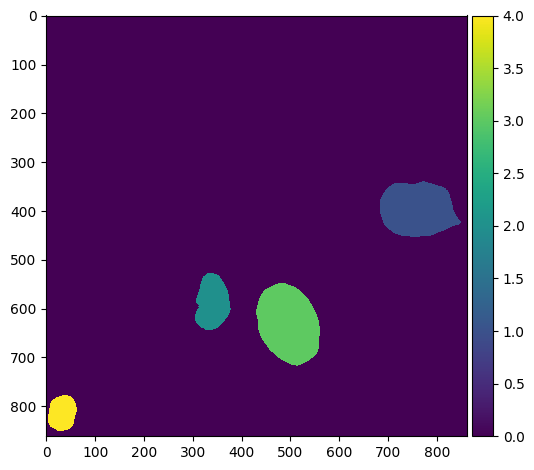

Cell:  2
Inclusion Area 1404.0
Max Inclusion Area: 358.0
Cell Area: 16503.0
Ratio: 0.0850754408289402
Max Inclusion/Cell Area: 0.02169302551051324
Average Inclusion/Cell Area 0.007089620069078349


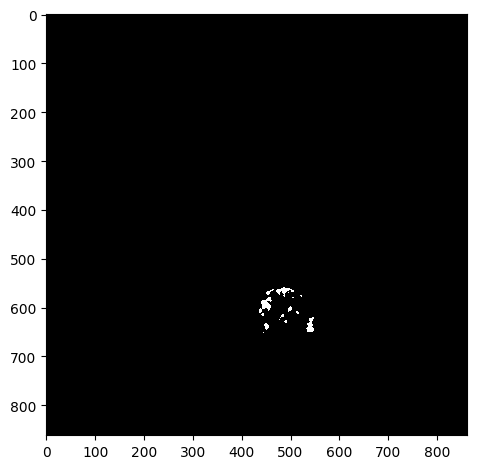

1K_PFF_HTRA1_Hoechst_20x_02.czi


C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\3987185336.py:138: RuntimeWarning: invalid value encountered in divide
  "Overlap_to_Inclusion_Area": np.array(overlap_areas)/np.array(total_inclusion_areas),


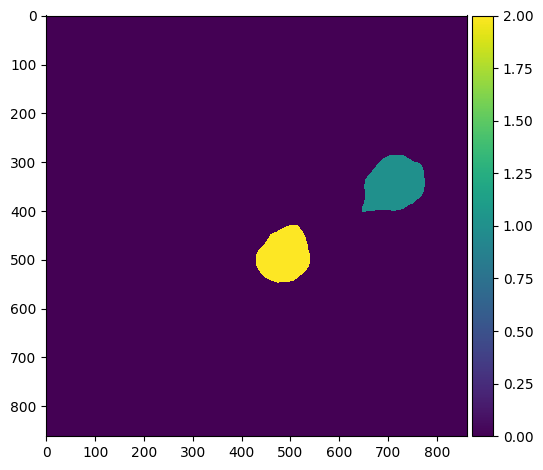

Cell:  0
Inclusion Area 1242.0
Max Inclusion Area: 307.0
Cell Area: 11510.0
Ratio: 0.10790616854908774
Max Inclusion/Cell Area: 0.02667245873153779
Average Inclusion/Cell Area 0.00899218071242398


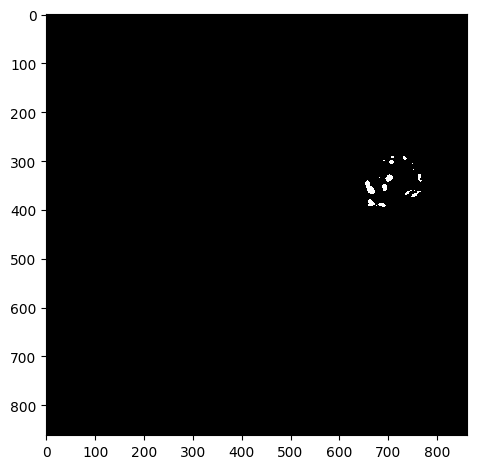

Cell:  1
Inclusion Area 407.0
Max Inclusion Area: 180.0
Cell Area: 9742.0
Ratio: 0.041777869020734965
Max Inclusion/Cell Area: 0.018476698829809075
Average Inclusion/Cell Area 0.013925956340244986


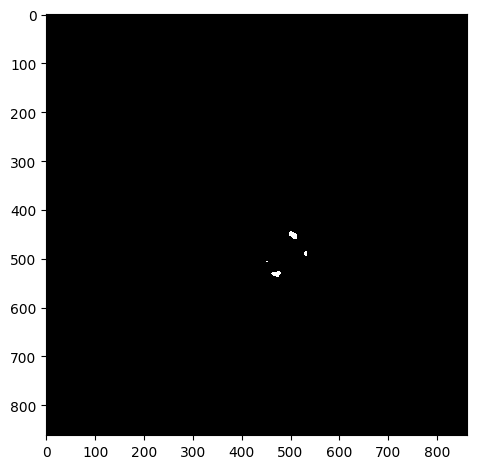

1K_PFF_HTRA1_Hoechst_20x_03.czi


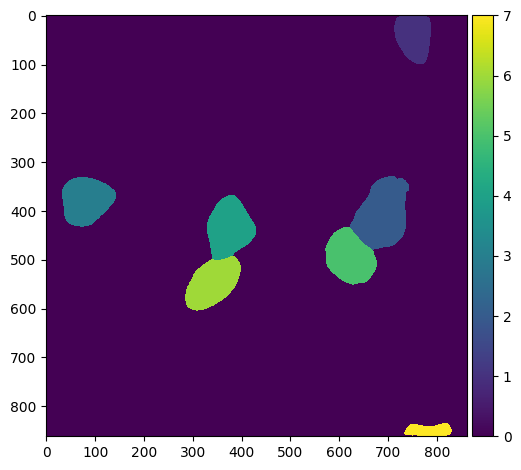

Cell:  1
Inclusion Area 2115.0
Max Inclusion Area: 745.0
Cell Area: 12627.0
Ratio: 0.16749821810406273
Max Inclusion/Cell Area: 0.059000554367624934
Average Inclusion/Cell Area 0.010468638631503921


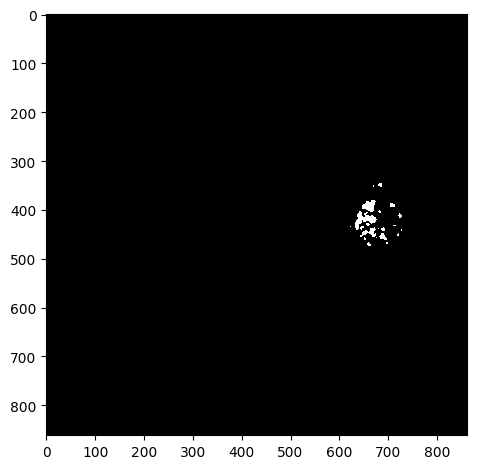

Cell:  3
Inclusion Area 1033.0
Max Inclusion Area: 790.0
Cell Area: 9333.0
Ratio: 0.11068252437587056
Max Inclusion/Cell Area: 0.0846458802100075
Average Inclusion/Cell Area 0.011068252437587056


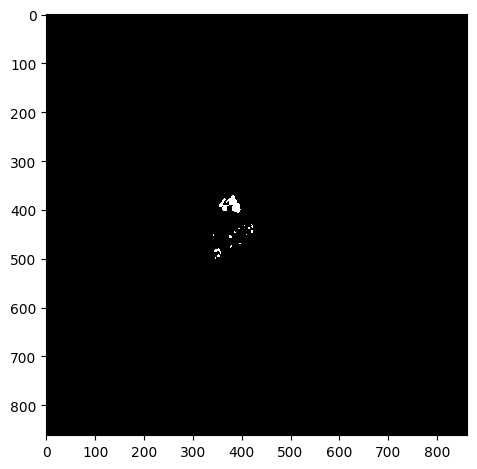

Cell:  4
Inclusion Area 661.0
Max Inclusion Area: 255.0
Cell Area: 8770.0
Ratio: 0.07537058152793615
Max Inclusion/Cell Area: 0.029076396807297605
Average Inclusion/Cell Area 0.006851871047994195


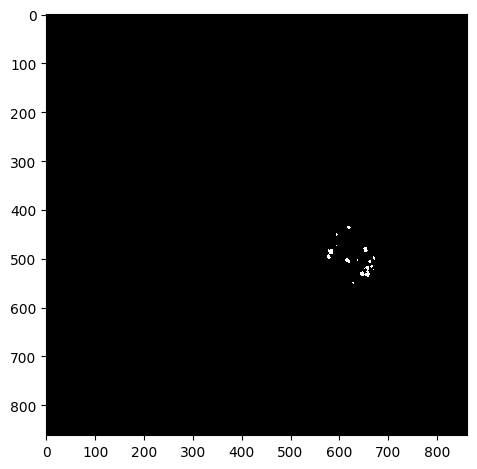

Cell:  5
Inclusion Area 2472.0
Max Inclusion Area: 2369.0
Cell Area: 8617.0
Ratio: 0.28687478240687014
Max Inclusion/Cell Area: 0.27492166647325056
Average Inclusion/Cell Area 0.04781246373447836


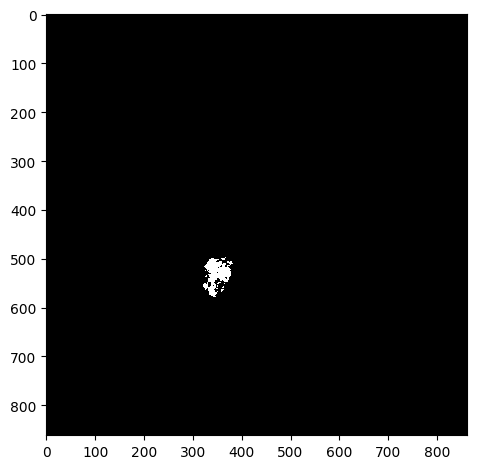

1K_PFF_HTRA1_Hoechst_20x_04.czi


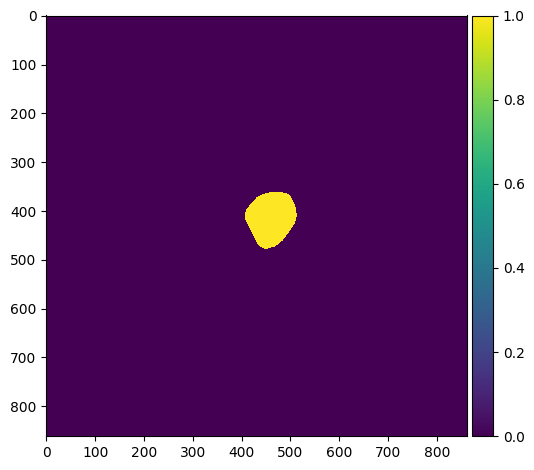

Cell:  0
Inclusion Area 1674.0
Max Inclusion Area: 989.0
Cell Area: 8982.0
Ratio: 0.18637274549098196
Max Inclusion/Cell Area: 0.11010910710309509
Average Inclusion/Cell Area 0.016942976862816542


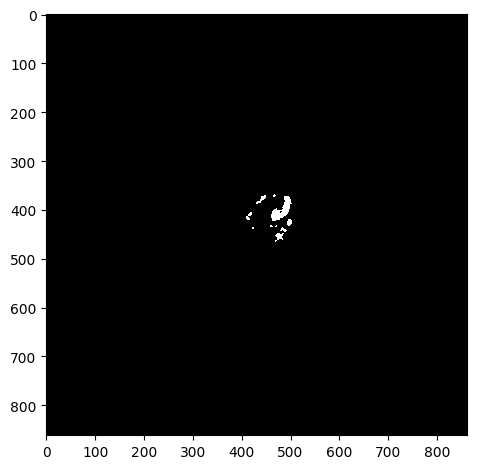

1K_PFF_HTRA1_Hoechst_20x_05.czi


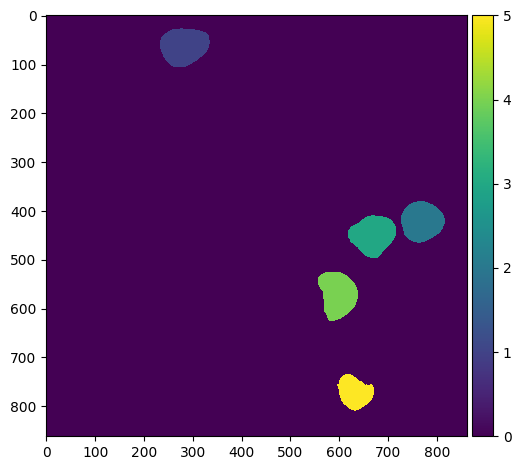

Cell:  2
Inclusion Area 1477.0
Max Inclusion Area: 1052.0
Cell Area: 6107.0
Ratio: 0.2418536106107745
Max Inclusion/Cell Area: 0.17226133944653677
Average Inclusion/Cell Area 0.06046340265269363


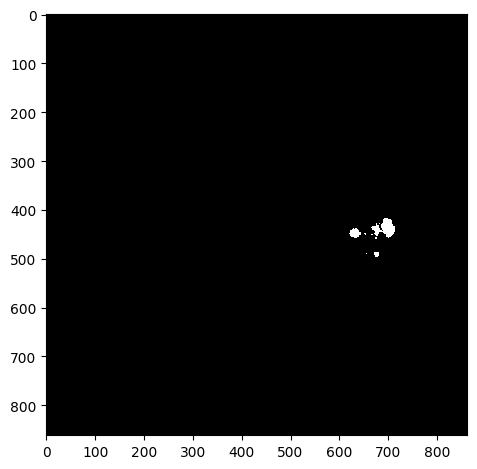

1K_PFF_HTRA1_Hoechst_20x_06.czi


C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\3987185336.py:139: RuntimeWarning: invalid value encountered in divide
  "Overlap_to_HTRA_Area": np.array(overlap_areas)/np.array(htra_areas)


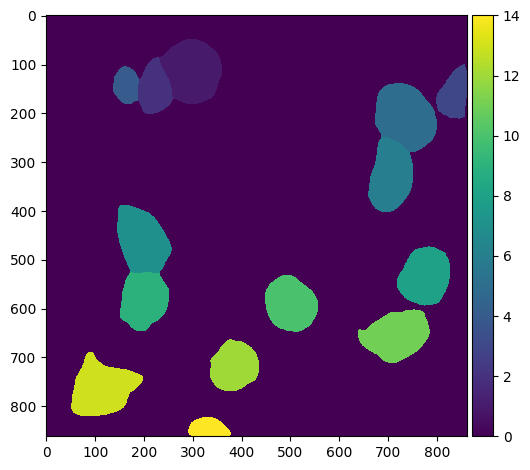

Cell:  1
Inclusion Area 1494.0
Max Inclusion Area: 1069.0
Cell Area: 5890.0
Ratio: 0.2536502546689304
Max Inclusion/Cell Area: 0.18149405772495755
Average Inclusion/Cell Area 0.02536502546689304


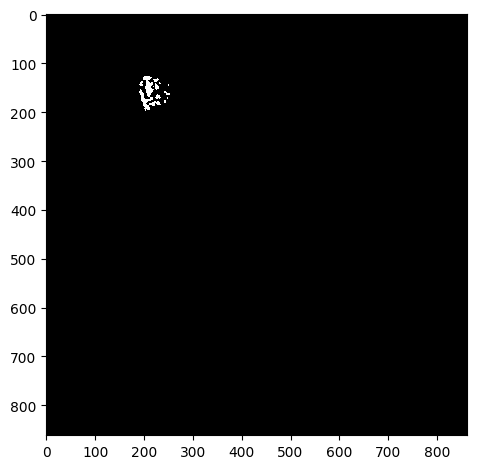

Cell:  2
Inclusion Area 193.0
Max Inclusion Area: 153.0
Cell Area: 4988.0
Ratio: 0.03869286287089014
Max Inclusion/Cell Area: 0.030673616680032077
Average Inclusion/Cell Area 0.012897620956963379


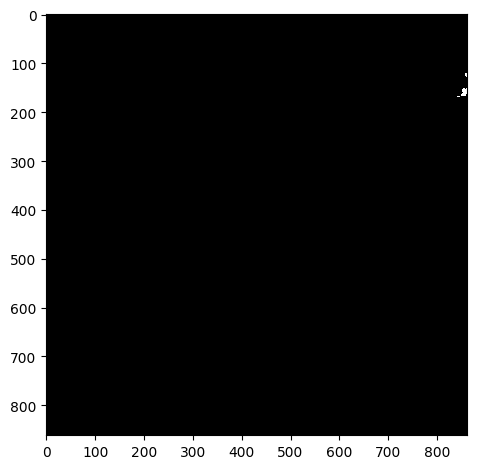

Cell:  3
Inclusion Area 404.0
Max Inclusion Area: 91.0
Cell Area: 3285.0
Ratio: 0.12298325722983257
Max Inclusion/Cell Area: 0.027701674277016742
Average Inclusion/Cell Area 0.013664806358870284


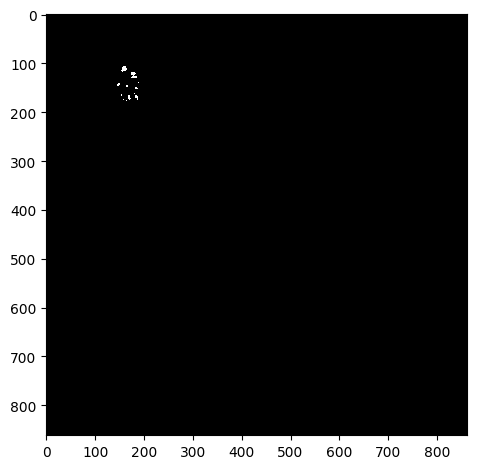

Cell:  5
Inclusion Area 2540.0
Max Inclusion Area: 1254.0
Cell Area: 10668.0
Ratio: 0.23809523809523808
Max Inclusion/Cell Area: 0.11754780652418448
Average Inclusion/Cell Area 0.023809523809523808


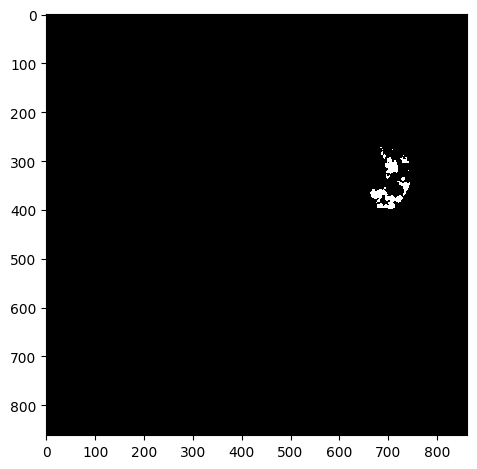

Cell:  6
Inclusion Area 383.0
Max Inclusion Area: 172.0
Cell Area: 11467.0
Ratio: 0.03340019185488794
Max Inclusion/Cell Area: 0.014999563966163774
Average Inclusion/Cell Area 0.006680038370977587


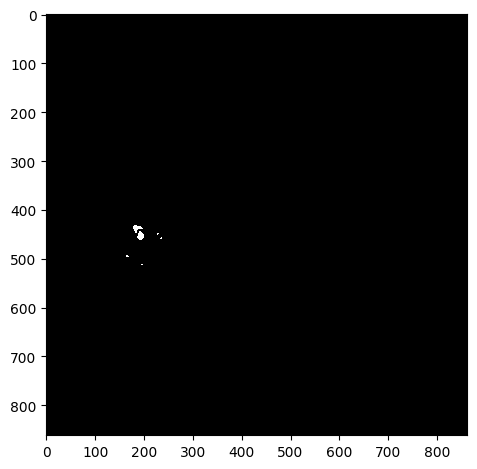

Cell:  7
Inclusion Area 114.0
Max Inclusion Area: 114.0
Cell Area: 10088.0
Ratio: 0.011300555114988104
Max Inclusion/Cell Area: 0.011300555114988104
Average Inclusion/Cell Area 0.011300555114988104


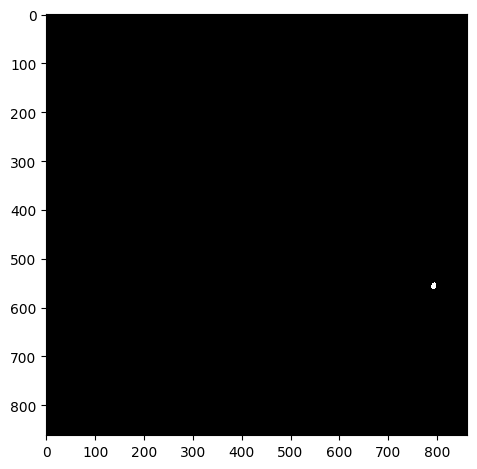

Cell:  9
Inclusion Area 1983.0
Max Inclusion Area: 1051.0
Cell Area: 9619.0
Ratio: 0.2061544859132966
Max Inclusion/Cell Area: 0.10926291714315417
Average Inclusion/Cell Area 0.012884655369581038


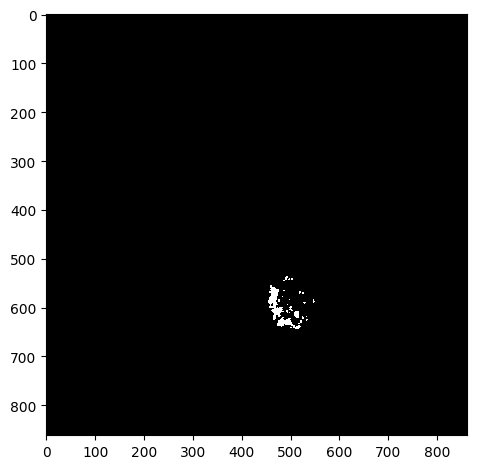

Cell:  10
Inclusion Area 159.0
Max Inclusion Area: 148.0
Cell Area: 11089.0
Ratio: 0.014338533682027234
Max Inclusion/Cell Area: 0.013346559653710885
Average Inclusion/Cell Area 0.007169266841013617


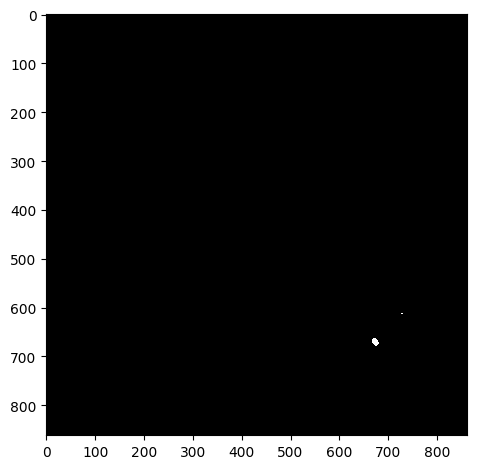

Cell:  11
Inclusion Area 424.0
Max Inclusion Area: 271.0
Cell Area: 8245.0
Ratio: 0.051425106124924194
Max Inclusion/Cell Area: 0.03286840509399636
Average Inclusion/Cell Area 0.0171417020416414


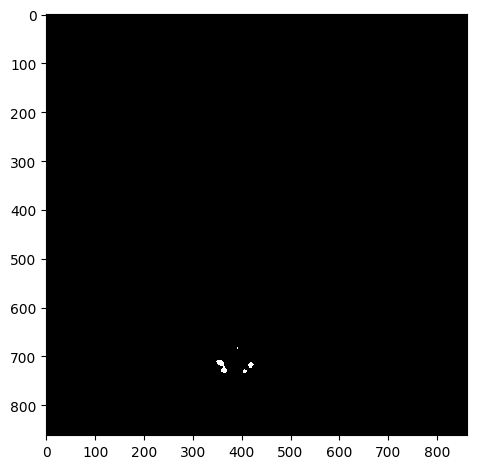

Cell:  12
Inclusion Area 1259.0
Max Inclusion Area: 337.0
Cell Area: 12248.0
Ratio: 0.10279229261920314
Max Inclusion/Cell Area: 0.027514696276943175
Average Inclusion/Cell Area 0.007342306615657367


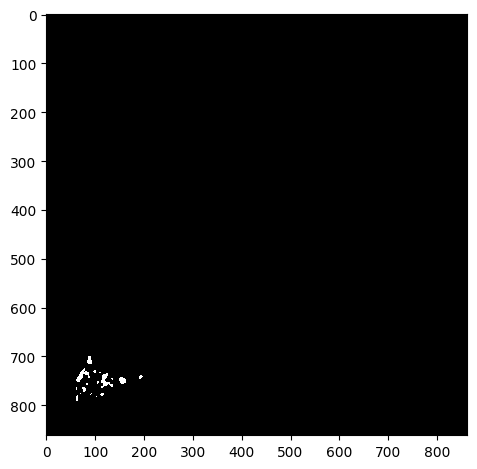

1K_PFF_HTRA1_Hoechst_20x_07.czi


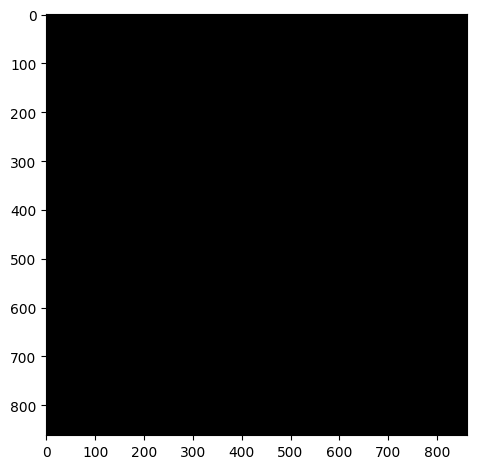

C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\2113827453.py:36: RuntimeWarning: invalid value encountered in scalar divide
  "Overlap_to_Inclusion_Area": [np.sum(overlap_areas) / np.sum(total_inclusion_areas)],
C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\2113827453.py:37: RuntimeWarning: invalid value encountered in scalar divide
  "Overlap_to_HTRA_Area": [np.sum(overlap_areas) / np.sum(htra_areas)],


1K_PFF_HTRA1_Hoechst_20x_08.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


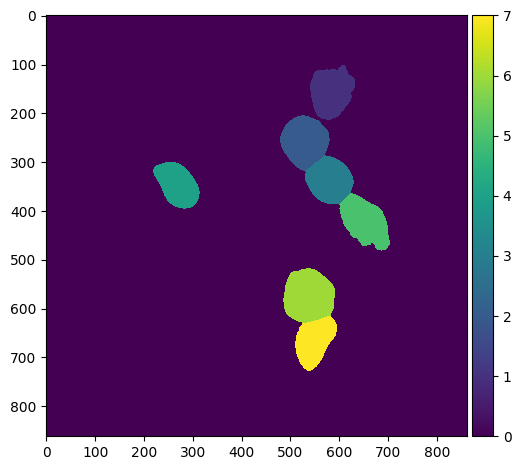

Cell:  0
Inclusion Area 789.0
Max Inclusion Area: 232.0
Cell Area: 7599.0
Ratio: 0.10382945124358468
Max Inclusion/Cell Area: 0.030530332938544544
Average Inclusion/Cell Area 0.00798688086489113


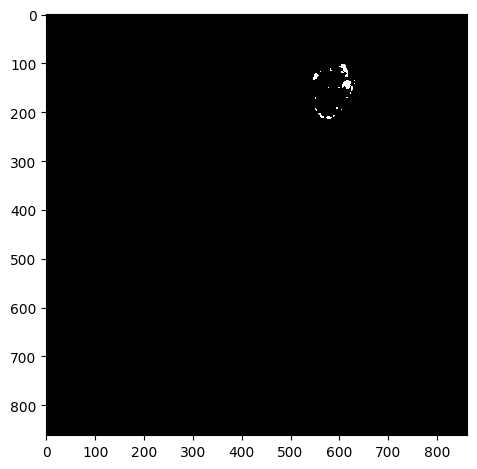

Cell:  5
Inclusion Area 449.0
Max Inclusion Area: 449.0
Cell Area: 9427.0
Ratio: 0.04762915031293094
Max Inclusion/Cell Area: 0.04762915031293094
Average Inclusion/Cell Area 0.04762915031293094


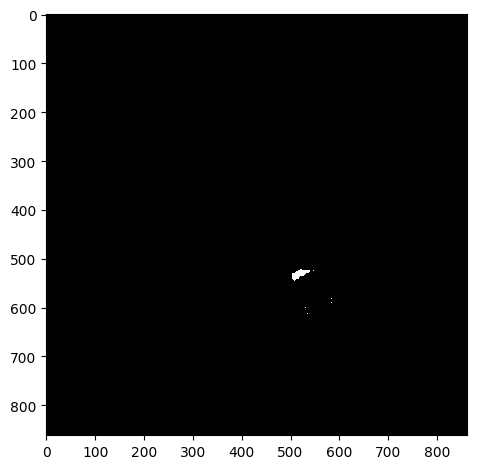

1K_PFF_HTRA1_Hoechst_20x_09.czi


C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\3987185336.py:138: RuntimeWarning: invalid value encountered in divide
  "Overlap_to_Inclusion_Area": np.array(overlap_areas)/np.array(total_inclusion_areas),
C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\3987185336.py:139: RuntimeWarning: invalid value encountered in divide
  "Overlap_to_HTRA_Area": np.array(overlap_areas)/np.array(htra_areas)


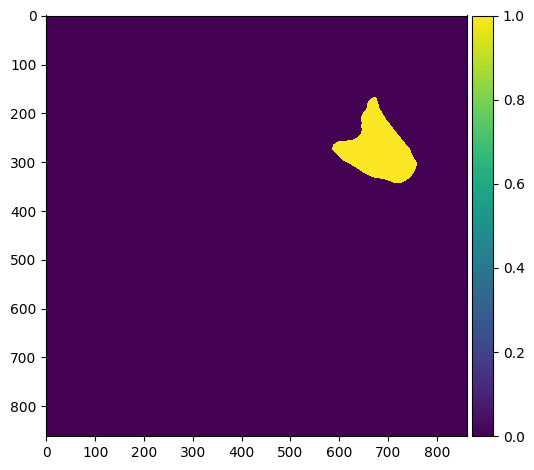

Cell:  0
Inclusion Area 1415.0
Max Inclusion Area: 475.0
Cell Area: 15177.0
Ratio: 0.0932331817882322
Max Inclusion/Cell Area: 0.03129735784410621
Average Inclusion/Cell Area 0.0058270738617645125


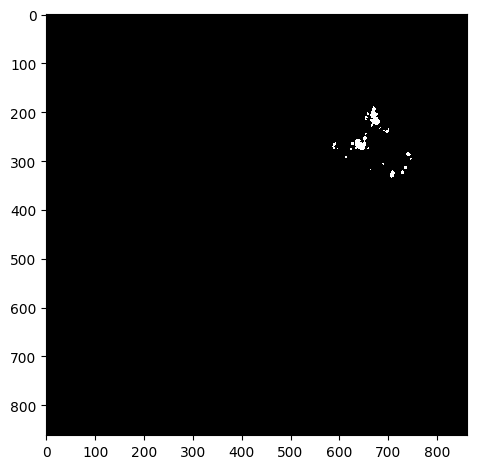

1K_PFF_HTRA1_Hoechst_20x_10.czi


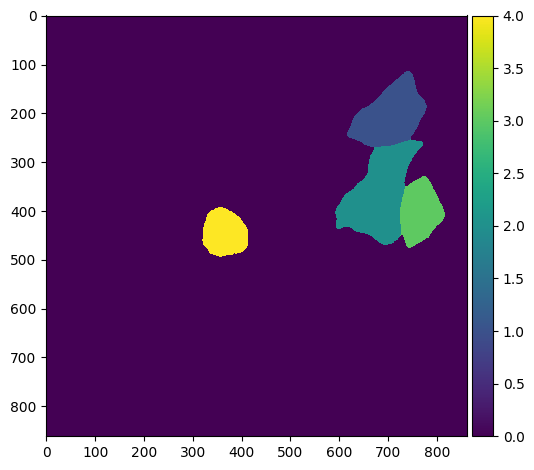

Cell:  1
Inclusion Area 1690.0
Max Inclusion Area: 1254.0
Cell Area: 20449.0
Ratio: 0.08264462809917356
Max Inclusion/Cell Area: 0.06132329209252286
Average Inclusion/Cell Area 0.010330578512396695


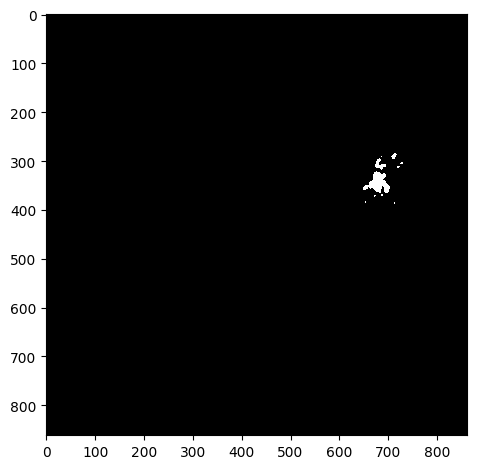

Cell:  2
Inclusion Area 1400.0
Max Inclusion Area: 1168.0
Cell Area: 9224.0
Ratio: 0.15177797051170858
Max Inclusion/Cell Area: 0.1266261925411969
Average Inclusion/Cell Area 0.016864218945745395


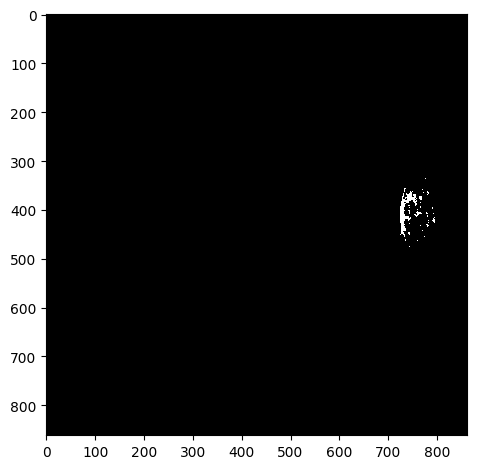

Cell:  3
Inclusion Area 1122.0
Max Inclusion Area: 371.0
Cell Area: 7411.0
Ratio: 0.1513965726622588
Max Inclusion/Cell Area: 0.05006072055053299
Average Inclusion/Cell Area 0.01892457158278235


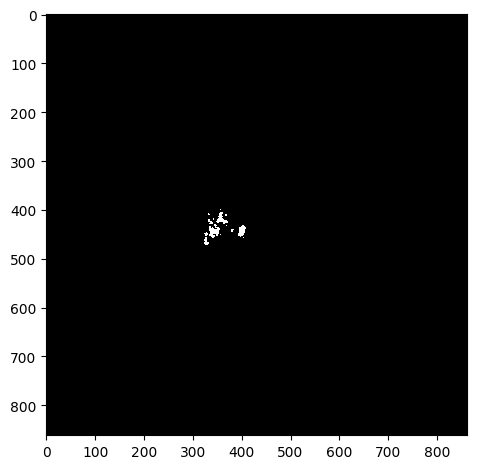

1K_PFF_no_HTRA1_Hoechst_20x_01.czi


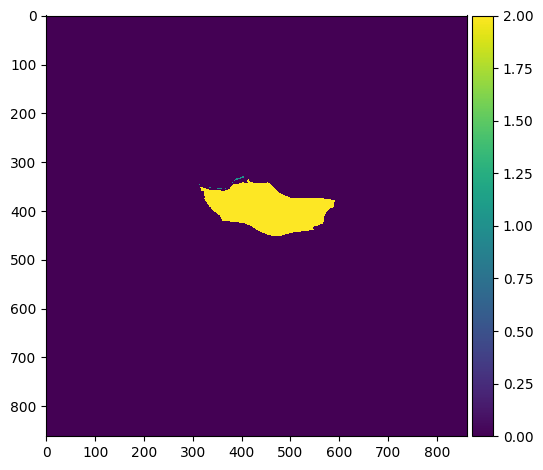

Cell:  1
Inclusion Area 109.0
Max Inclusion Area: 97.0
Cell Area: 18569.0
Ratio: 0.005869998384404114
Max Inclusion/Cell Area: 0.0052237600301577895
Average Inclusion/Cell Area 0.002934999192202057


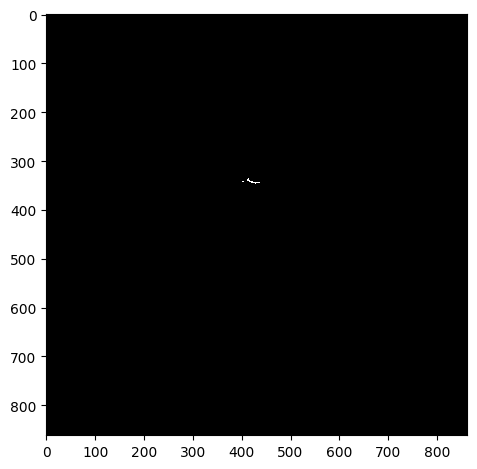

1K_PFF_no_HTRA1_Hoechst_20x_02.czi


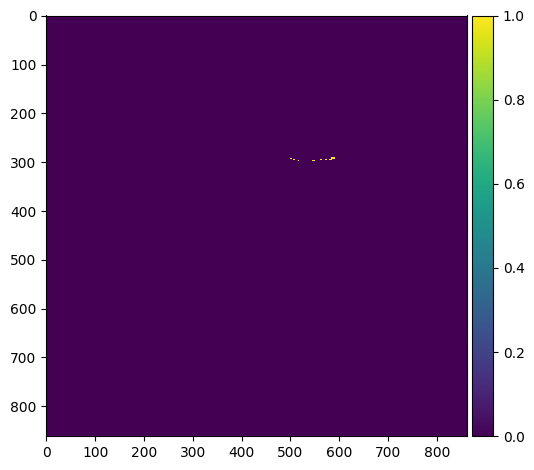

C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\2113827453.py:36: RuntimeWarning: invalid value encountered in scalar divide
  "Overlap_to_Inclusion_Area": [np.sum(overlap_areas) / np.sum(total_inclusion_areas)],
C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\2113827453.py:37: RuntimeWarning: invalid value encountered in scalar divide
  "Overlap_to_HTRA_Area": [np.sum(overlap_areas) / np.sum(htra_areas)],


1K_PFF_no_HTRA1_Hoechst_20x_03.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


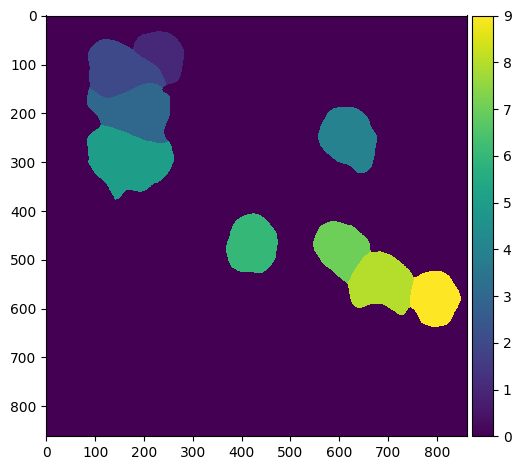

Cell:  2
Inclusion Area 3216.0
Max Inclusion Area: 2687.0
Cell Area: 13920.0
Ratio: 0.23103448275862068
Max Inclusion/Cell Area: 0.1930316091954023
Average Inclusion/Cell Area 0.01650246305418719


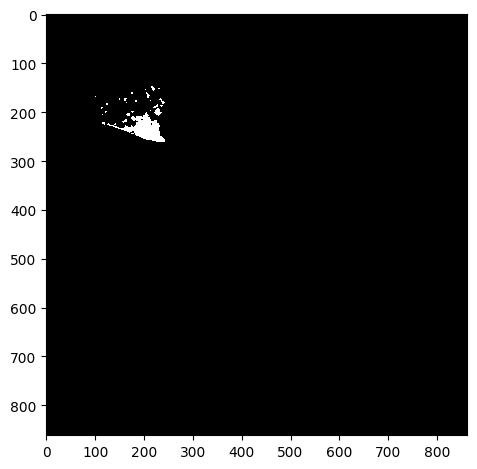

Cell:  3
Inclusion Area 2684.0
Max Inclusion Area: 2214.0
Cell Area: 11823.0
Ratio: 0.2270151399813922
Max Inclusion/Cell Area: 0.18726211621415884
Average Inclusion/Cell Area 0.028376892497674024


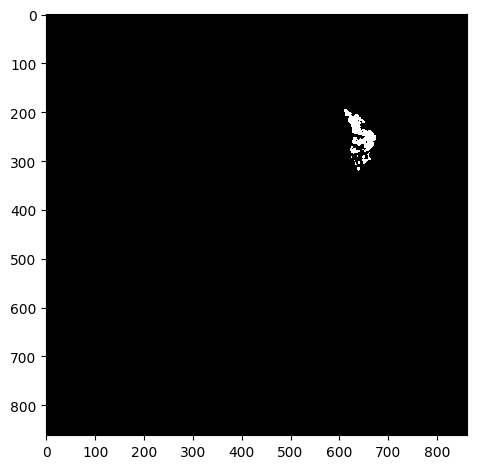

Cell:  4
Inclusion Area 724.0
Max Inclusion Area: 409.0
Cell Area: 17652.0
Ratio: 0.0410151824155903
Max Inclusion/Cell Area: 0.023170179016542034
Average Inclusion/Cell Area 0.004101518241559031


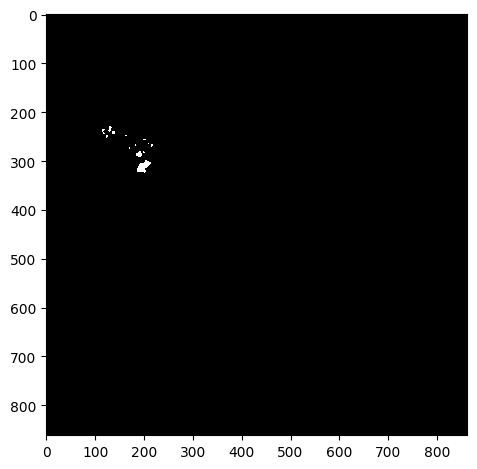

Cell:  8
Inclusion Area 178.0
Max Inclusion Area: 56.0
Cell Area: 9078.0
Ratio: 0.0196078431372549
Max Inclusion/Cell Area: 0.006168759638686935
Average Inclusion/Cell Area 0.004901960784313725


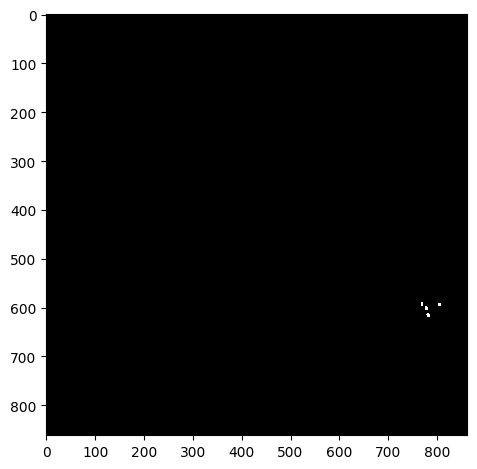

1K_PFF_no_HTRA1_Hoechst_20x_04.czi


C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\3987185336.py:138: RuntimeWarning: invalid value encountered in divide
  "Overlap_to_Inclusion_Area": np.array(overlap_areas)/np.array(total_inclusion_areas),


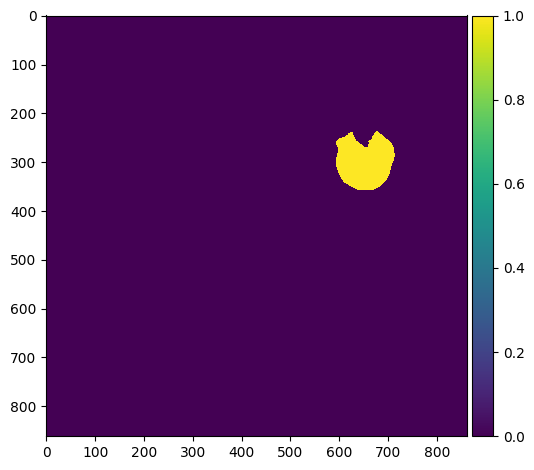

Cell:  0
Inclusion Area 304.0
Max Inclusion Area: 304.0
Cell Area: 10950.0
Ratio: 0.02776255707762557
Max Inclusion/Cell Area: 0.02776255707762557
Average Inclusion/Cell Area 0.02776255707762557


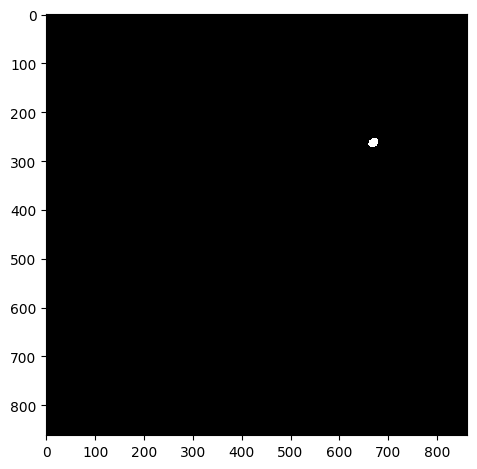

1K_PFF_no_HTRA1_Hoechst_20x_05.czi


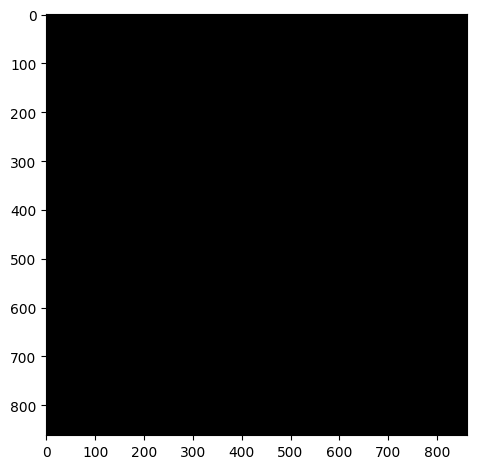

C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\2113827453.py:36: RuntimeWarning: invalid value encountered in scalar divide
  "Overlap_to_Inclusion_Area": [np.sum(overlap_areas) / np.sum(total_inclusion_areas)],
C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\2113827453.py:37: RuntimeWarning: invalid value encountered in scalar divide
  "Overlap_to_HTRA_Area": [np.sum(overlap_areas) / np.sum(htra_areas)],


1K_PFF_no_HTRA1_Hoechst_20x_06.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


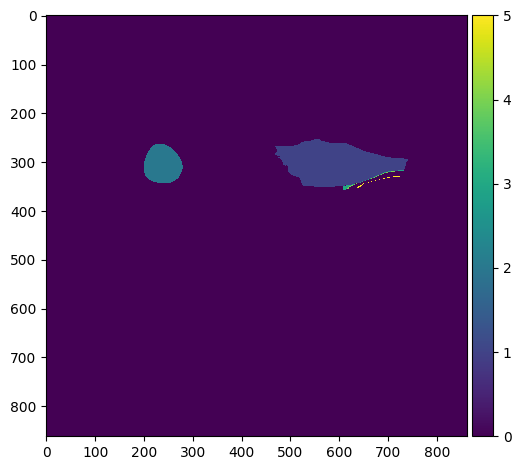

Cell:  0
Inclusion Area 410.0
Max Inclusion Area: 209.0
Cell Area: 16836.0
Ratio: 0.024352577809455926
Max Inclusion/Cell Area: 0.012413875029698266
Average Inclusion/Cell Area 0.008117525936485308


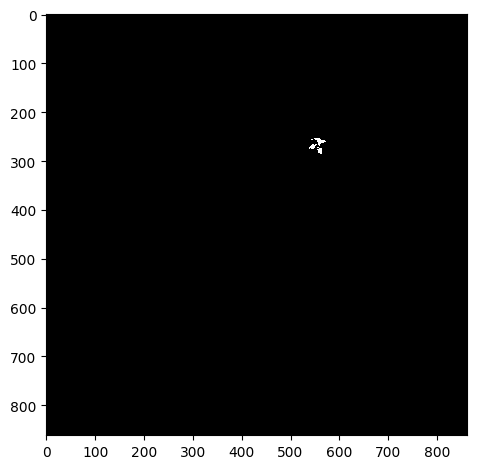

C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\3987185336.py:138: RuntimeWarning: invalid value encountered in divide
  "Overlap_to_Inclusion_Area": np.array(overlap_areas)/np.array(total_inclusion_areas),


1K_PFF_no_HTRA1_Hoechst_20x_07.czi


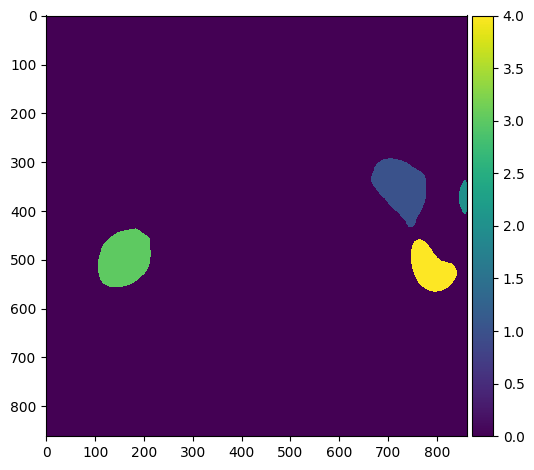

Cell:  0
Inclusion Area 499.0
Max Inclusion Area: 92.0
Cell Area: 10228.0
Ratio: 0.04878764176769652
Max Inclusion/Cell Area: 0.00899491591709034
Average Inclusion/Cell Area 0.004435240160699684


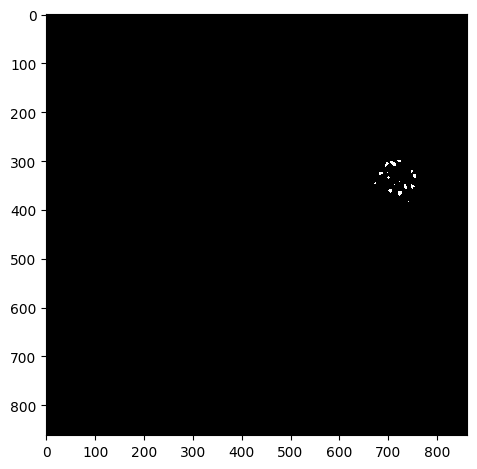

1K_PFF_no_HTRA1_Hoechst_20x_08.czi


C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\3987185336.py:139: RuntimeWarning: invalid value encountered in divide
  "Overlap_to_HTRA_Area": np.array(overlap_areas)/np.array(htra_areas)


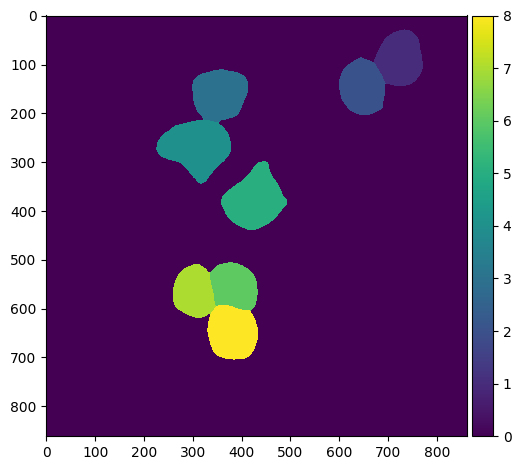

Cell:  4
Inclusion Area 1021.0
Max Inclusion Area: 305.0
Cell Area: 11838.0
Ratio: 0.08624767697246156
Max Inclusion/Cell Area: 0.02576448724446697
Average Inclusion/Cell Area 0.014374612828743593


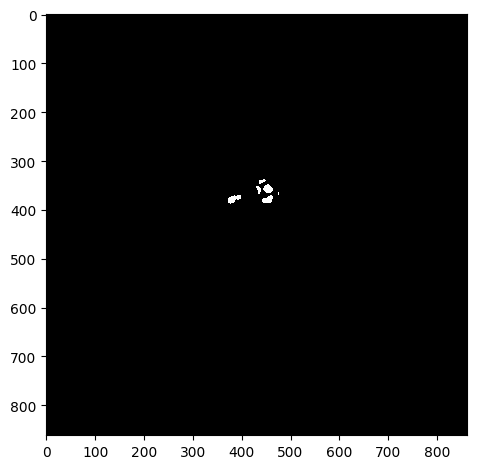

Cell:  5
Inclusion Area 293.0
Max Inclusion Area: 269.0
Cell Area: 7644.0
Ratio: 0.03833071690214547
Max Inclusion/Cell Area: 0.03519099947671376
Average Inclusion/Cell Area 0.019165358451072735


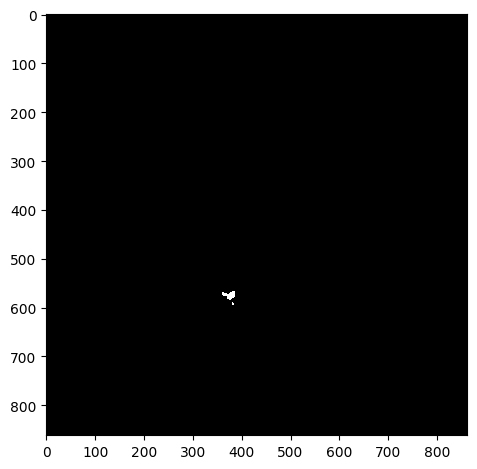

Cell:  7
Inclusion Area 170.0
Max Inclusion Area: 110.0
Cell Area: 9546.0
Ratio: 0.017808506180599204
Max Inclusion/Cell Area: 0.011523151058034779
Average Inclusion/Cell Area 0.005936168726866401


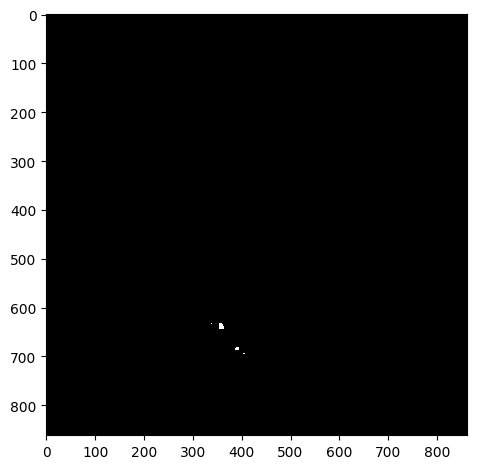

1K_PFF_no_HTRA1_Hoechst_20x_09.czi


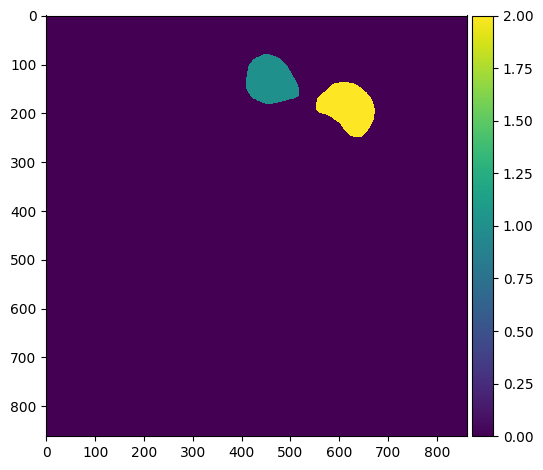

Cell:  0
Inclusion Area 615.0
Max Inclusion Area: 588.0
Cell Area: 8376.0
Ratio: 0.07342406876790832
Max Inclusion/Cell Area: 0.07020057306590258
Average Inclusion/Cell Area 0.02447468958930277


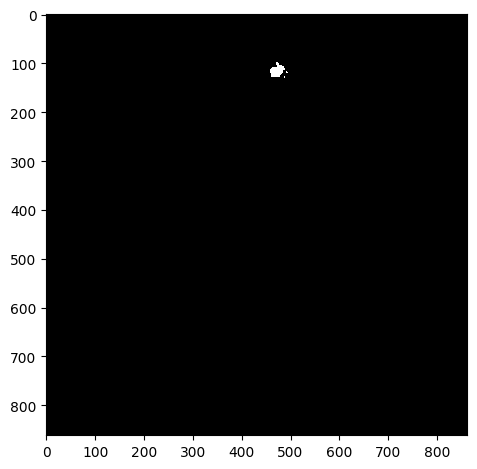

Cell:  1
Inclusion Area 599.0
Max Inclusion Area: 375.0
Cell Area: 9087.0
Ratio: 0.06591834488830196
Max Inclusion/Cell Area: 0.041267745130406076
Average Inclusion/Cell Area 0.01647958622207549


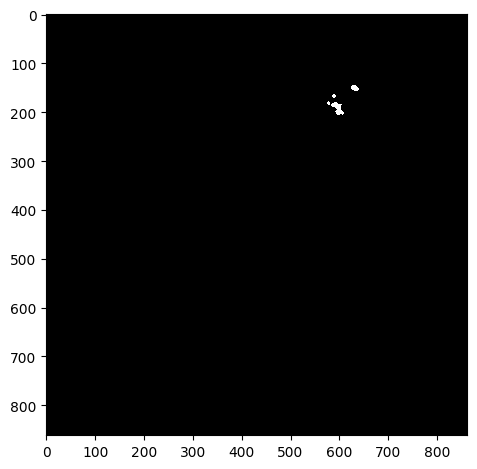

1K_PFF_no_HTRA1_Hoechst_20x_10.czi


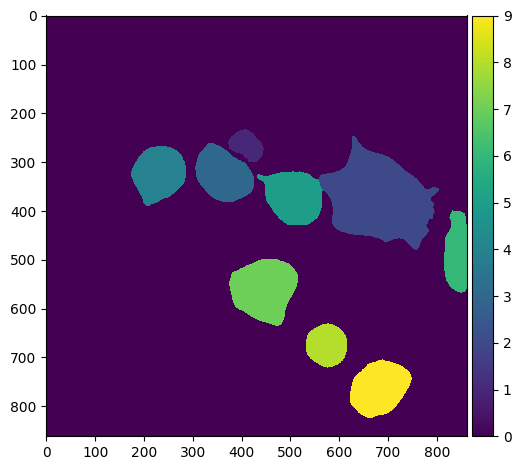

Cell:  4
Inclusion Area 2345.0
Max Inclusion Area: 790.0
Cell Area: 10847.0
Ratio: 0.21618880796533604
Max Inclusion/Cell Area: 0.07283119756614732
Average Inclusion/Cell Area 0.027023600995667005


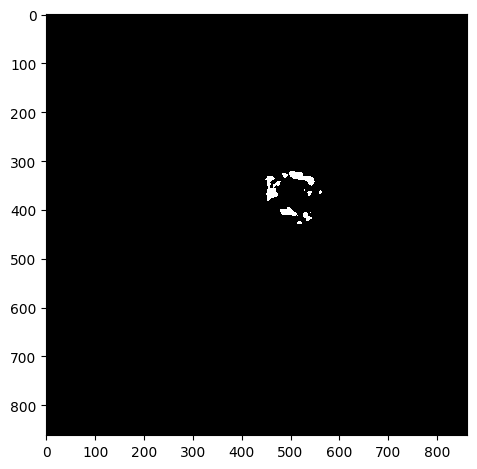

Cell:  6
Inclusion Area 318.0
Max Inclusion Area: 63.0
Cell Area: 13983.0
Ratio: 0.02274190087963956
Max Inclusion/Cell Area: 0.004505470928985196
Average Inclusion/Cell Area 0.002842737609954945


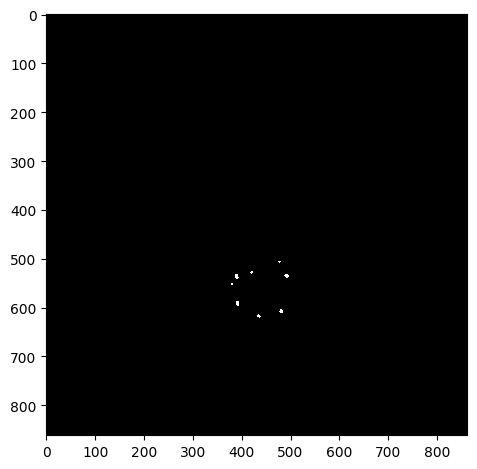

Cell:  7
Inclusion Area 569.0
Max Inclusion Area: 464.0
Cell Area: 5986.0
Ratio: 0.09505512863347812
Max Inclusion/Cell Area: 0.07751419979953224
Average Inclusion/Cell Area 0.02376378215836953


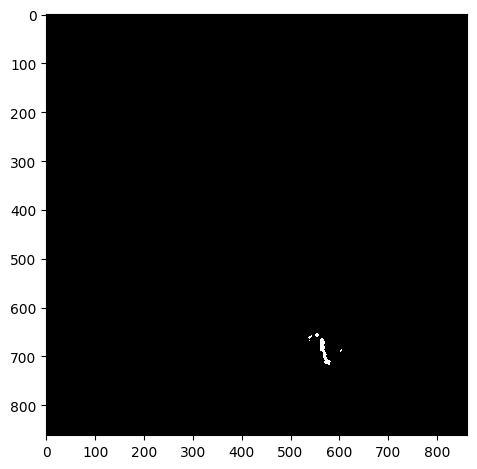

wt_PFF_HTRA1_Hoechst_20x_01.czi


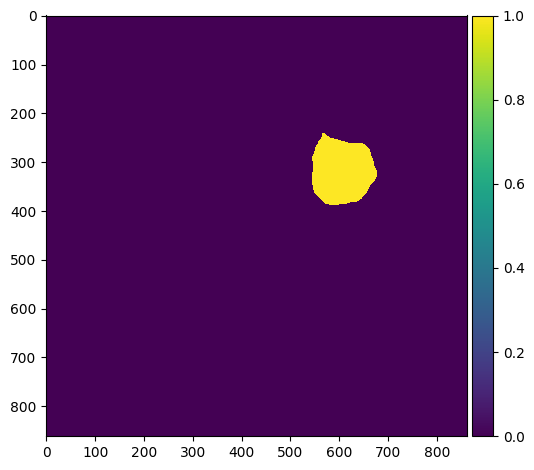

Cell:  0
Inclusion Area 228.0
Max Inclusion Area: 228.0
Cell Area: 14776.0
Ratio: 0.015430427720628045
Max Inclusion/Cell Area: 0.015430427720628045
Average Inclusion/Cell Area 0.015430427720628045


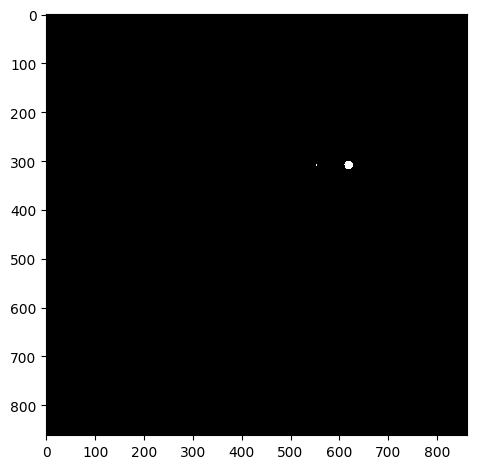

wt_PFF_HTRA1_Hoechst_20x_02.czi


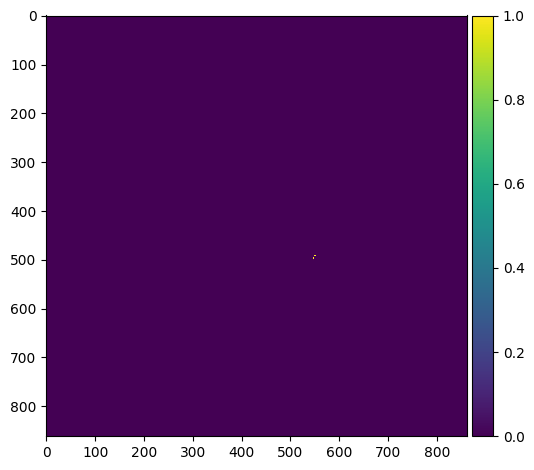

C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\2113827453.py:36: RuntimeWarning: invalid value encountered in scalar divide
  "Overlap_to_Inclusion_Area": [np.sum(overlap_areas) / np.sum(total_inclusion_areas)],
C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\2113827453.py:37: RuntimeWarning: invalid value encountered in scalar divide
  "Overlap_to_HTRA_Area": [np.sum(overlap_areas) / np.sum(htra_areas)],


wt_PFF_HTRA1_Hoechst_20x_03.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


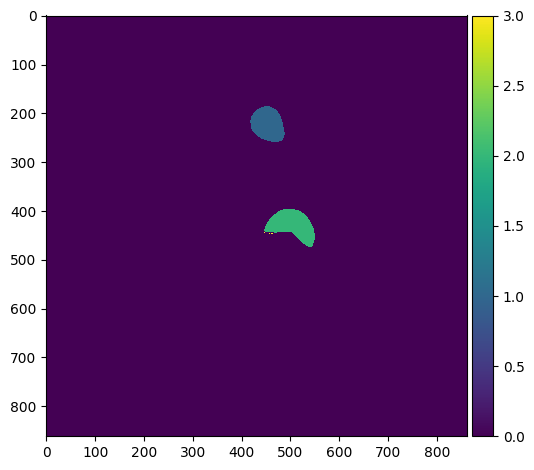

C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\2113827453.py:36: RuntimeWarning: invalid value encountered in scalar divide
  "Overlap_to_Inclusion_Area": [np.sum(overlap_areas) / np.sum(total_inclusion_areas)],
C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\2113827453.py:37: RuntimeWarning: invalid value encountered in scalar divide
  "Overlap_to_HTRA_Area": [np.sum(overlap_areas) / np.sum(htra_areas)],
C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\3987185336.py:138: RuntimeWarning: invalid value encountered in divide
  "Overlap_to_Inclusion_Area": np.array(overlap_areas)/np.array(total_inclusion_areas),
C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\3987185336.py:139: RuntimeWarning: invalid value encountered in divide
  "Overlap_to_HTRA_Area": np.array(overlap_areas)/np.array(htra_areas)


wt_PFF_HTRA1_Hoechst_20x_04.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


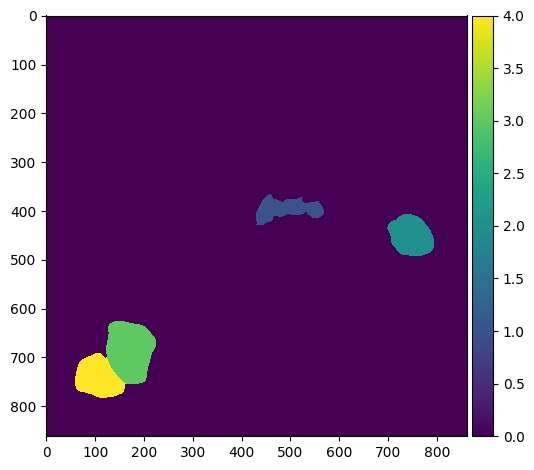

Cell:  0
Inclusion Area 610.0
Max Inclusion Area: 354.0
Cell Area: 4825.0
Ratio: 0.12642487046632125
Max Inclusion/Cell Area: 0.07336787564766839
Average Inclusion/Cell Area 0.06321243523316063


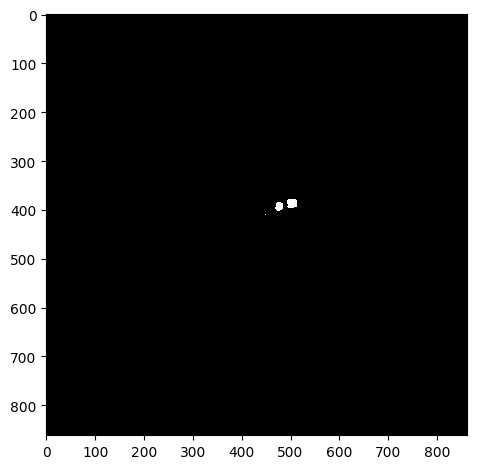

wt_PFF_HTRA1_Hoechst_20x_05.czi


C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\3987185336.py:138: RuntimeWarning: invalid value encountered in divide
  "Overlap_to_Inclusion_Area": np.array(overlap_areas)/np.array(total_inclusion_areas),


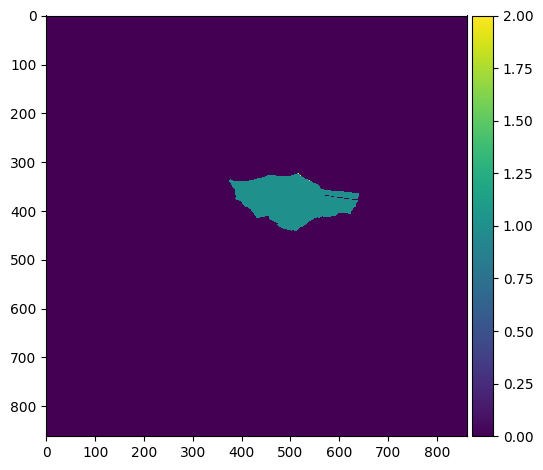

Cell:  0
Inclusion Area 1649.0
Max Inclusion Area: 1649.0
Cell Area: 18260.0
Ratio: 0.09030668127053669
Max Inclusion/Cell Area: 0.09030668127053669
Average Inclusion/Cell Area 0.09030668127053669


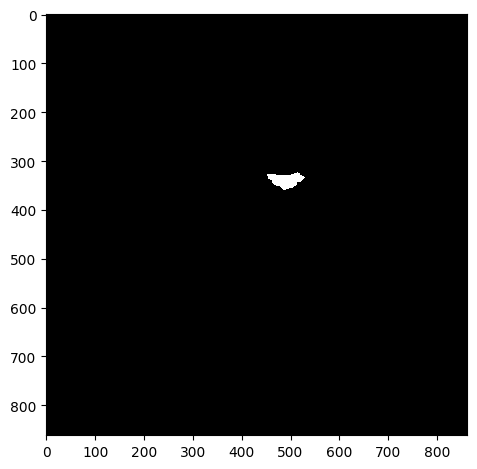

wt_PFF_HTRA1_Hoechst_20x_06.czi


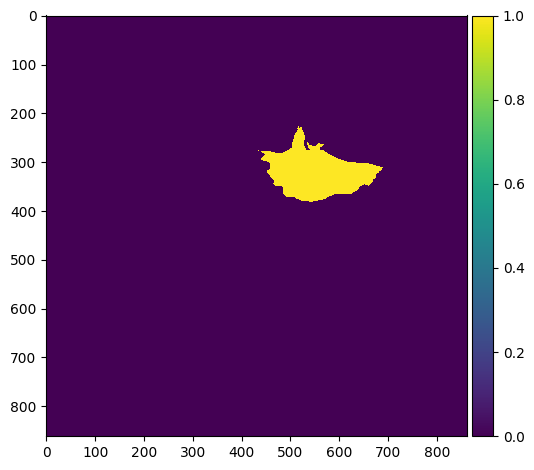

Cell:  0
Inclusion Area 207.0
Max Inclusion Area: 73.0
Cell Area: 18623.0
Ratio: 0.011115287547656123
Max Inclusion/Cell Area: 0.003919884014390807
Average Inclusion/Cell Area 0.002778821886914031


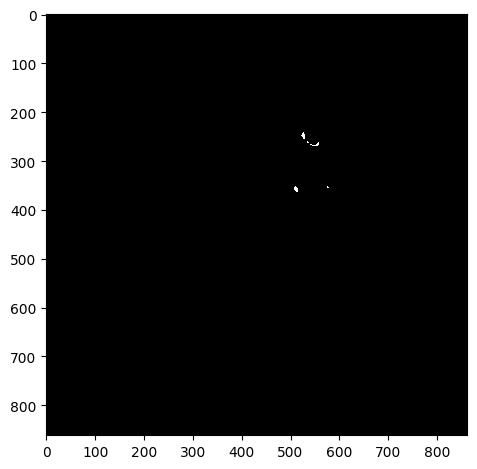

wt_PFF_HTRA1_Hoechst_20x_07.czi


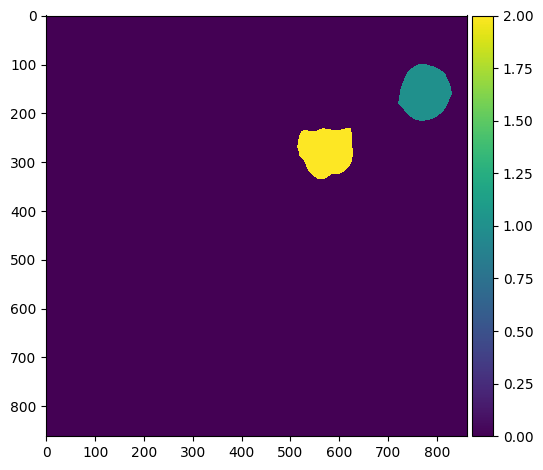

C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\2113827453.py:36: RuntimeWarning: invalid value encountered in scalar divide
  "Overlap_to_Inclusion_Area": [np.sum(overlap_areas) / np.sum(total_inclusion_areas)],


wt_PFF_HTRA1_Hoechst_20x_08.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


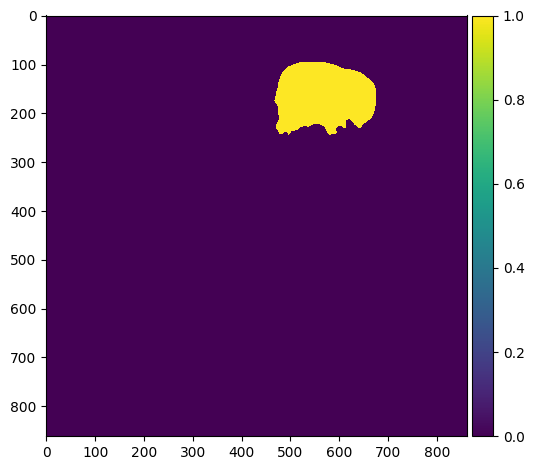

Cell:  0
Inclusion Area 3764.0
Max Inclusion Area: 1518.0
Cell Area: 24353.0
Ratio: 0.15456001314006487
Max Inclusion/Cell Area: 0.06233318277008993
Average Inclusion/Cell Area 0.007360000625717376


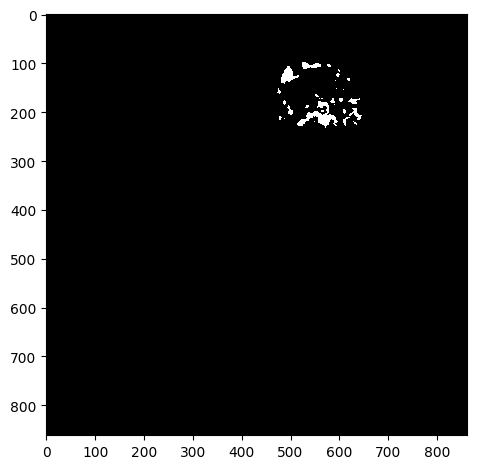

wt_PFF_HTRA1_Hoechst_20x_09.czi


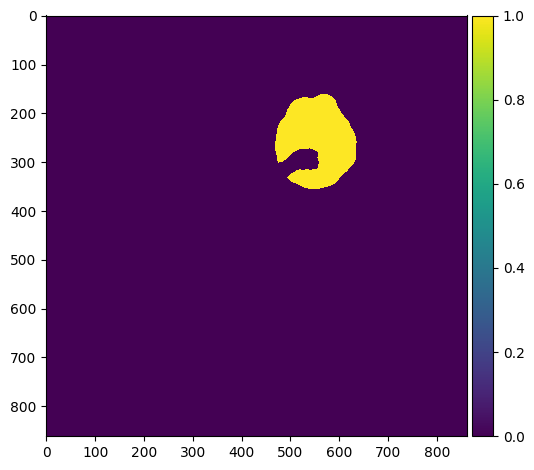

C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\2113827453.py:36: RuntimeWarning: invalid value encountered in scalar divide
  "Overlap_to_Inclusion_Area": [np.sum(overlap_areas) / np.sum(total_inclusion_areas)],
C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\3987185336.py:138: RuntimeWarning: invalid value encountered in divide
  "Overlap_to_Inclusion_Area": np.array(overlap_areas)/np.array(total_inclusion_areas),


wt_PFF_HTRA1_Hoechst_20x_10.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


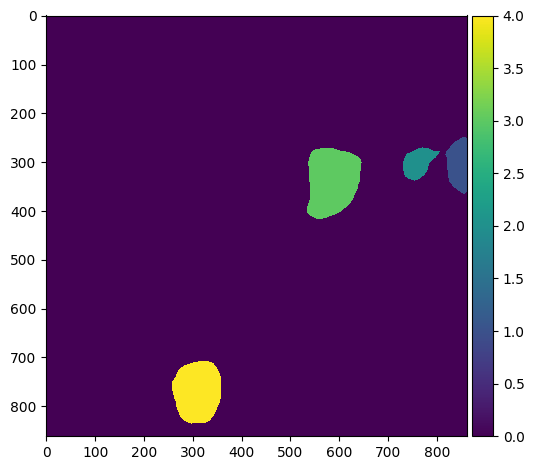

Cell:  2
Inclusion Area 685.0
Max Inclusion Area: 184.0
Cell Area: 12792.0
Ratio: 0.05354909318323953
Max Inclusion/Cell Area: 0.014383989993746092
Average Inclusion/Cell Area 0.004868099380294502


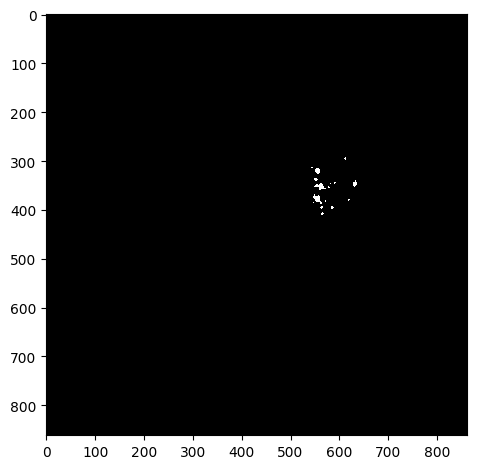

wt_PFF_no_HTRA1_Hoechst_20x_01.czi


C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\3987185336.py:138: RuntimeWarning: invalid value encountered in divide
  "Overlap_to_Inclusion_Area": np.array(overlap_areas)/np.array(total_inclusion_areas),


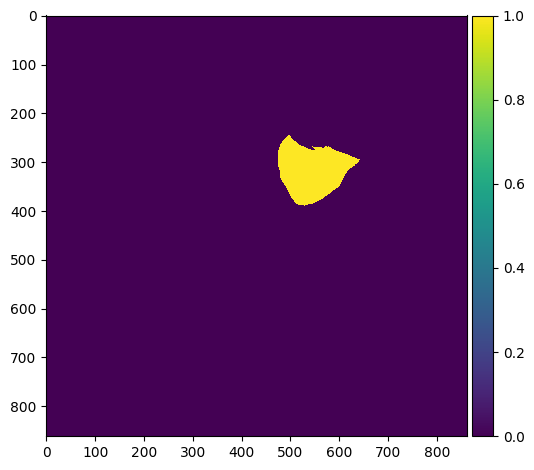

C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\2113827453.py:36: RuntimeWarning: invalid value encountered in scalar divide
  "Overlap_to_Inclusion_Area": [np.sum(overlap_areas) / np.sum(total_inclusion_areas)],


wt_PFF_no_HTRA1_Hoechst_20x_02.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


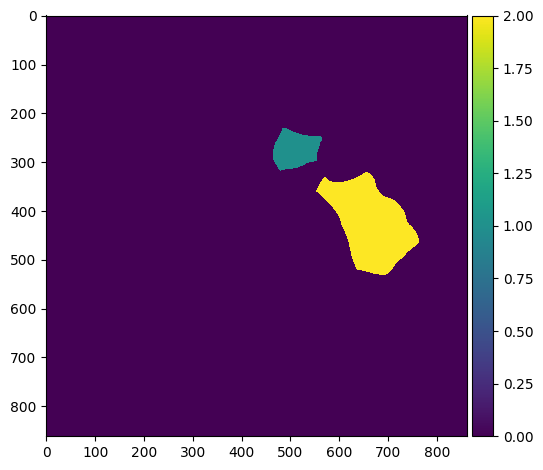

C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\2113827453.py:36: RuntimeWarning: invalid value encountered in scalar divide
  "Overlap_to_Inclusion_Area": [np.sum(overlap_areas) / np.sum(total_inclusion_areas)],
C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\3987185336.py:138: RuntimeWarning: invalid value encountered in divide
  "Overlap_to_Inclusion_Area": np.array(overlap_areas)/np.array(total_inclusion_areas),


wt_PFF_no_HTRA1_Hoechst_20x_03.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


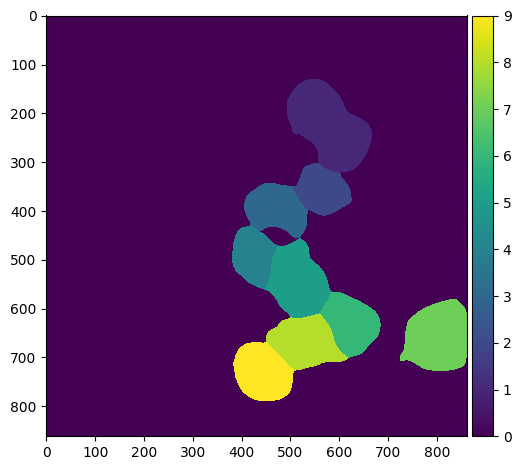

Cell:  0
Inclusion Area 2572.0
Max Inclusion Area: 1221.0
Cell Area: 20948.0
Ratio: 0.12278021768187894
Max Inclusion/Cell Area: 0.0582871873209853
Average Inclusion/Cell Area 0.017540031097411278


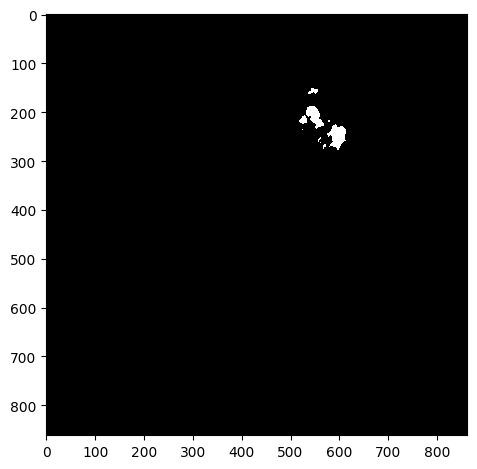

Cell:  2
Inclusion Area 482.0
Max Inclusion Area: 285.0
Cell Area: 10502.0
Ratio: 0.04589601980575129
Max Inclusion/Cell Area: 0.027137688059417252
Average Inclusion/Cell Area 0.015298673268583762


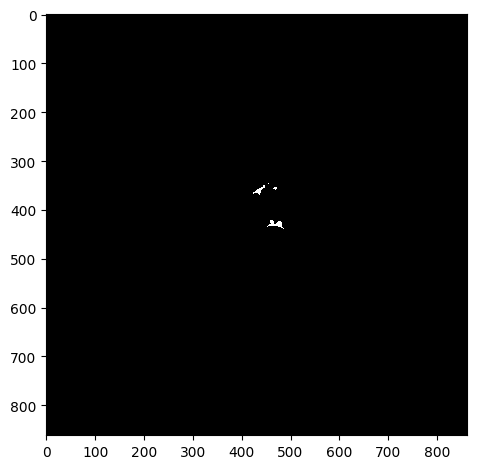

Cell:  3
Inclusion Area 964.0
Max Inclusion Area: 352.0
Cell Area: 8352.0
Ratio: 0.11542145593869732
Max Inclusion/Cell Area: 0.0421455938697318
Average Inclusion/Cell Area 0.012824606215410813


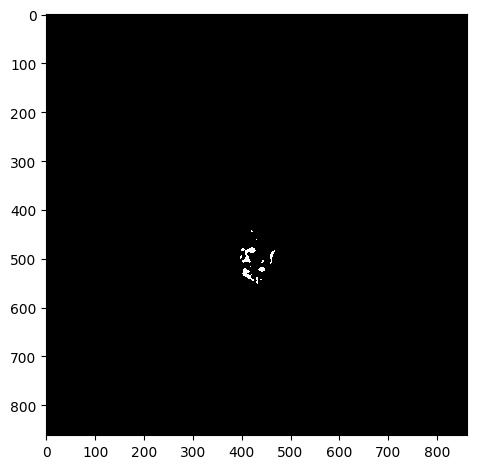

Cell:  4
Inclusion Area 758.0
Max Inclusion Area: 645.0
Cell Area: 14601.0
Ratio: 0.051914252448462435
Max Inclusion/Cell Area: 0.044175056502979246
Average Inclusion/Cell Area 0.025957126224231217


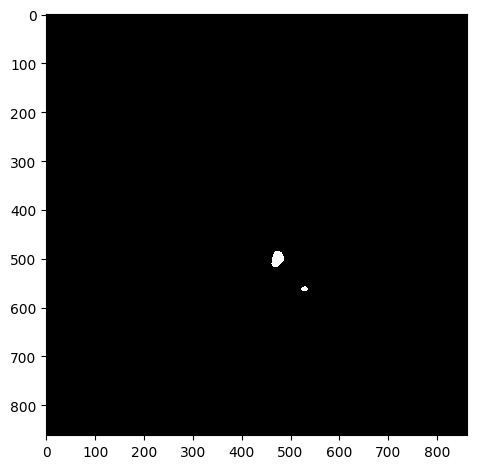

Cell:  7
Inclusion Area 730.0
Max Inclusion Area: 730.0
Cell Area: 12316.0
Ratio: 0.05927249106852874
Max Inclusion/Cell Area: 0.05927249106852874
Average Inclusion/Cell Area 0.05927249106852874


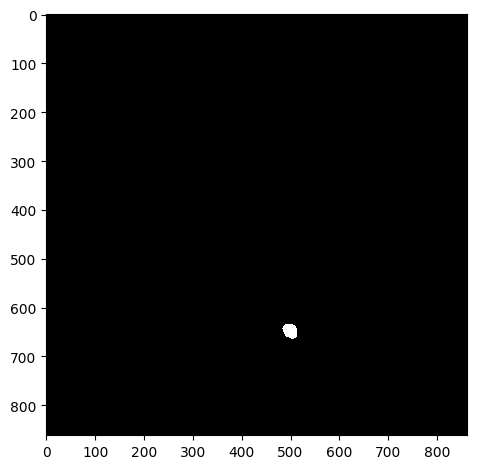

wt_PFF_no_HTRA1_Hoechst_20x_04.czi


C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\3987185336.py:138: RuntimeWarning: invalid value encountered in divide
  "Overlap_to_Inclusion_Area": np.array(overlap_areas)/np.array(total_inclusion_areas),
C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\3987185336.py:139: RuntimeWarning: invalid value encountered in divide
  "Overlap_to_HTRA_Area": np.array(overlap_areas)/np.array(htra_areas)


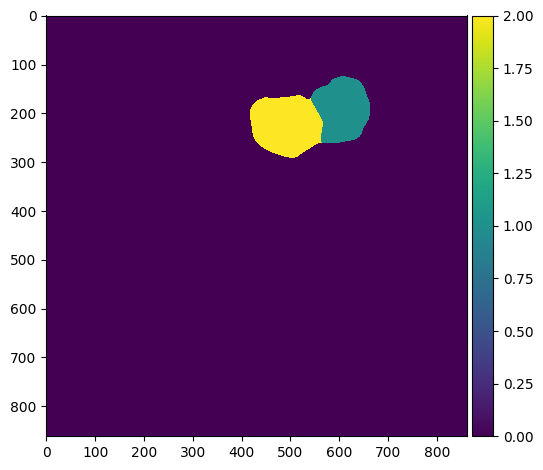

Cell:  0
Inclusion Area 2655.0
Max Inclusion Area: 1884.0
Cell Area: 12304.0
Ratio: 0.21578348504551365
Max Inclusion/Cell Area: 0.15312093628088427
Average Inclusion/Cell Area 0.03596391417425228


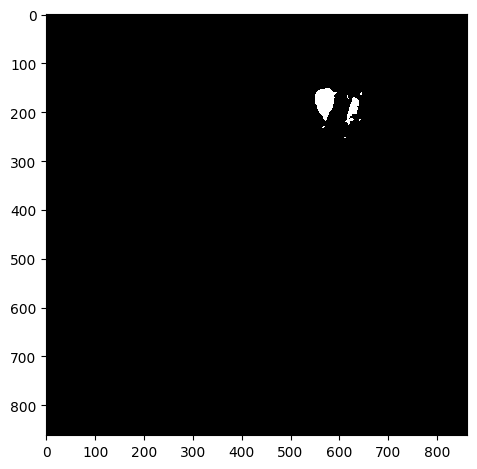

wt_PFF_no_HTRA1_Hoechst_20x_05.czi


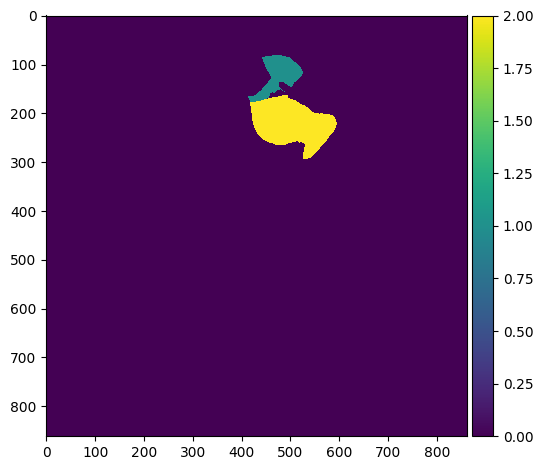

Cell:  0
Inclusion Area 1296.0
Max Inclusion Area: 425.0
Cell Area: 4889.0
Ratio: 0.26508488443444467
Max Inclusion/Cell Area: 0.08692984250357946
Average Inclusion/Cell Area 0.03313561055430558


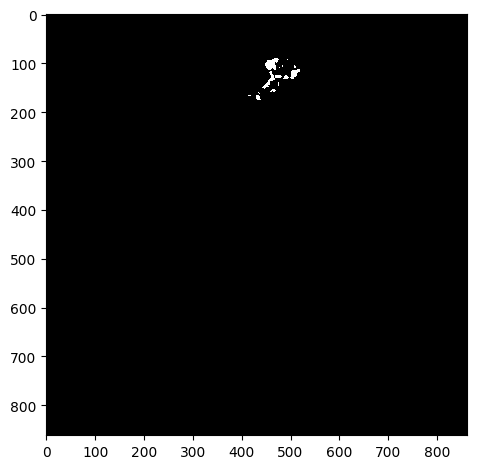

Cell:  1
Inclusion Area 666.0
Max Inclusion Area: 364.0
Cell Area: 13812.0
Ratio: 0.04821894005212858
Max Inclusion/Cell Area: 0.026353895163625834
Average Inclusion/Cell Area 0.009643788010425716


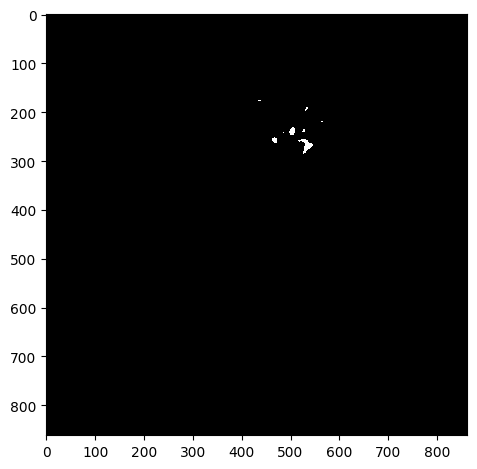

wt_PFF_no_HTRA1_Hoechst_20x_06.czi


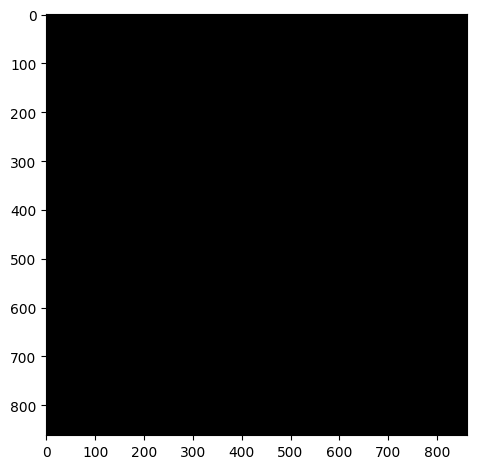

C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\2113827453.py:36: RuntimeWarning: invalid value encountered in scalar divide
  "Overlap_to_Inclusion_Area": [np.sum(overlap_areas) / np.sum(total_inclusion_areas)],
C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\2113827453.py:37: RuntimeWarning: invalid value encountered in scalar divide
  "Overlap_to_HTRA_Area": [np.sum(overlap_areas) / np.sum(htra_areas)],


wt_PFF_no_HTRA1_Hoechst_20x_07.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


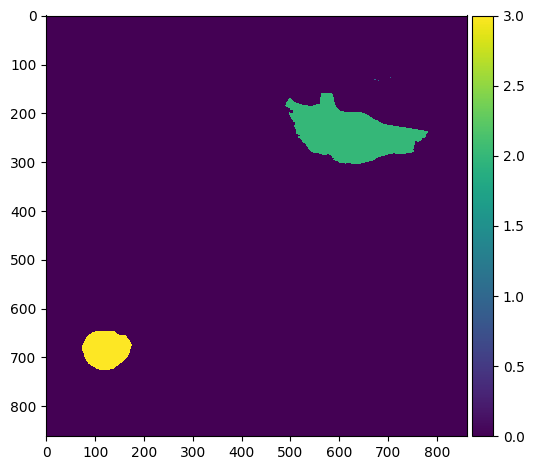

Cell:  5
Inclusion Area 1135.0
Max Inclusion Area: 1135.0
Cell Area: 22442.0
Ratio: 0.050574815078869975
Max Inclusion/Cell Area: 0.050574815078869975
Average Inclusion/Cell Area 0.050574815078869975


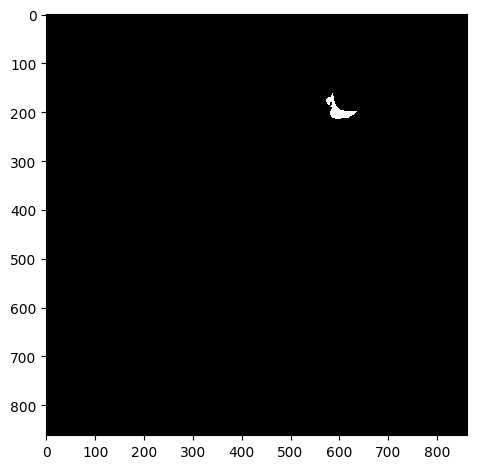

C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\3987185336.py:138: RuntimeWarning: invalid value encountered in divide
  "Overlap_to_Inclusion_Area": np.array(overlap_areas)/np.array(total_inclusion_areas),


wt_PFF_no_HTRA1_Hoechst_20x_08.czi


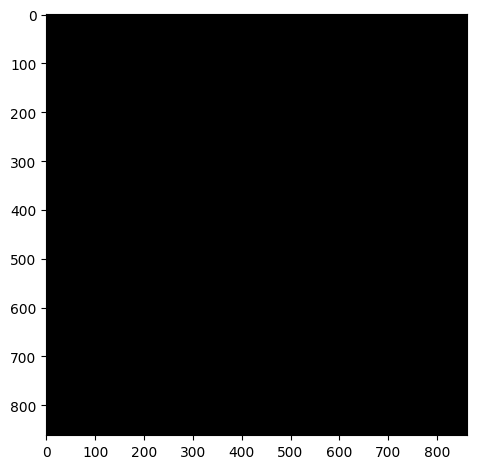

C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\2113827453.py:36: RuntimeWarning: invalid value encountered in scalar divide
  "Overlap_to_Inclusion_Area": [np.sum(overlap_areas) / np.sum(total_inclusion_areas)],
C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\2113827453.py:37: RuntimeWarning: invalid value encountered in scalar divide
  "Overlap_to_HTRA_Area": [np.sum(overlap_areas) / np.sum(htra_areas)],


wt_PFF_no_HTRA1_Hoechst_20x_09.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


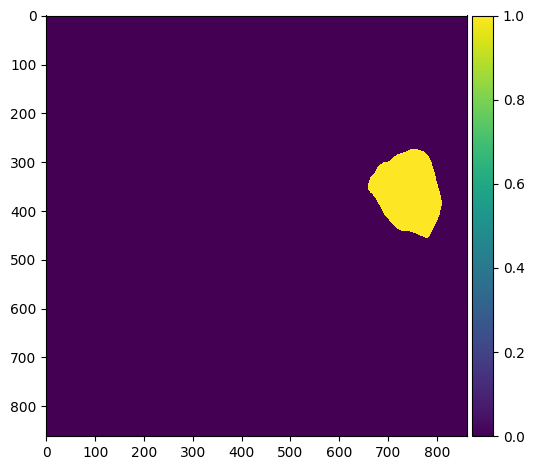

Cell:  0
Inclusion Area 1579.0
Max Inclusion Area: 1579.0
Cell Area: 18878.0
Ratio: 0.08364233499311367
Max Inclusion/Cell Area: 0.08364233499311367
Average Inclusion/Cell Area 0.08364233499311367


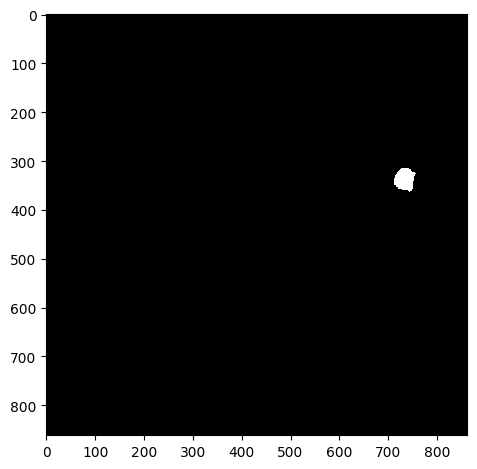

wt_PFF_no_HTRA1_Hoechst_20x_10.czi


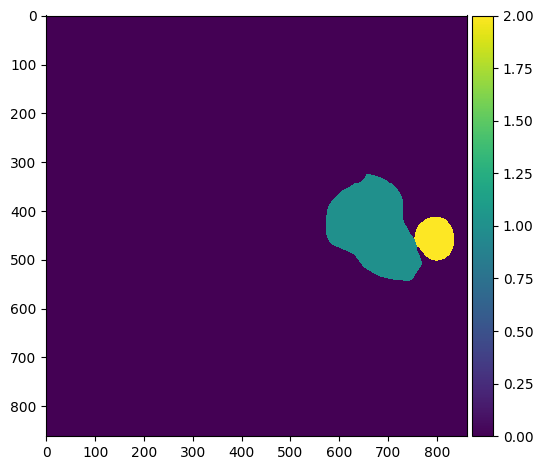

Cell:  0
Inclusion Area 560.0
Max Inclusion Area: 263.0
Cell Area: 28091.0
Ratio: 0.0199352105656616
Max Inclusion/Cell Area: 0.009362429247801786
Average Inclusion/Cell Area 0.0049838026414154


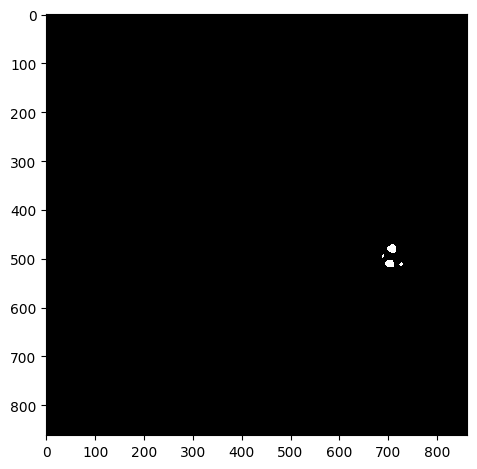

1K_PFF_HTRA1_Hoechst_20x_01.czi


C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\2113827453.py:37: RuntimeWarning: invalid value encountered in scalar divide
  "Overlap_to_HTRA_Area": [np.sum(overlap_areas) / np.sum(htra_areas)],
C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\3987185336.py:138: RuntimeWarning: invalid value encountered in divide
  "Overlap_to_Inclusion_Area": np.array(overlap_areas)/np.array(total_inclusion_areas),
C:\Users\yh1024\AppData\Local\Temp\ipykernel_8340\3987185336.py:139: RuntimeWarning: invalid value encountered in divide
  "Overlap_to_HTRA_Area": np.array(overlap_areas)/np.array(htra_areas)


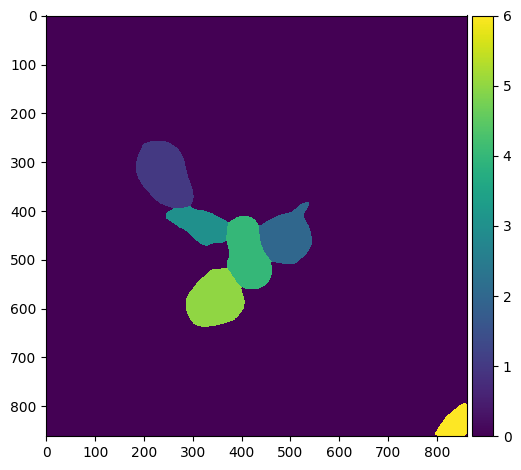

Cell:  1
Inclusion Area 2115.0
Max Inclusion Area: 639.0
Cell Area: 9419.0
Ratio: 0.22454613016243763
Max Inclusion/Cell Area: 0.06784159677248115
Average Inclusion/Cell Area 0.014969742010829176


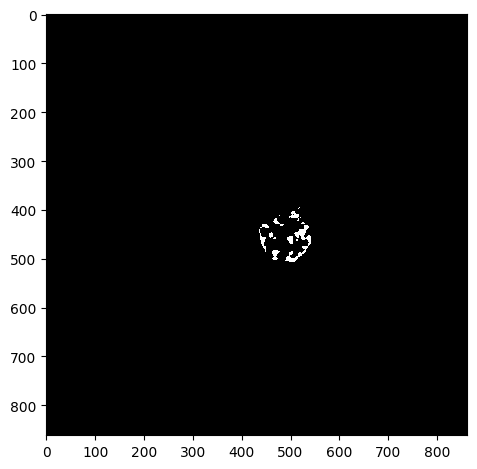

Cell:  2
Inclusion Area 709.0
Max Inclusion Area: 367.0
Cell Area: 6308.0
Ratio: 0.11239695624603678
Max Inclusion/Cell Area: 0.05818008877615726
Average Inclusion/Cell Area 0.012488550694004086


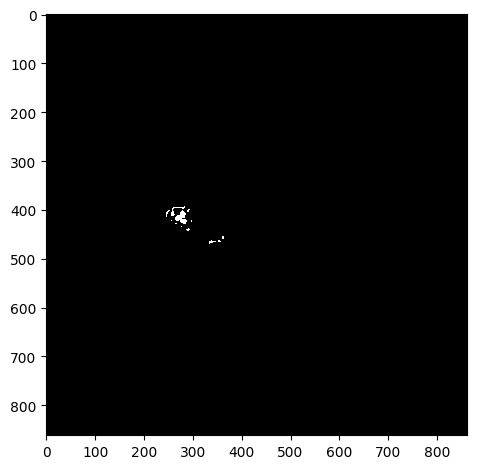

Cell:  3
Inclusion Area 2780.0
Max Inclusion Area: 876.0
Cell Area: 10458.0
Ratio: 0.2658252055842417
Max Inclusion/Cell Area: 0.08376362593230063
Average Inclusion/Cell Area 0.016614075349015107


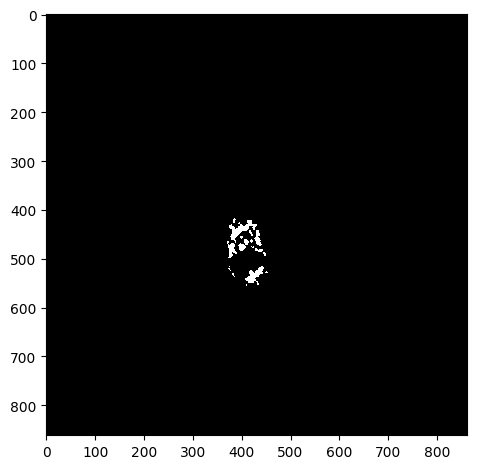

1K_PFF_HTRA1_Hoechst_20x_02.czi


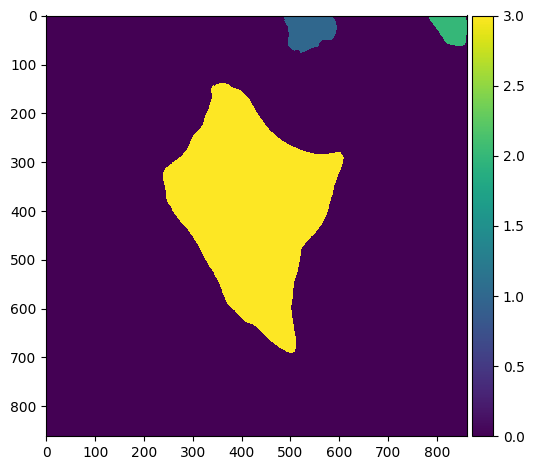

Cell:  2
Inclusion Area 19903.0
Max Inclusion Area: 5051.0
Cell Area: 105737.0
Ratio: 0.18823117735513586
Max Inclusion/Cell Area: 0.04776946574992671
Average Inclusion/Cell Area 0.001298146050725075


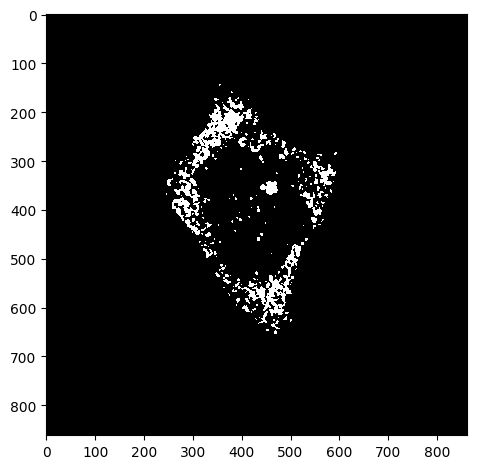

1K_PFF_HTRA1_Hoechst_20x_03.czi


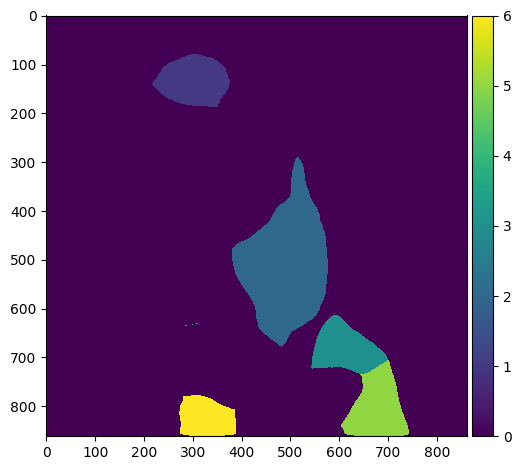

Cell:  1
Inclusion Area 5840.0
Max Inclusion Area: 2798.0
Cell Area: 42169.0
Ratio: 0.1384903602172212
Max Inclusion/Cell Area: 0.06635205956982618
Average Inclusion/Cell Area 0.002613025664475871


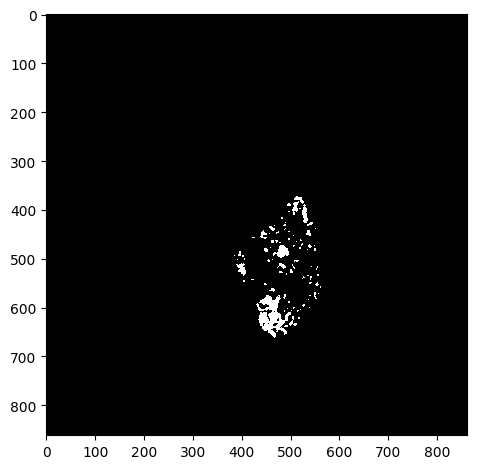

1K_PFF_HTRA1_Hoechst_20x_04.czi


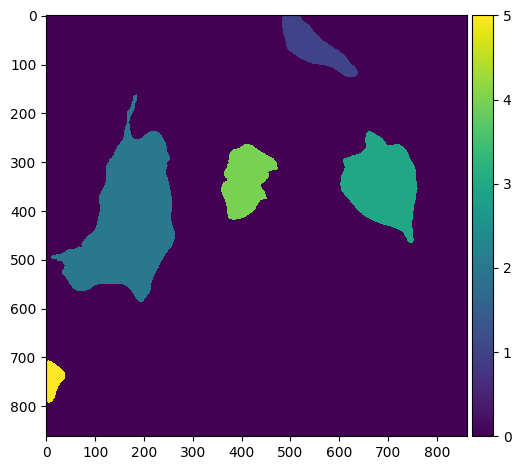

Cell:  0
Inclusion Area 1950.0
Max Inclusion Area: 1889.0
Cell Area: 8501.0
Ratio: 0.229384778261381
Max Inclusion/Cell Area: 0.22220915186448653
Average Inclusion/Cell Area 0.05734619456534525


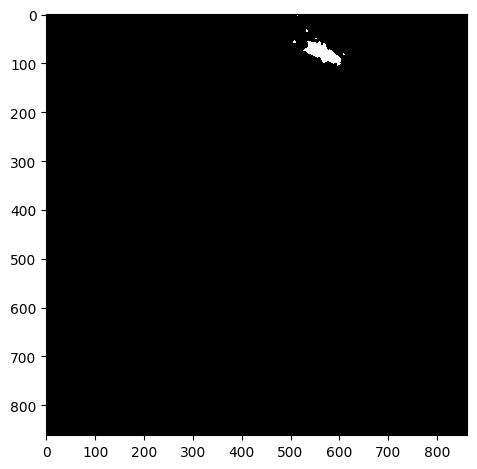

Cell:  3
Inclusion Area 149.0
Max Inclusion Area: 119.0
Cell Area: 11428.0
Ratio: 0.01303815190759538
Max Inclusion/Cell Area: 0.010413020651032551
Average Inclusion/Cell Area 0.00651907595379769


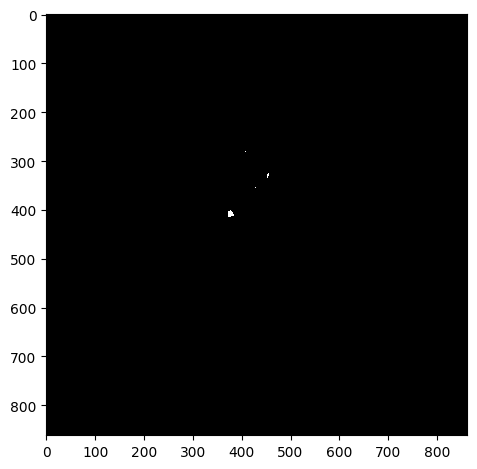

1K_PFF_HTRA1_Hoechst_20x_05.czi


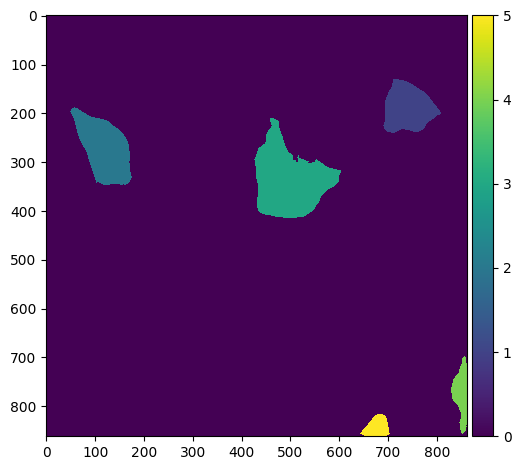

Cell:  1
Inclusion Area 239.0
Max Inclusion Area: 186.0
Cell Area: 11766.0
Ratio: 0.020312765595784463
Max Inclusion/Cell Area: 0.01580826109127996
Average Inclusion/Cell Area 0.006770921865261488


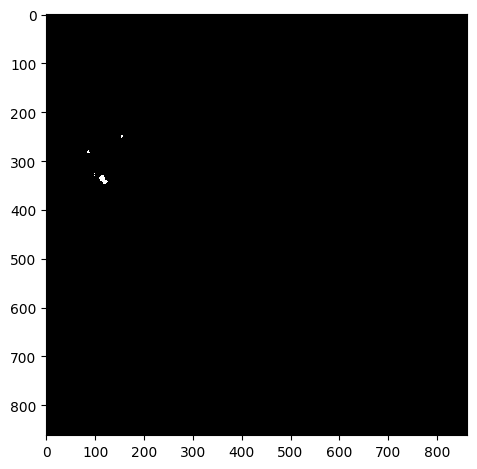

1K_PFF_HTRA1_Hoechst_20x_06.czi


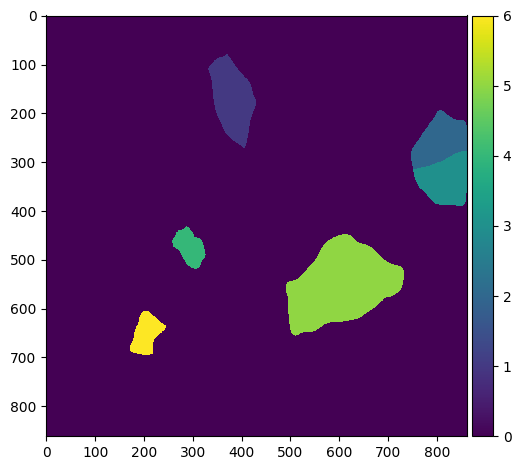

Cell:  2
Inclusion Area 963.0
Max Inclusion Area: 385.0
Cell Area: 8699.0
Ratio: 0.11070237958386021
Max Inclusion/Cell Area: 0.044257960685136224
Average Inclusion/Cell Area 0.009225198298655018


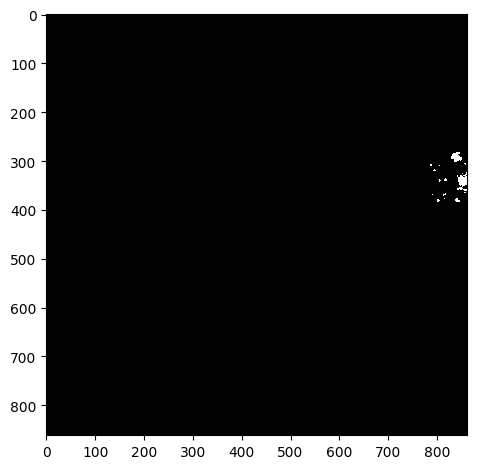

Cell:  3
Inclusion Area 402.0
Max Inclusion Area: 120.0
Cell Area: 3573.0
Ratio: 0.11251049538203191
Max Inclusion/Cell Area: 0.033585222502099076
Average Inclusion/Cell Area 0.0125011661535591


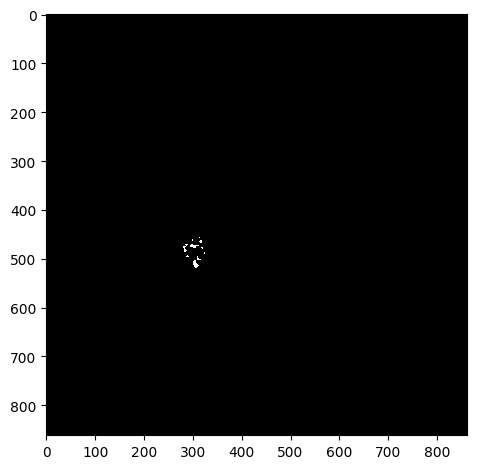

1K_PFF_HTRA1_Hoechst_20x_07.czi


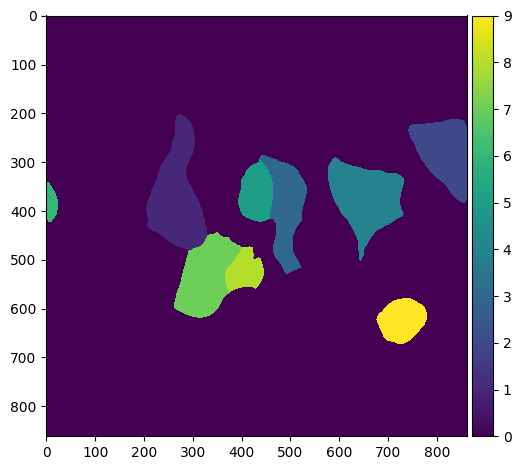

Cell:  4
Inclusion Area 1036.0
Max Inclusion Area: 233.0
Cell Area: 6849.0
Ratio: 0.15126295809607243
Max Inclusion/Cell Area: 0.0340195648999854
Average Inclusion/Cell Area 0.010804497006862316


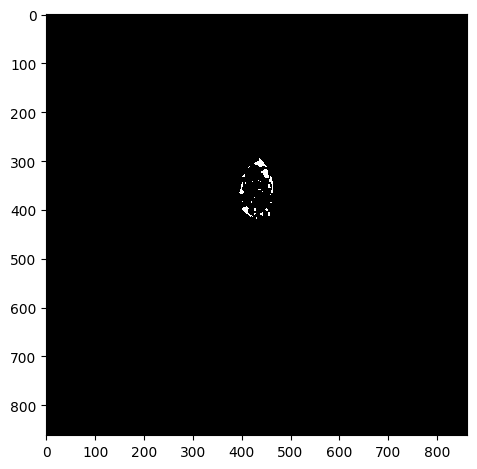

Cell:  5
Inclusion Area 126.0
Max Inclusion Area: 112.0
Cell Area: 1521.0
Ratio: 0.08284023668639054
Max Inclusion/Cell Area: 0.07363576594345825
Average Inclusion/Cell Area 0.04142011834319527


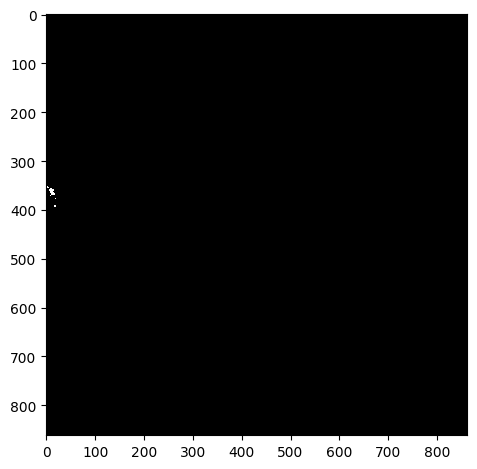

1K_PFF_HTRA1_Hoechst_20x_08.czi


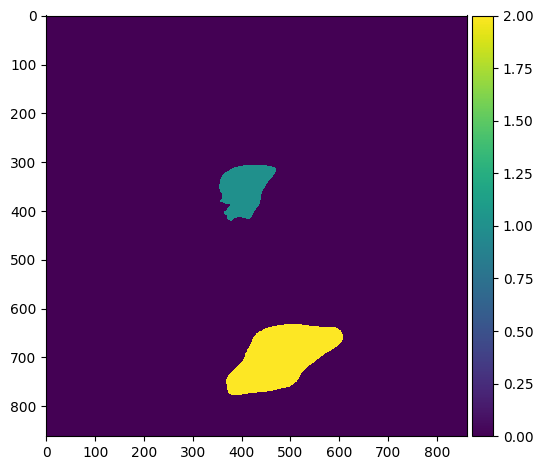

Cell:  0
Inclusion Area 37.0
Max Inclusion Area: 37.0
Cell Area: 8816.0
Ratio: 0.004196914700544465
Max Inclusion/Cell Area: 0.004196914700544465
Average Inclusion/Cell Area 0.004196914700544465


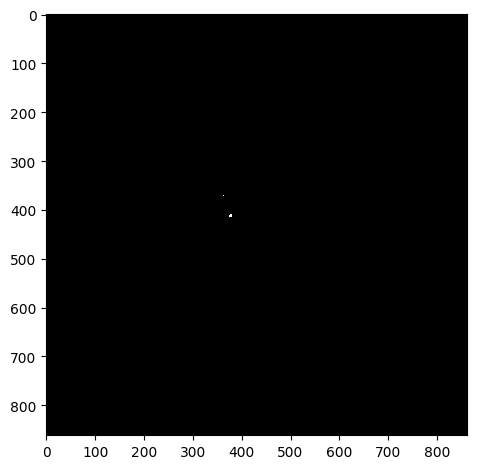

Cell:  1
Inclusion Area 1894.0
Max Inclusion Area: 437.0
Cell Area: 21266.0
Ratio: 0.08906235305181981
Max Inclusion/Cell Area: 0.02054923351829211
Average Inclusion/Cell Area 0.0021722525134590196


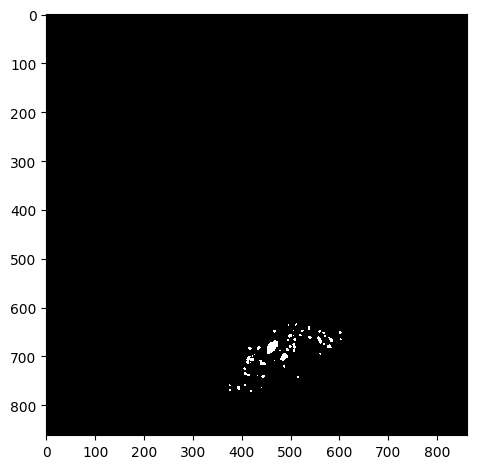

1K_PFF_HTRA1_Hoechst_20x_09.czi


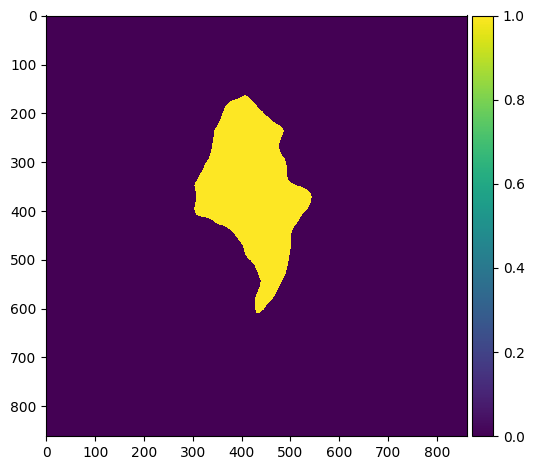

Cell:  0
Inclusion Area 6904.0
Max Inclusion Area: 2914.0
Cell Area: 53877.0
Ratio: 0.12814373480334837
Max Inclusion/Cell Area: 0.054086159214507115
Average Inclusion/Cell Area 0.0036612495658099537


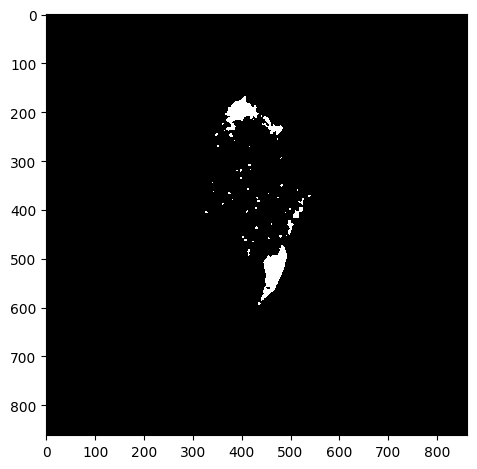

1K_PFF_HTRA1_Hoechst_20x_10.czi


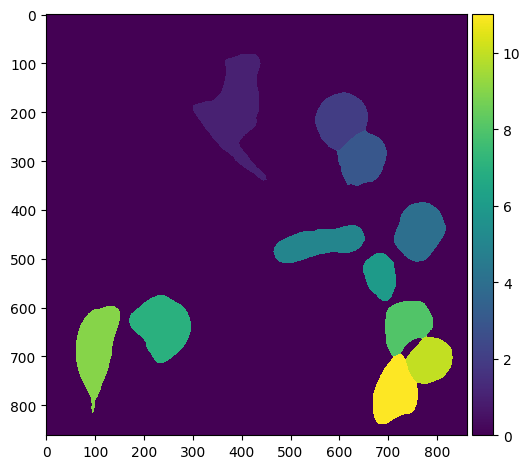

Cell:  1
Inclusion Area 76.0
Max Inclusion Area: 76.0
Cell Area: 9173.0
Ratio: 0.008285184781423744
Max Inclusion/Cell Area: 0.008285184781423744
Average Inclusion/Cell Area 0.008285184781423744


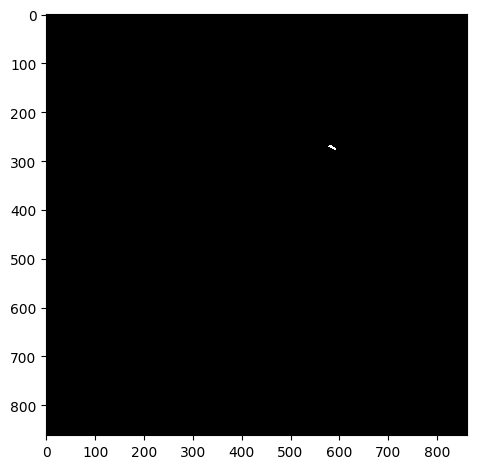

Cell:  2
Inclusion Area 313.0
Max Inclusion Area: 176.0
Cell Area: 8362.0
Ratio: 0.03743123654628079
Max Inclusion/Cell Area: 0.021047596268835206
Average Inclusion/Cell Area 0.018715618273140396


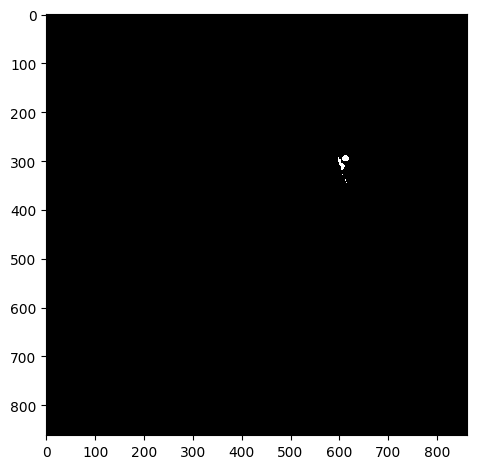

Cell:  6
Inclusion Area 2932.0
Max Inclusion Area: 935.0
Cell Area: 11738.0
Ratio: 0.24978701652751747
Max Inclusion/Cell Area: 0.07965581870846822
Average Inclusion/Cell Area 0.016652467768501166


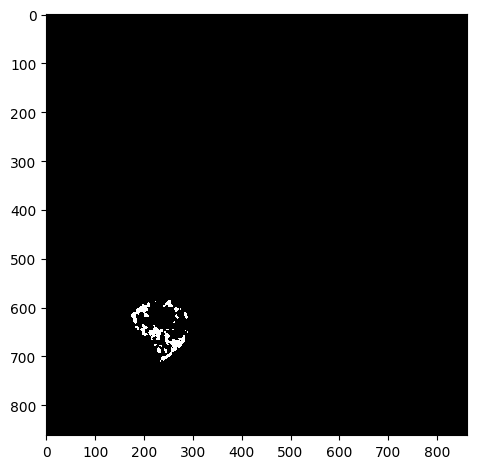

Cell:  10
Inclusion Area 147.0
Max Inclusion Area: 147.0
Cell Area: 9235.0
Ratio: 0.015917704385489985
Max Inclusion/Cell Area: 0.015917704385489985
Average Inclusion/Cell Area 0.015917704385489985


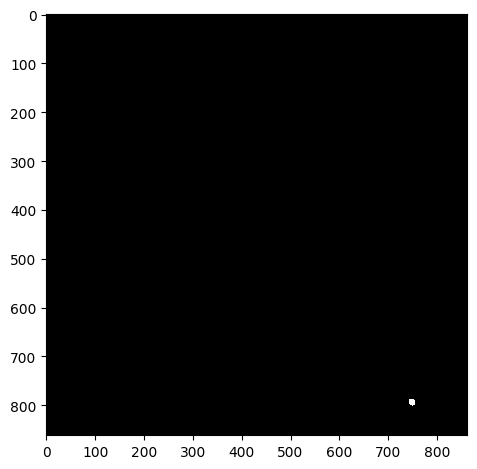

1K_PFF_noHTRA1_Hoechst_20x_01.czi


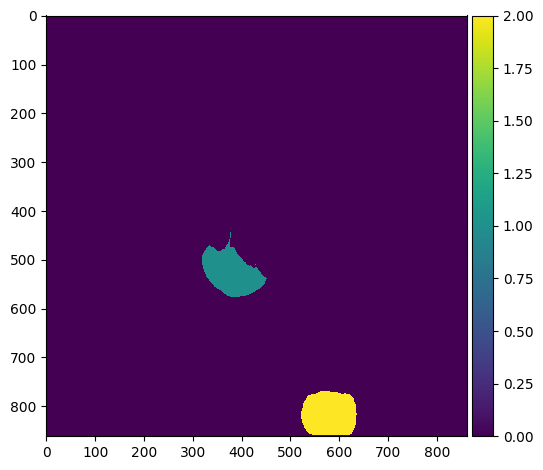

Cell:  0
Inclusion Area 254.0
Max Inclusion Area: 91.0
Cell Area: 9053.0
Ratio: 0.028056997680326965
Max Inclusion/Cell Area: 0.010051916491770684
Average Inclusion/Cell Area 0.004008142525760995


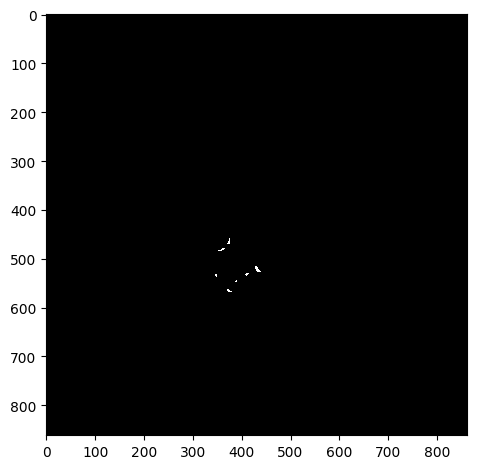

1K_PFF_noHTRA1_Hoechst_20x_02.czi


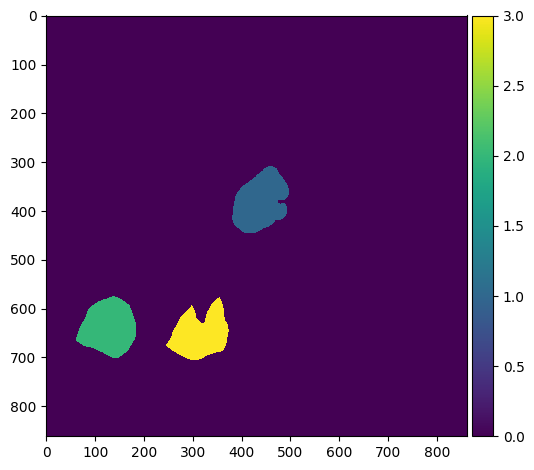

Cell:  0
Inclusion Area 259.0
Max Inclusion Area: 259.0
Cell Area: 11082.0
Ratio: 0.02337123262948926
Max Inclusion/Cell Area: 0.02337123262948926
Average Inclusion/Cell Area 0.02337123262948926


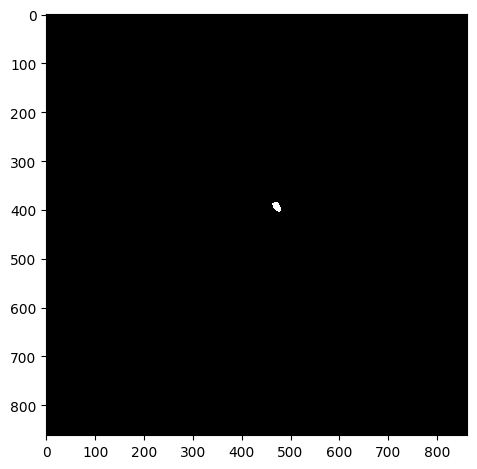

Cell:  2
Inclusion Area 283.0
Max Inclusion Area: 283.0
Cell Area: 10026.0
Ratio: 0.02822661081188909
Max Inclusion/Cell Area: 0.02822661081188909
Average Inclusion/Cell Area 0.02822661081188909


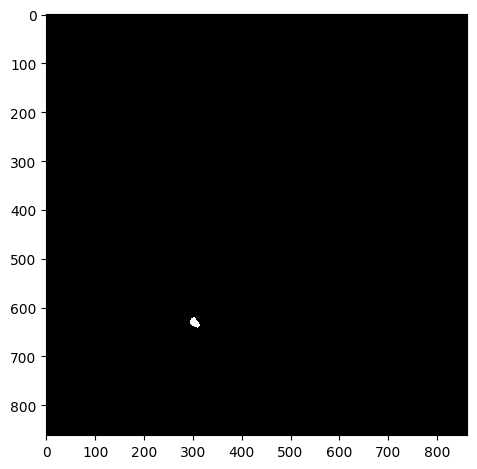

1K_PFF_noHTRA1_Hoechst_20x_03.czi


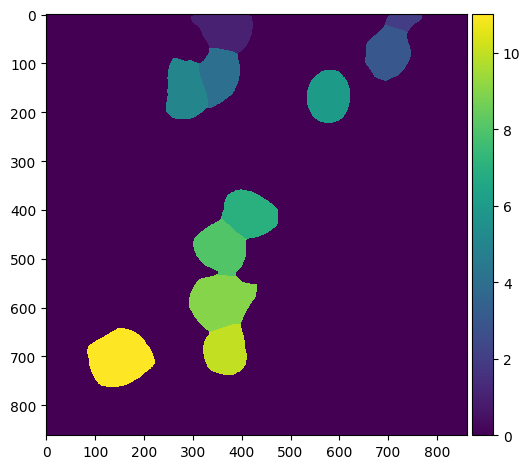

Cell:  0
Inclusion Area 1392.0
Max Inclusion Area: 609.0
Cell Area: 7411.0
Ratio: 0.1878289029820537
Max Inclusion/Cell Area: 0.0821751450546485
Average Inclusion/Cell Area 0.020869878109117078


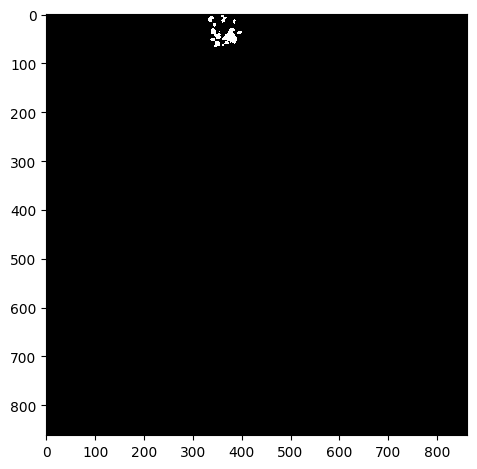

Cell:  4
Inclusion Area 269.0
Max Inclusion Area: 269.0
Cell Area: 8558.0
Ratio: 0.031432577705071275
Max Inclusion/Cell Area: 0.031432577705071275
Average Inclusion/Cell Area 0.031432577705071275


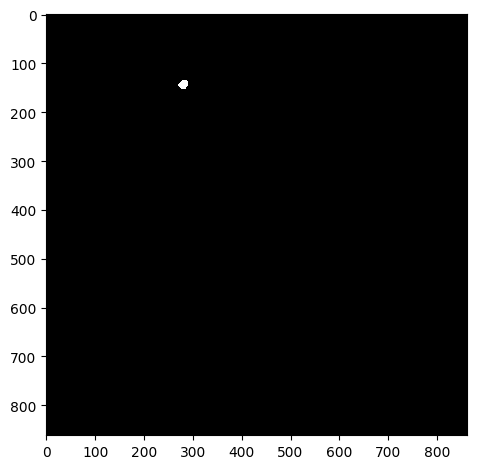

Cell:  9
Inclusion Area 353.0
Max Inclusion Area: 353.0
Cell Area: 7489.0
Ratio: 0.04713579917211911
Max Inclusion/Cell Area: 0.04713579917211911
Average Inclusion/Cell Area 0.04713579917211911


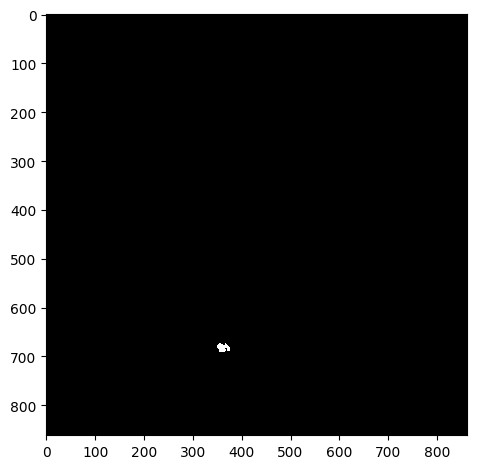

1K_PFF_noHTRA1_Hoechst_20x_04.czi


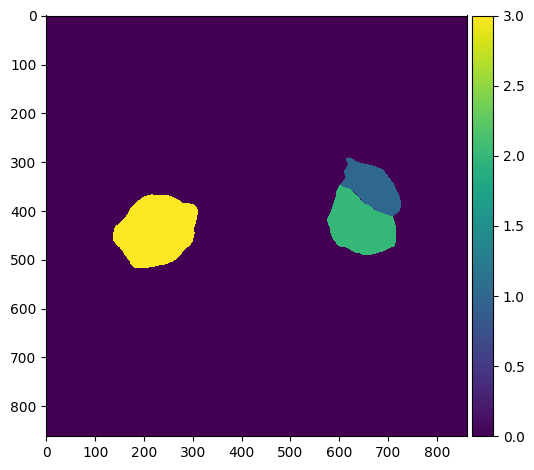

Cell:  0
Inclusion Area 133.0
Max Inclusion Area: 99.0
Cell Area: 8392.0
Ratio: 0.01584842707340324
Max Inclusion/Cell Area: 0.011796949475691135
Average Inclusion/Cell Area 0.00792421353670162


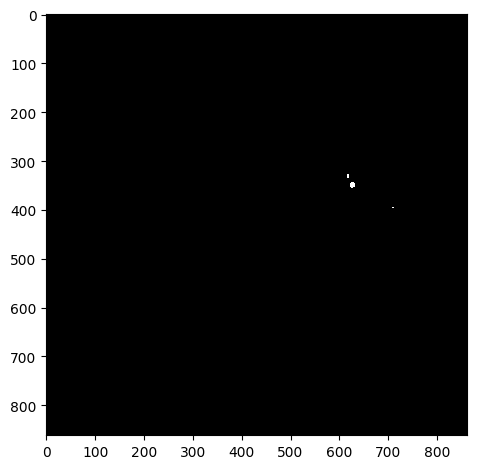

Cell:  1
Inclusion Area 209.0
Max Inclusion Area: 175.0
Cell Area: 13168.0
Ratio: 0.015871810449574728
Max Inclusion/Cell Area: 0.013289793438639124
Average Inclusion/Cell Area 0.007935905224787364


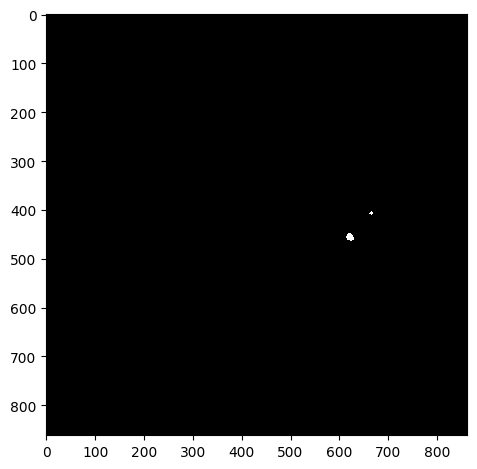

Cell:  2
Inclusion Area 3144.0
Max Inclusion Area: 942.0
Cell Area: 19155.0
Ratio: 0.16413469068128425
Max Inclusion/Cell Area: 0.04917776037588097
Average Inclusion/Cell Area 0.007815937651489727


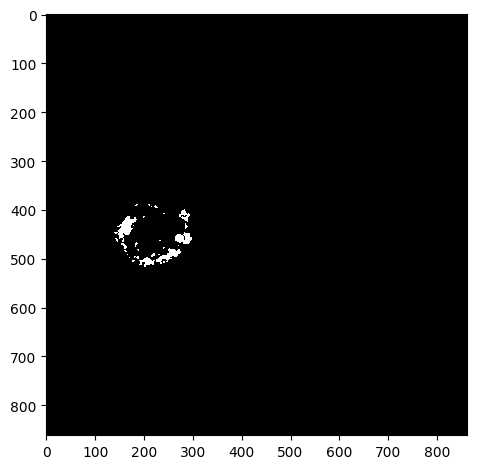

1K_PFF_noHTRA1_Hoechst_20x_05.czi


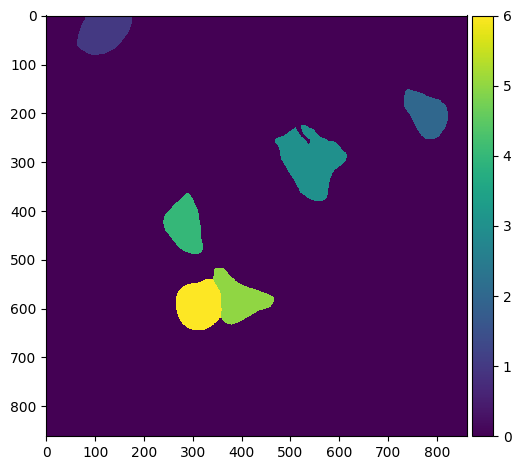

Cell:  2
Inclusion Area 361.0
Max Inclusion Area: 361.0
Cell Area: 13223.0
Ratio: 0.027300915072222643
Max Inclusion/Cell Area: 0.027300915072222643
Average Inclusion/Cell Area 0.027300915072222643


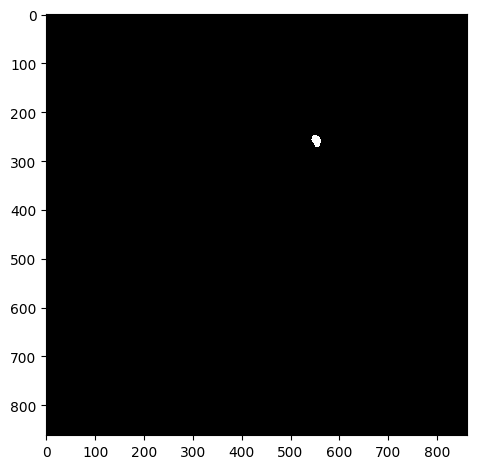

1K_PFF_noHTRA1_Hoechst_20x_06.czi


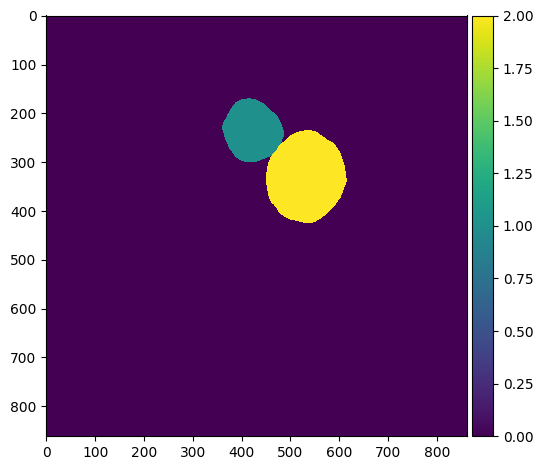

Cell:  1
Inclusion Area 513.0
Max Inclusion Area: 179.0
Cell Area: 23838.0
Ratio: 0.021520261766926757
Max Inclusion/Cell Area: 0.007509019213021227
Average Inclusion/Cell Area 0.0043040523533853505


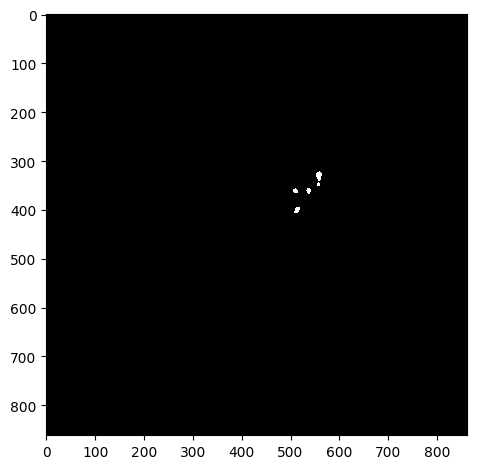

1K_PFF_noHTRA1_Hoechst_20x_07.czi


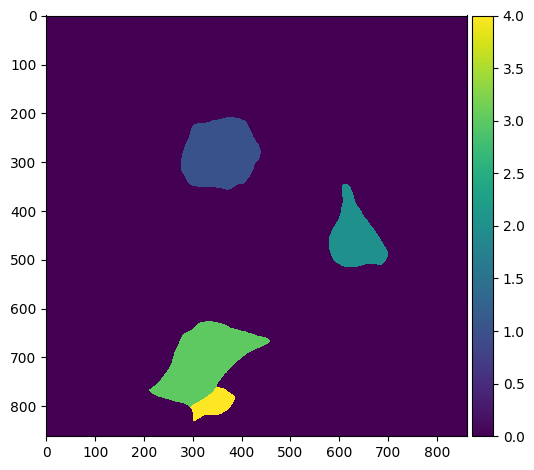

Cell:  0
Inclusion Area 162.0
Max Inclusion Area: 100.0
Cell Area: 18891.0
Ratio: 0.00857551214864221
Max Inclusion/Cell Area: 0.005293526017680377
Average Inclusion/Cell Area 0.0021438780371605525


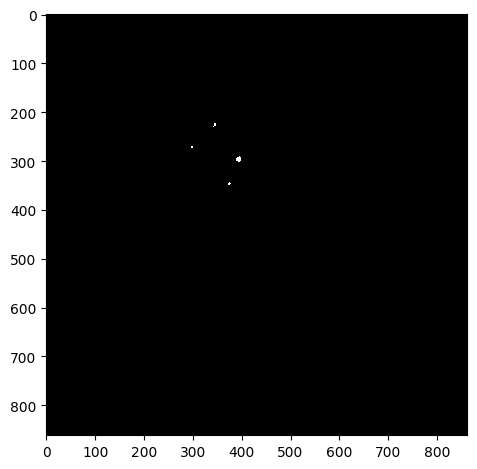

1K_PFF_noHTRA1_Hoechst_20x_08.czi


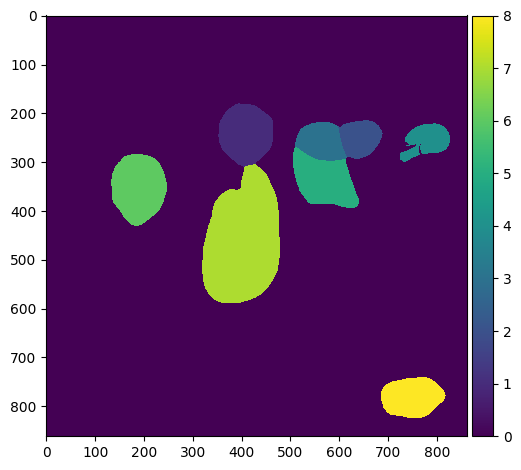

Cell:  0
Inclusion Area 2451.0
Max Inclusion Area: 909.0
Cell Area: 11201.0
Ratio: 0.21881974823676456
Max Inclusion/Cell Area: 0.08115346844031783
Average Inclusion/Cell Area 0.014587983215784306


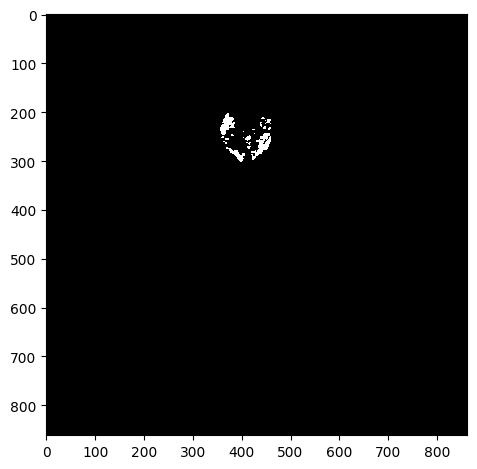

Cell:  2
Inclusion Area 1838.0
Max Inclusion Area: 1307.0
Cell Area: 6230.0
Ratio: 0.295024077046549
Max Inclusion/Cell Area: 0.20979133226324237
Average Inclusion/Cell Area 0.02269415977281146


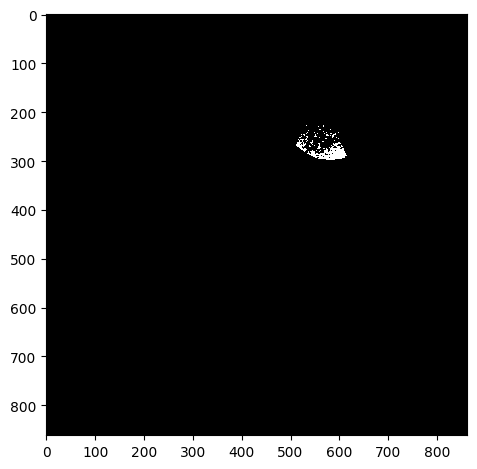

1K_PFF_noHTRA1_Hoechst_20x_09.czi


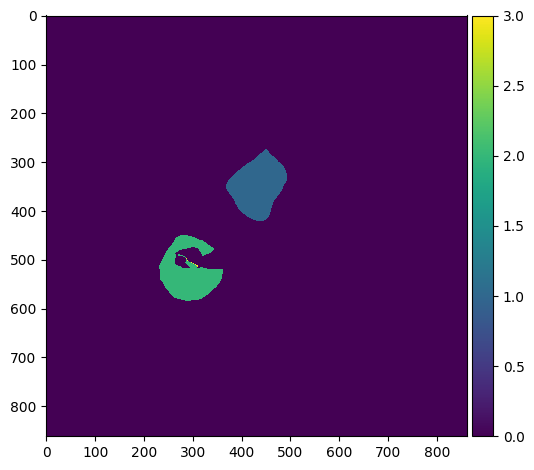

Cell:  0
Inclusion Area 1906.0
Max Inclusion Area: 1741.0
Cell Area: 11236.0
Ratio: 0.16963332146671414
Max Inclusion/Cell Area: 0.15494838020647916
Average Inclusion/Cell Area 0.02423333163810202


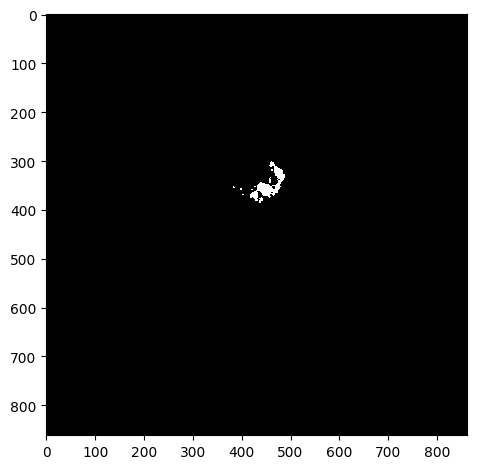

Cell:  1
Inclusion Area 32.0
Max Inclusion Area: 32.0
Cell Area: 10189.0
Ratio: 0.003140641868681912
Max Inclusion/Cell Area: 0.003140641868681912
Average Inclusion/Cell Area 0.003140641868681912


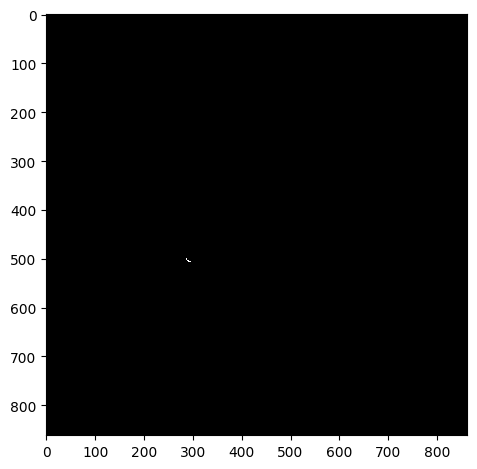

1K_PFF_noHTRA1_Hoechst_20x_10.czi


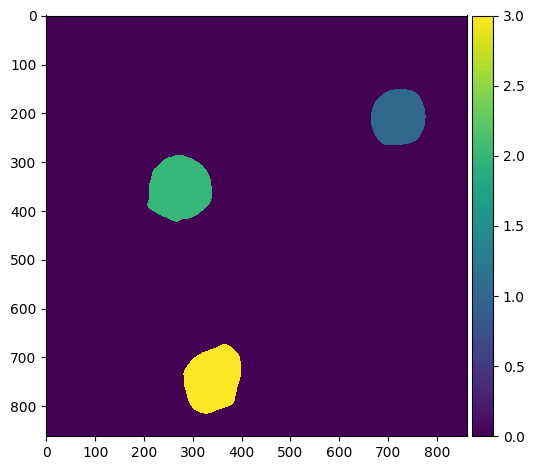

Cell:  1
Inclusion Area 2337.0
Max Inclusion Area: 595.0
Cell Area: 13843.0
Ratio: 0.16882178718485877
Max Inclusion/Cell Area: 0.04298201256952973
Average Inclusion/Cell Area 0.007673717599311763


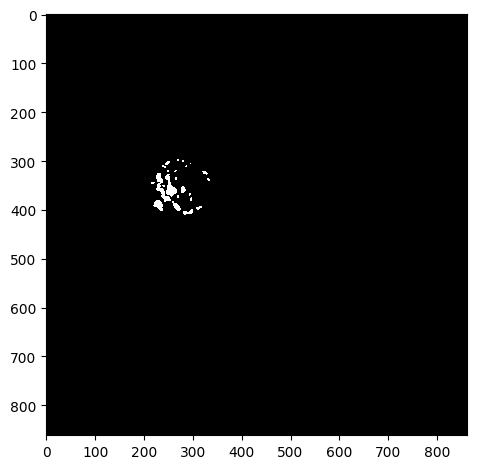

WT_PFF_HTRA1_Hoechst_20x_01.czi


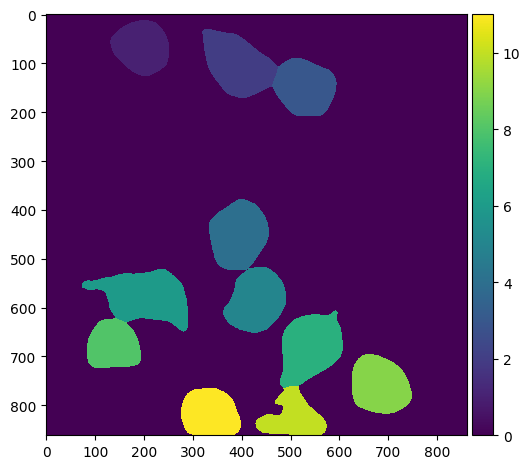

Cell:  0
Inclusion Area 239.0
Max Inclusion Area: 239.0
Cell Area: 10315.0
Ratio: 0.02317014057198255
Max Inclusion/Cell Area: 0.02317014057198255
Average Inclusion/Cell Area 0.02317014057198255


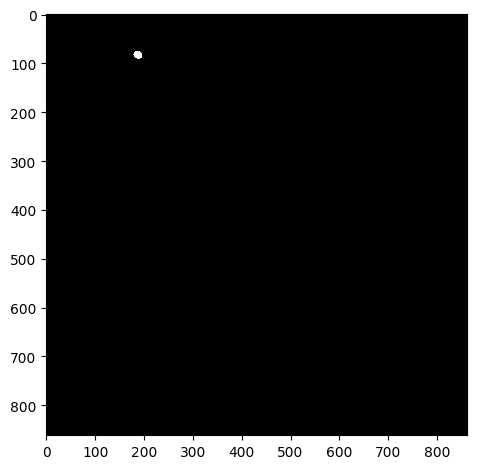

Cell:  5
Inclusion Area 1156.0
Max Inclusion Area: 603.0
Cell Area: 16608.0
Ratio: 0.06960500963391136
Max Inclusion/Cell Area: 0.03630780346820809
Average Inclusion/Cell Area 0.007733889959323486


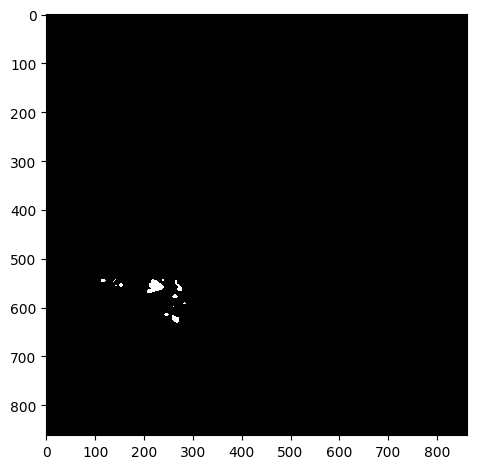

Cell:  9
Inclusion Area 363.0
Max Inclusion Area: 347.0
Cell Area: 8585.0
Ratio: 0.04228305183459522
Max Inclusion/Cell Area: 0.04041933605125218
Average Inclusion/Cell Area 0.02114152591729761


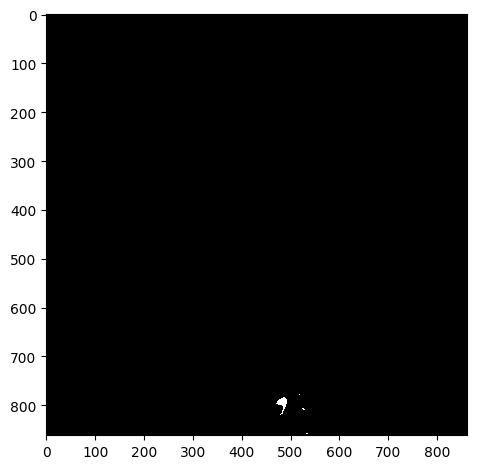

WT_PFF_HTRA1_Hoechst_20x_02.czi


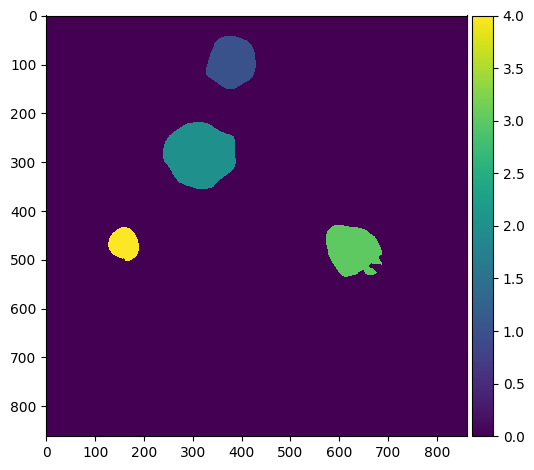

Cell:  1
Inclusion Area 2215.0
Max Inclusion Area: 507.0
Cell Area: 15565.0
Ratio: 0.1423064567940893
Max Inclusion/Cell Area: 0.03257308062961773
Average Inclusion/Cell Area 0.009487097119605954


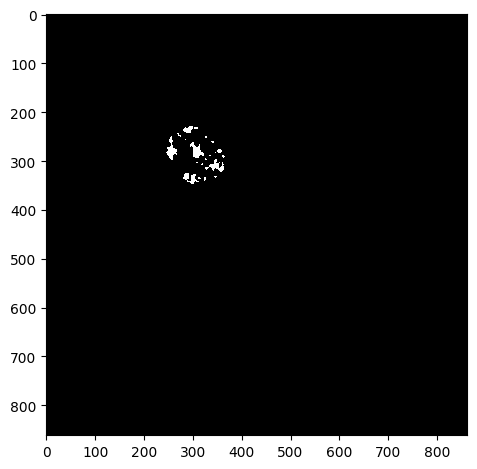

Cell:  2
Inclusion Area 455.0
Max Inclusion Area: 332.0
Cell Area: 9169.0
Ratio: 0.049623732140909586
Max Inclusion/Cell Area: 0.036208964990729633
Average Inclusion/Cell Area 0.012405933035227397


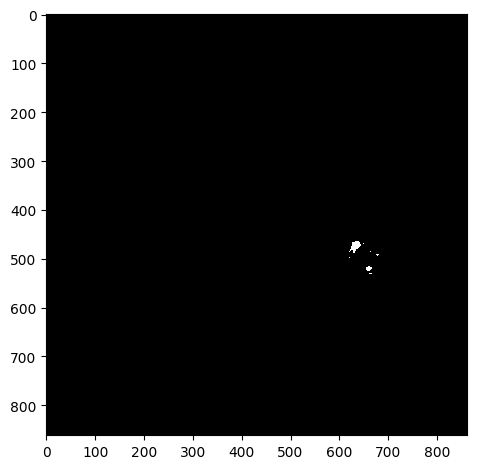

WT_PFF_HTRA1_Hoechst_20x_03.czi


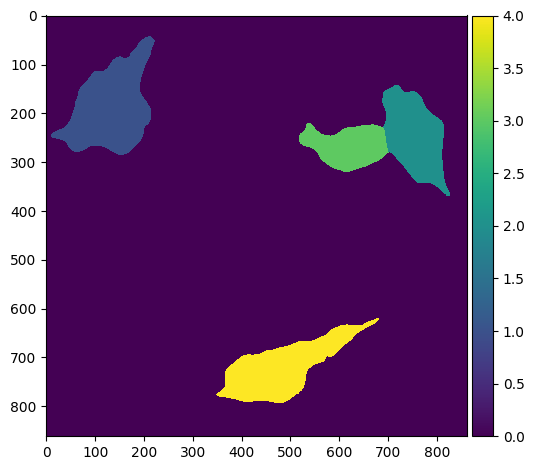

Cell:  0
Inclusion Area 1885.0
Max Inclusion Area: 589.0
Cell Area: 27040.0
Ratio: 0.06971153846153846
Max Inclusion/Cell Area: 0.021782544378698226
Average Inclusion/Cell Area 0.002681213017751479


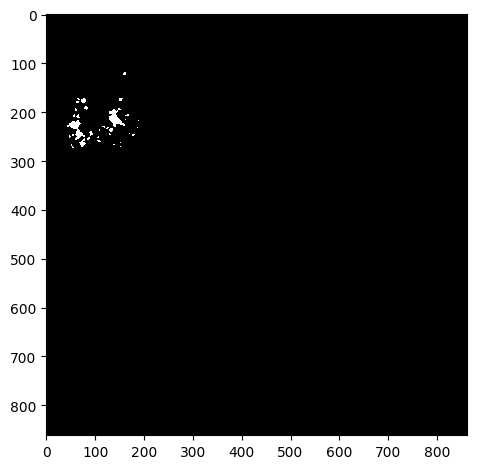

Cell:  3
Inclusion Area 2633.0
Max Inclusion Area: 718.0
Cell Area: 21857.0
Ratio: 0.12046483963947477
Max Inclusion/Cell Area: 0.0328498879077641
Average Inclusion/Cell Area 0.006692491091081931


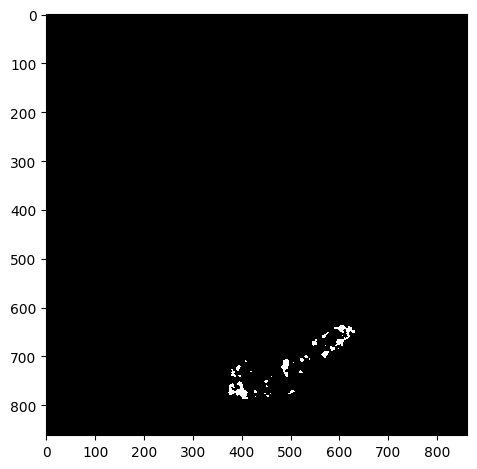

WT_PFF_HTRA1_Hoechst_20x_04.czi


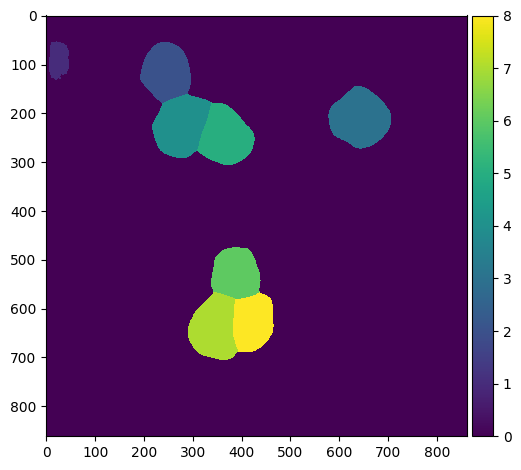

Cell:  2
Inclusion Area 2773.0
Max Inclusion Area: 2530.0
Cell Area: 11818.0
Ratio: 0.23464207141648333
Max Inclusion/Cell Area: 0.2140802166187172
Average Inclusion/Cell Area 0.03352029591664048


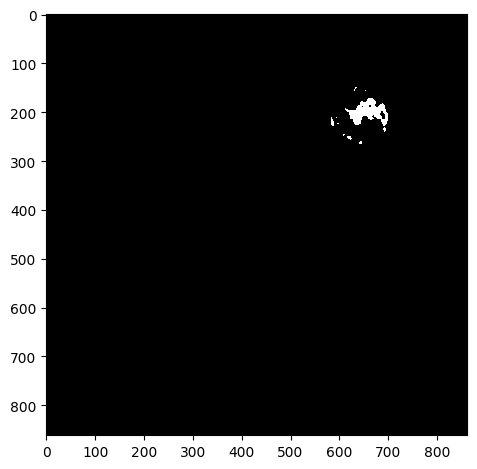

Cell:  4
Inclusion Area 1584.0
Max Inclusion Area: 523.0
Cell Area: 10364.0
Ratio: 0.1528367425704361
Max Inclusion/Cell Area: 0.05046314164415284
Average Inclusion/Cell Area 0.013894249324585103


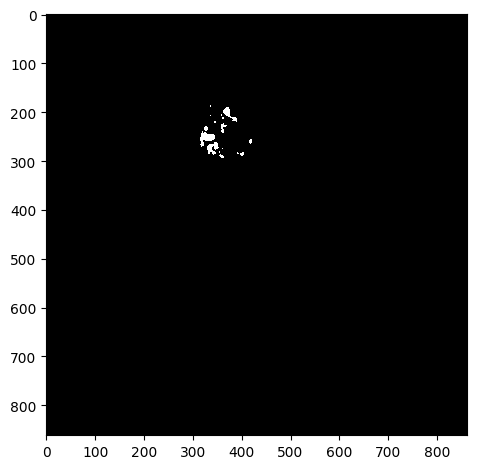

WT_PFF_HTRA1_Hoechst_20x_05.czi


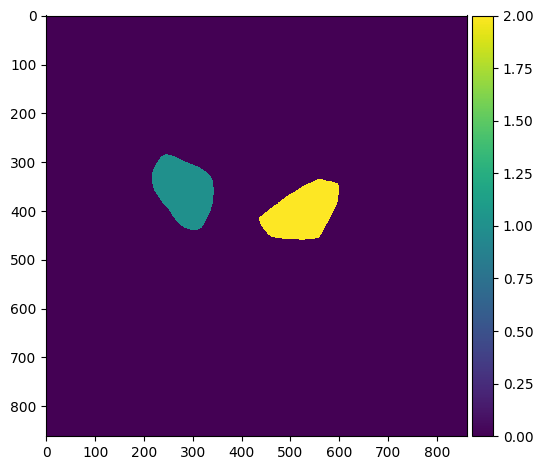

Cell:  1
Inclusion Area 1488.0
Max Inclusion Area: 562.0
Cell Area: 13478.0
Ratio: 0.11040213681555126
Max Inclusion/Cell Area: 0.04169758124350794
Average Inclusion/Cell Area 0.011040213681555128


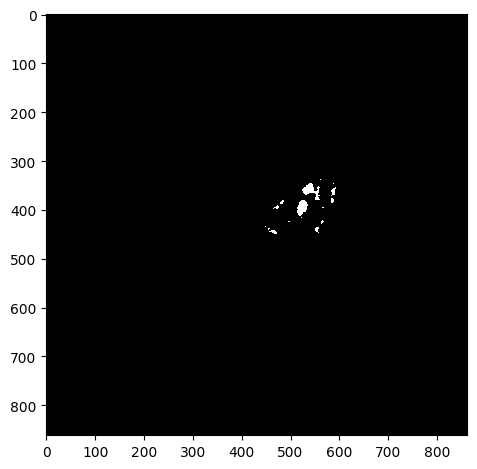

WT_PFF_HTRA1_Hoechst_20x_06.czi


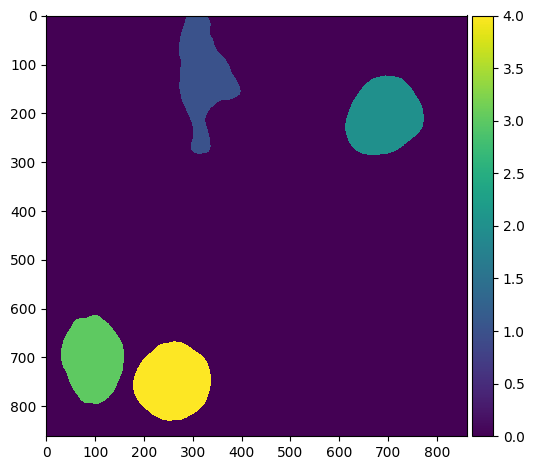

Cell:  0
Inclusion Area 1574.0
Max Inclusion Area: 546.0
Cell Area: 19534.0
Ratio: 0.08057745469437903
Max Inclusion/Cell Area: 0.027951264461963755
Average Inclusion/Cell Area 0.0073252231540344576


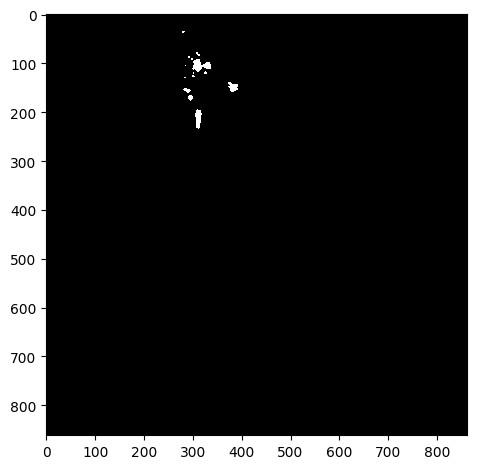

WT_PFF_HTRA1_Hoechst_20x_07.czi


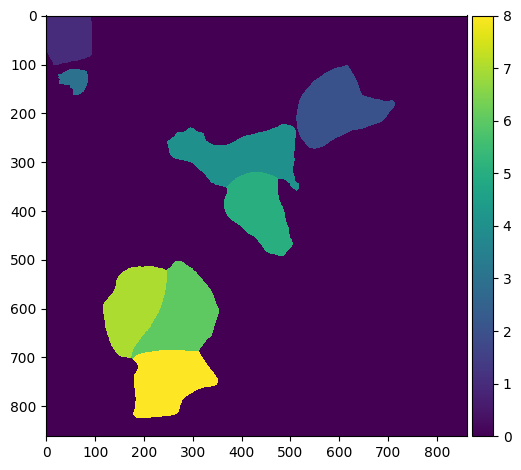

Cell:  1
Inclusion Area 1093.0
Max Inclusion Area: 376.0
Cell Area: 19758.0
Ratio: 0.05531936430812835
Max Inclusion/Cell Area: 0.01903026622127746
Average Inclusion/Cell Area 0.005029033118920759


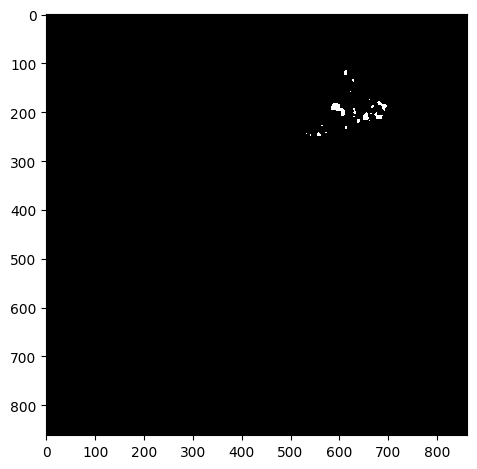

Cell:  4
Inclusion Area 1806.0
Max Inclusion Area: 1492.0
Cell Area: 15537.0
Ratio: 0.11623865611121838
Max Inclusion/Cell Area: 0.09602883439531441
Average Inclusion/Cell Area 0.016605522301602626


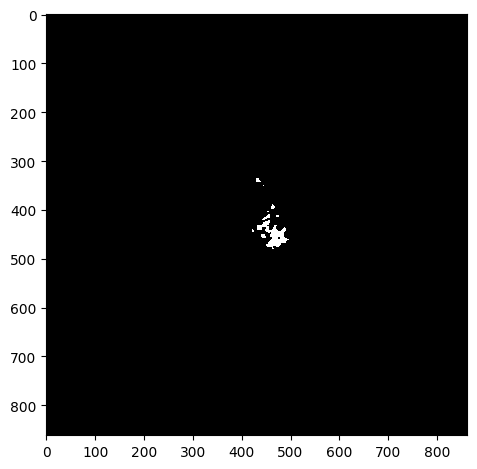

Cell:  6
Inclusion Area 3803.0
Max Inclusion Area: 3132.0
Cell Area: 16433.0
Ratio: 0.23142457250654172
Max Inclusion/Cell Area: 0.19059210125966045
Average Inclusion/Cell Area 0.014464035781658858


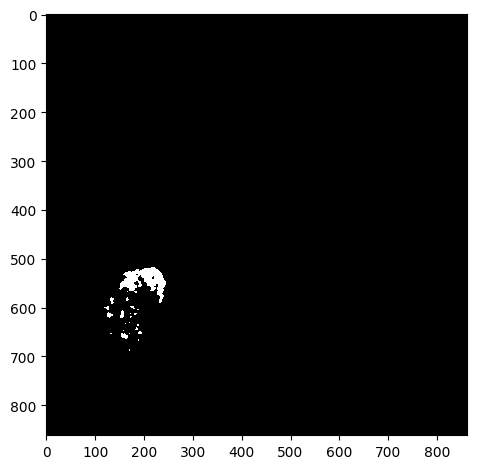

WT_PFF_HTRA1_Hoechst_20x_08.czi


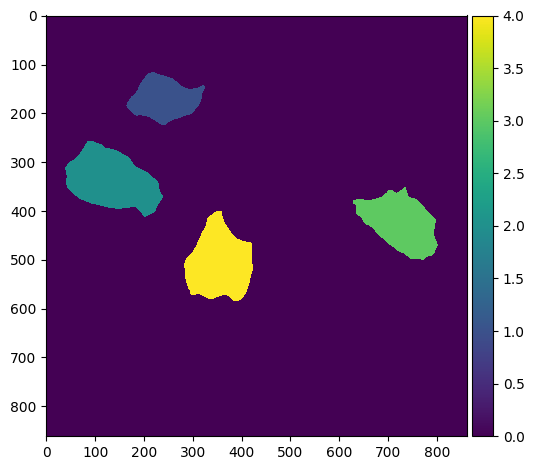

Cell:  2
Inclusion Area 121.0
Max Inclusion Area: 103.0
Cell Area: 15241.0
Ratio: 0.007939111606849944
Max Inclusion/Cell Area: 0.006758086739715242
Average Inclusion/Cell Area 0.003969555803424972


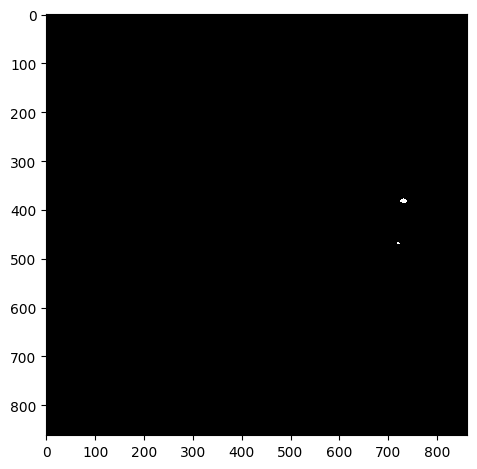

WT_PFF_HTRA1_Hoechst_20x_09.czi


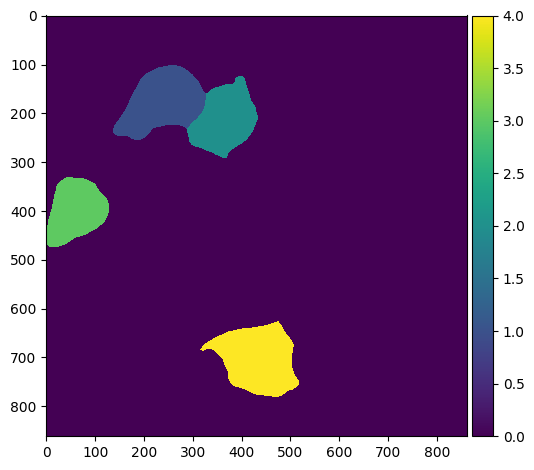

Cell:  1
Inclusion Area 720.0
Max Inclusion Area: 720.0
Cell Area: 15074.0
Ratio: 0.047764362478439695
Max Inclusion/Cell Area: 0.047764362478439695
Average Inclusion/Cell Area 0.047764362478439695


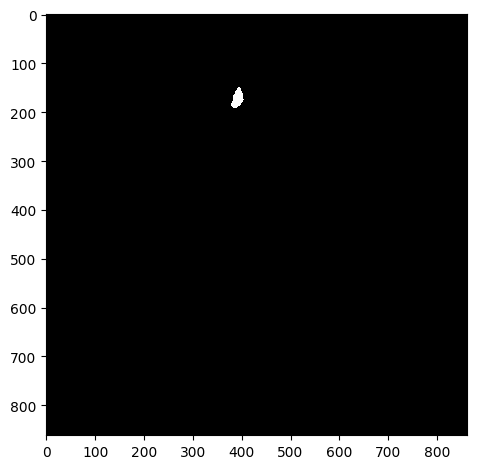

WT_PFF_HTRA1_Hoechst_20x_10.czi


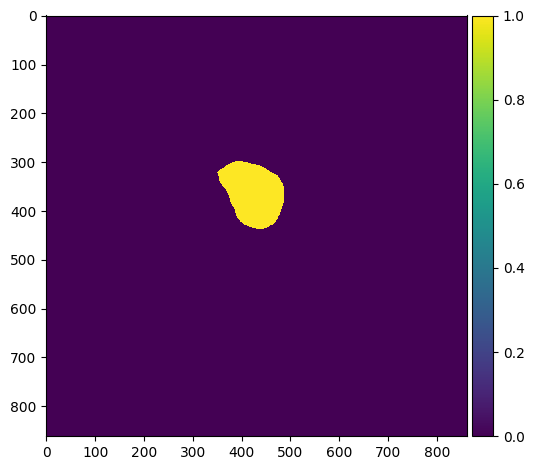

Cell:  0
Inclusion Area 2105.0
Max Inclusion Area: 1251.0
Cell Area: 13332.0
Ratio: 0.15789078907890788
Max Inclusion/Cell Area: 0.09383438343834384
Average Inclusion/Cell Area 0.026315131513151315


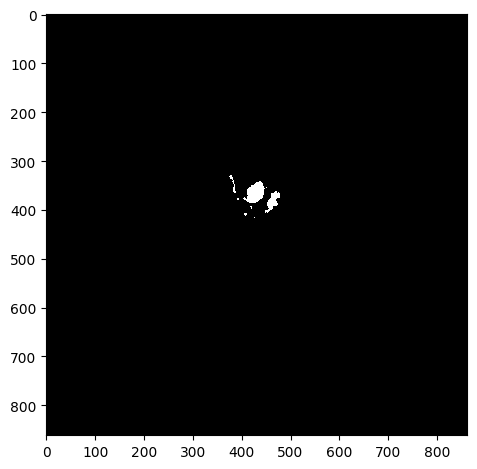

WT_PFF_noHTRA1_Hoechst_20x_01.czi


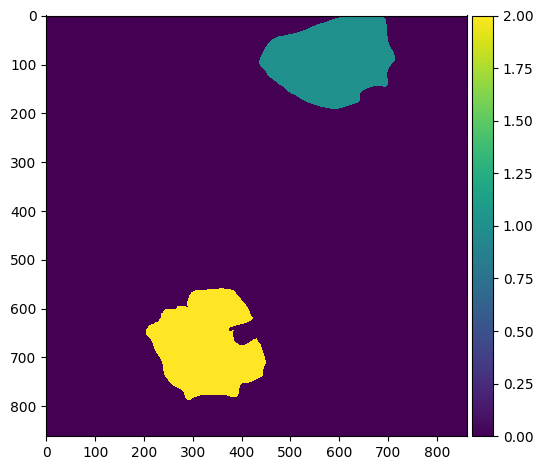

Cell:  0
Inclusion Area 6011.0
Max Inclusion Area: 4522.0
Cell Area: 37506.0
Ratio: 0.1602676905028529
Max Inclusion/Cell Area: 0.12056737588652482
Average Inclusion/Cell Area 0.00667782043761887


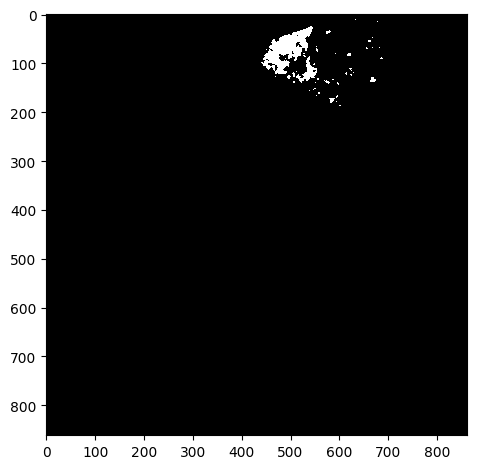

Cell:  1
Inclusion Area 73.0
Max Inclusion Area: 73.0
Cell Area: 37292.0
Ratio: 0.001957524402016518
Max Inclusion/Cell Area: 0.001957524402016518
Average Inclusion/Cell Area 0.001957524402016518


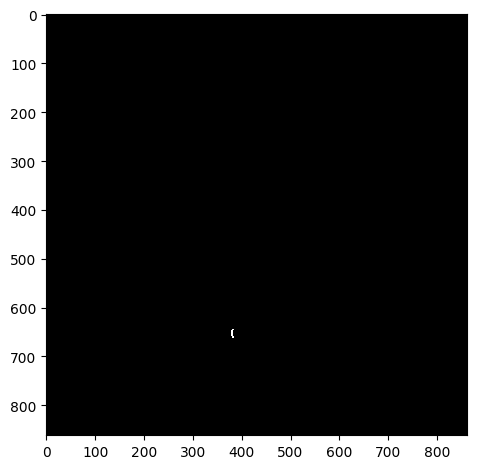

WT_PFF_noHTRA1_Hoechst_20x_02.czi


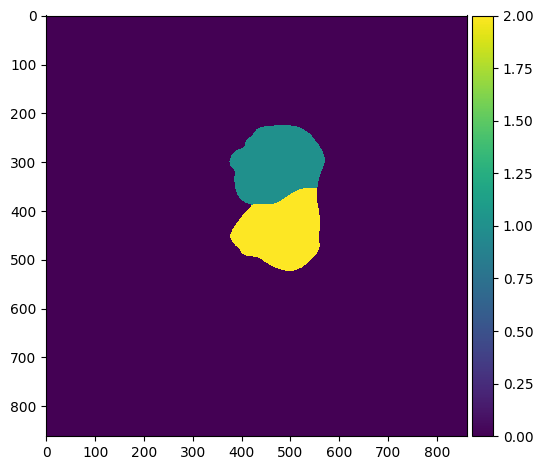

Cell:  0
Inclusion Area 277.0
Max Inclusion Area: 277.0
Cell Area: 23776.0
Ratio: 0.011650403768506056
Max Inclusion/Cell Area: 0.011650403768506056
Average Inclusion/Cell Area 0.011650403768506056


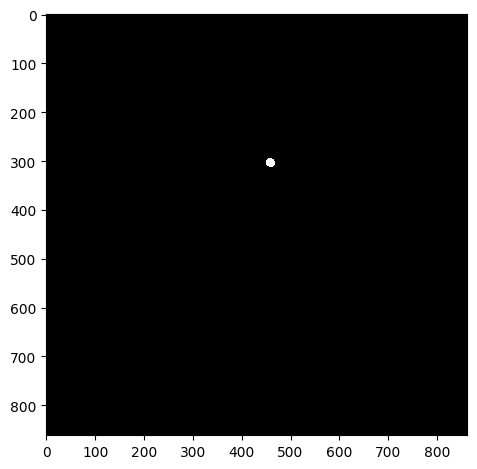

WT_PFF_noHTRA1_Hoechst_20x_03.czi


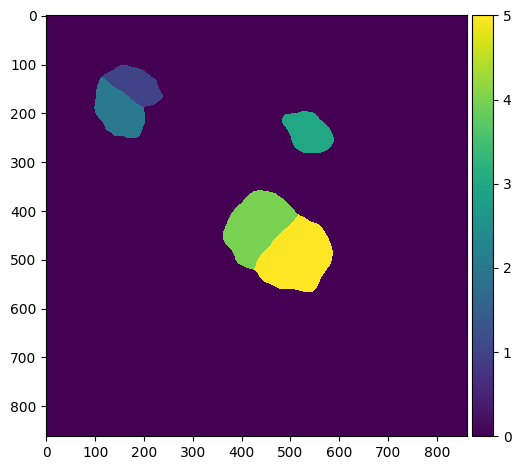

Cell:  2
Inclusion Area 553.0
Max Inclusion Area: 519.0
Cell Area: 6507.0
Ratio: 0.08498540033809743
Max Inclusion/Cell Area: 0.07976025818349469
Average Inclusion/Cell Area 0.042492700169048714


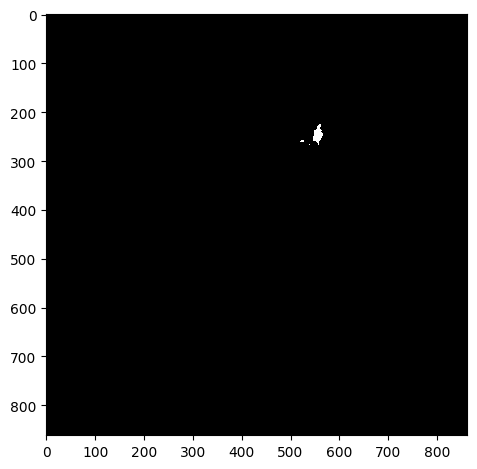

Cell:  3
Inclusion Area 1373.0
Max Inclusion Area: 873.0
Cell Area: 14479.0
Ratio: 0.09482699081428275
Max Inclusion/Cell Area: 0.06029421921403412
Average Inclusion/Cell Area 0.009482699081428276


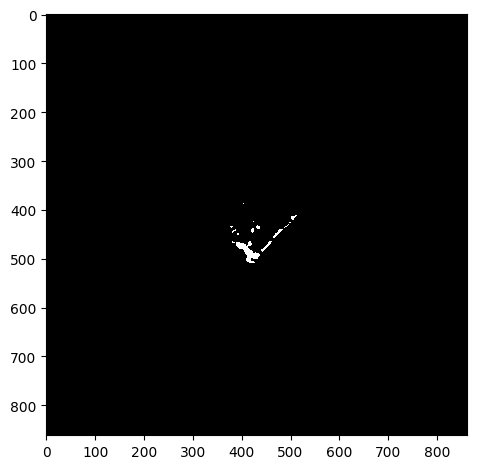

Cell:  4
Inclusion Area 908.0
Max Inclusion Area: 726.0
Cell Area: 16775.0
Ratio: 0.054128166915052164
Max Inclusion/Cell Area: 0.043278688524590166
Average Inclusion/Cell Area 0.027064083457526082


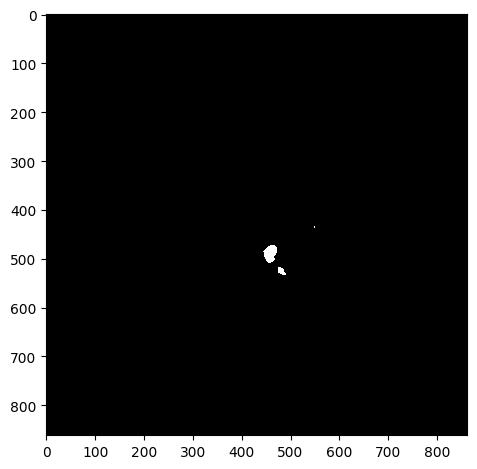

WT_PFF_noHTRA1_Hoechst_20x_04.czi


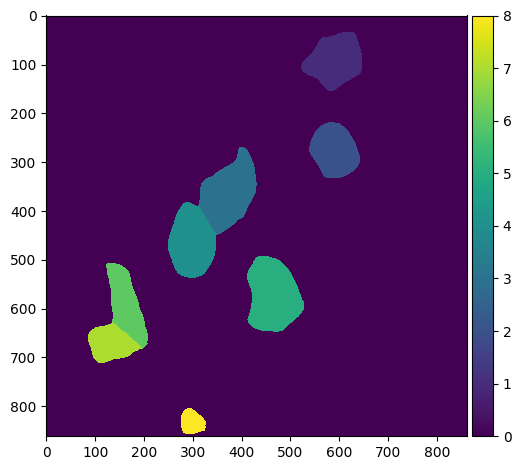

Cell:  2
Inclusion Area 421.0
Max Inclusion Area: 421.0
Cell Area: 12876.0
Ratio: 0.03269648959304132
Max Inclusion/Cell Area: 0.03269648959304132
Average Inclusion/Cell Area 0.03269648959304132


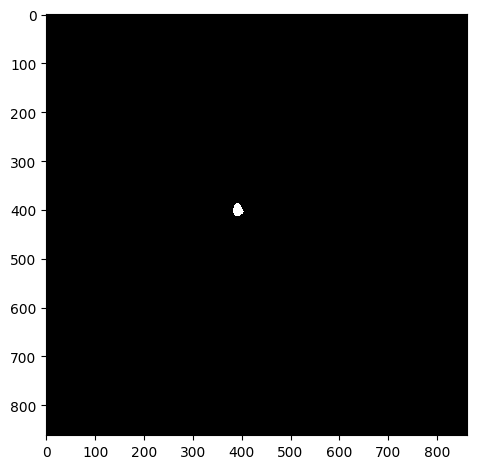

Cell:  3
Inclusion Area 2594.0
Max Inclusion Area: 1518.0
Cell Area: 11359.0
Ratio: 0.22836517299058015
Max Inclusion/Cell Area: 0.13363852451800334
Average Inclusion/Cell Area 0.04567303459811603


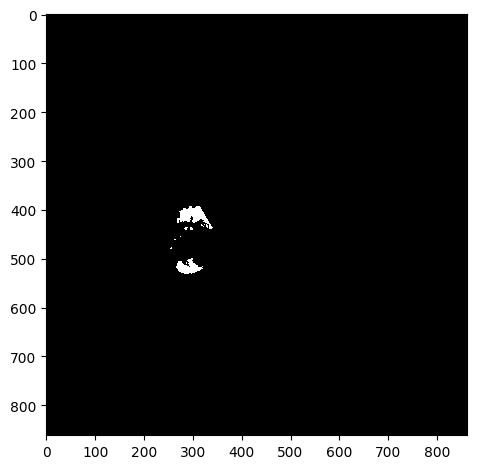

Cell:  4
Inclusion Area 399.0
Max Inclusion Area: 399.0
Cell Area: 13642.0
Ratio: 0.02924791086350975
Max Inclusion/Cell Area: 0.02924791086350975
Average Inclusion/Cell Area 0.02924791086350975


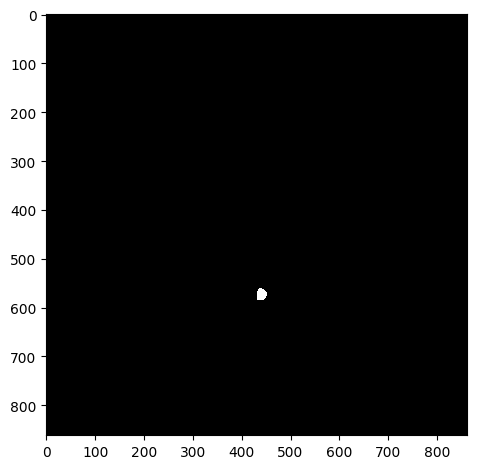

WT_PFF_noHTRA1_Hoechst_20x_05.czi


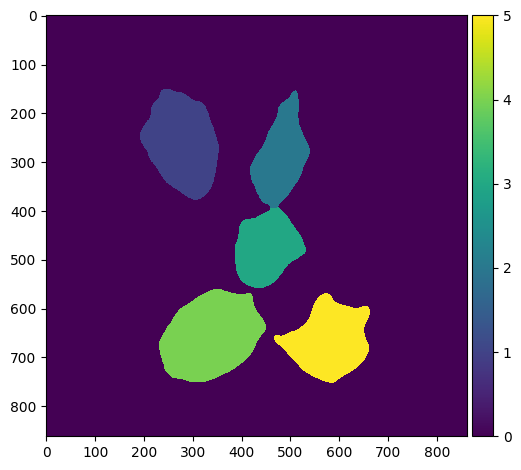

Cell:  2
Inclusion Area 1608.0
Max Inclusion Area: 389.0
Cell Area: 16532.0
Ratio: 0.09726590854101137
Max Inclusion/Cell Area: 0.023530123397048148
Average Inclusion/Cell Area 0.007481992964693183


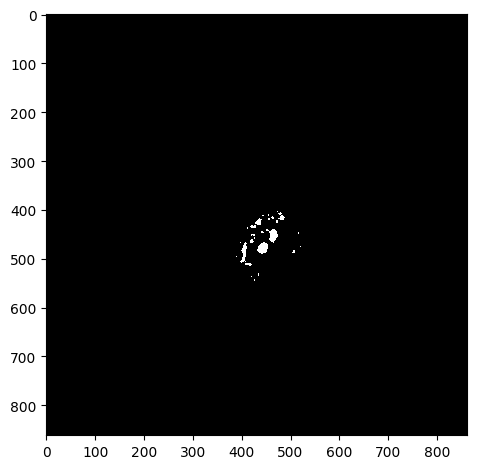

Cell:  3
Inclusion Area 2200.0
Max Inclusion Area: 875.0
Cell Area: 29767.0
Ratio: 0.07390734706218295
Max Inclusion/Cell Area: 0.02939496758155004
Average Inclusion/Cell Area 0.004347491003657821


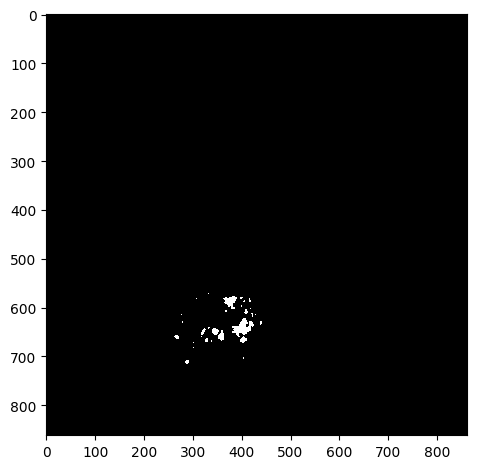

WT_PFF_noHTRA1_Hoechst_20x_06.czi


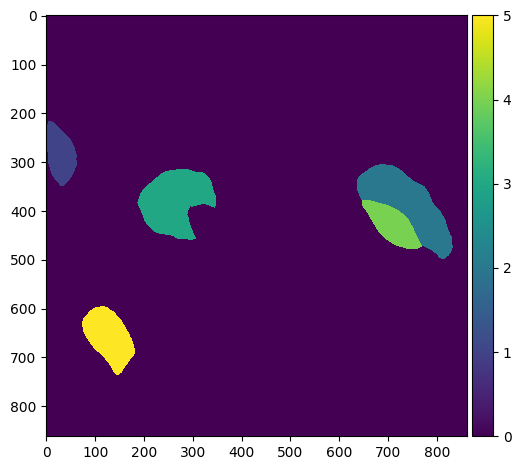

Cell:  2
Inclusion Area 579.0
Max Inclusion Area: 579.0
Cell Area: 15413.0
Ratio: 0.037565691299552326
Max Inclusion/Cell Area: 0.037565691299552326
Average Inclusion/Cell Area 0.037565691299552326


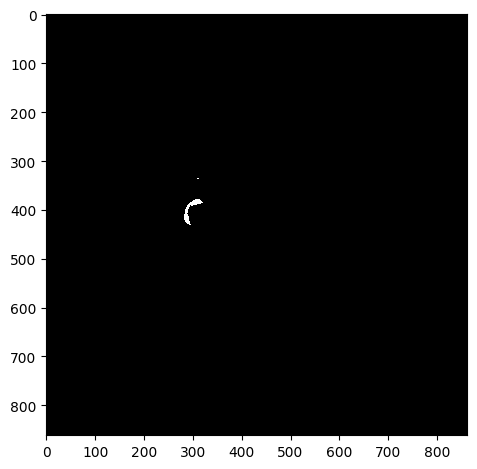

WT_PFF_noHTRA1_Hoechst_20x_07.czi


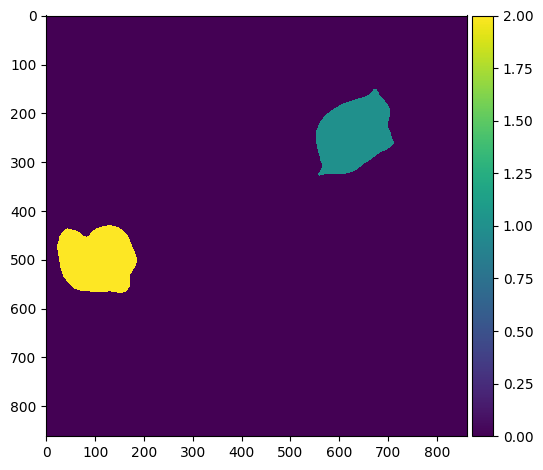

Cell:  0
Inclusion Area 1319.0
Max Inclusion Area: 1319.0
Cell Area: 19196.0
Ratio: 0.06871223171494062
Max Inclusion/Cell Area: 0.06871223171494062
Average Inclusion/Cell Area 0.06871223171494062


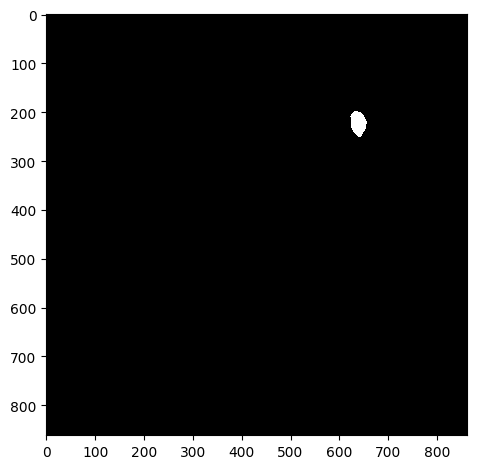

Cell:  1
Inclusion Area 941.0
Max Inclusion Area: 710.0
Cell Area: 18116.0
Ratio: 0.0519430337822919
Max Inclusion/Cell Area: 0.039191874586001325
Average Inclusion/Cell Area 0.02597151689114595


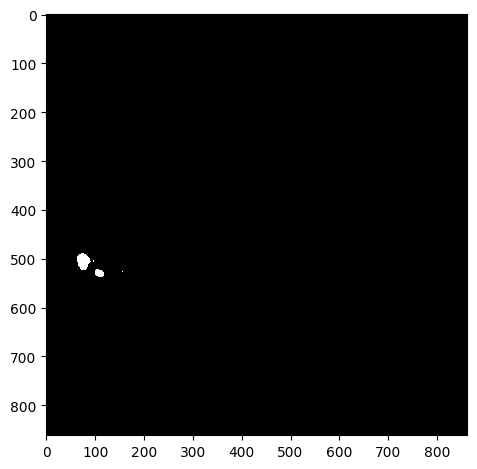

WT_PFF_noHTRA1_Hoechst_20x_08.czi


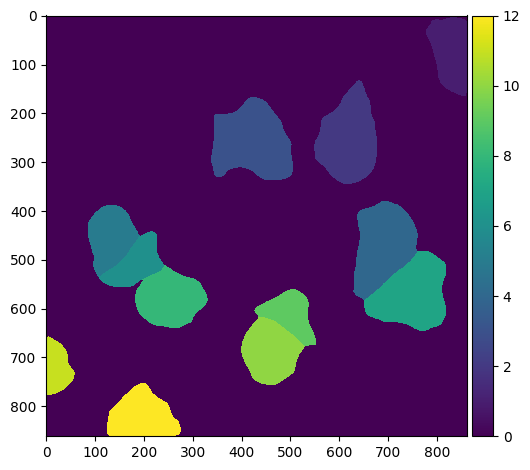

Cell:  5
Inclusion Area 1691.0
Max Inclusion Area: 1048.0
Cell Area: 7805.0
Ratio: 0.21665598975016015
Max Inclusion/Cell Area: 0.13427290198590647
Average Inclusion/Cell Area 0.021665598975016014


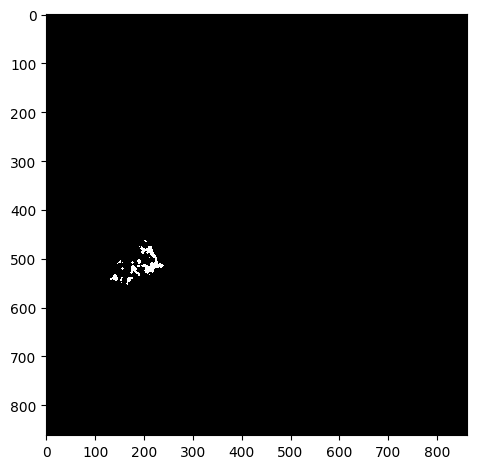

Cell:  6
Inclusion Area 4479.0
Max Inclusion Area: 3126.0
Cell Area: 18225.0
Ratio: 0.24576131687242797
Max Inclusion/Cell Area: 0.17152263374485596
Average Inclusion/Cell Area 0.011702919851067998


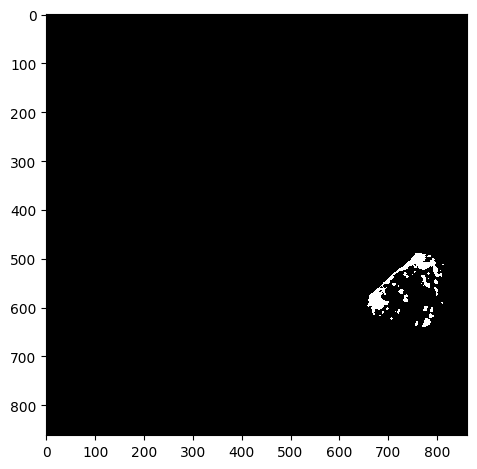

Cell:  7
Inclusion Area 1017.0
Max Inclusion Area: 1006.0
Cell Area: 13236.0
Ratio: 0.07683590208522212
Max Inclusion/Cell Area: 0.07600483529767302
Average Inclusion/Cell Area 0.03841795104261106


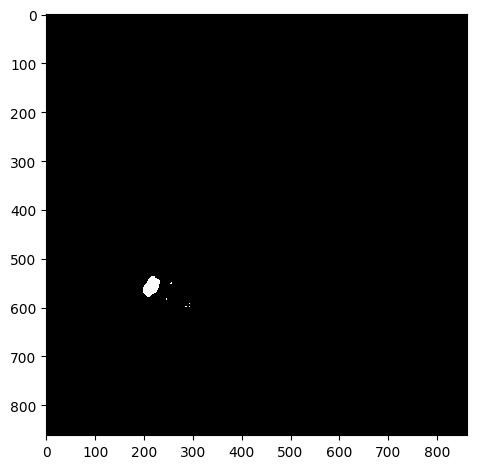

WT_PFF_noHTRA1_Hoechst_20x_09.czi


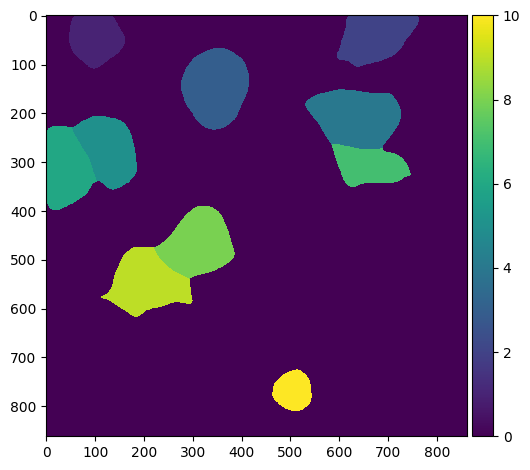

Cell:  7
Inclusion Area 2675.0
Max Inclusion Area: 736.0
Cell Area: 15765.0
Ratio: 0.16967967015540755
Max Inclusion/Cell Area: 0.04668569616238503
Average Inclusion/Cell Area 0.008483983507770377


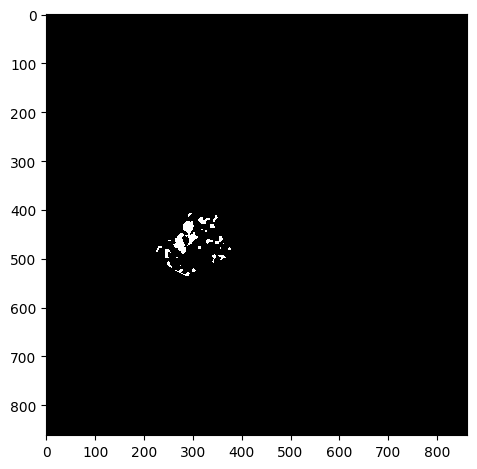

Cell:  8
Inclusion Area 4610.0
Max Inclusion Area: 3561.0
Cell Area: 16015.0
Ratio: 0.28785513581017796
Max Inclusion/Cell Area: 0.22235404308460818
Average Inclusion/Cell Area 0.01693265504765753


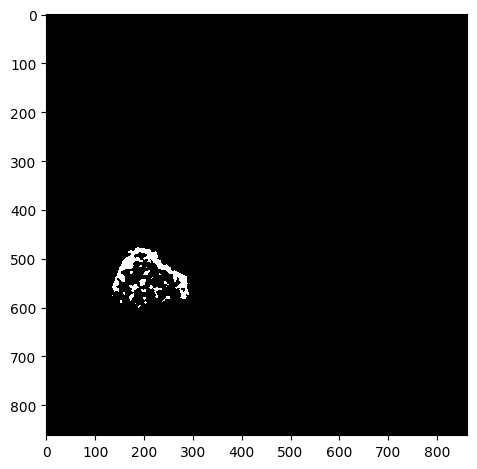

WT_PFF_noHTRA1_Hoechst_20x_10.czi


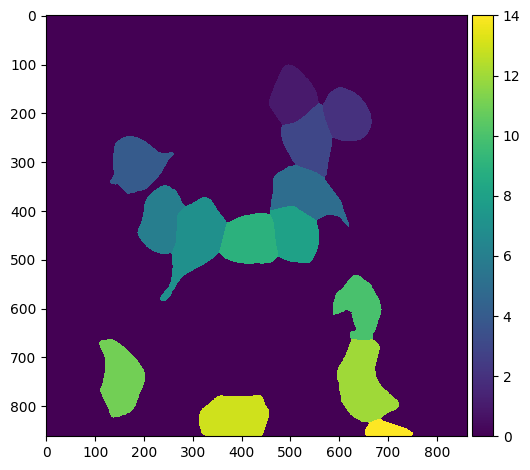

Cell:  3
Inclusion Area 396.0
Max Inclusion Area: 396.0
Cell Area: 9828.0
Ratio: 0.040293040293040296
Max Inclusion/Cell Area: 0.040293040293040296
Average Inclusion/Cell Area 0.040293040293040296


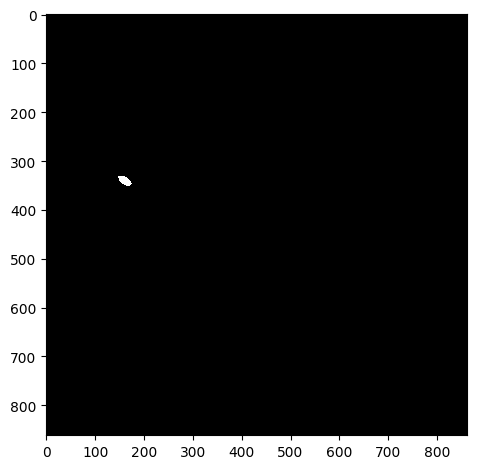

Cell:  7
Inclusion Area 2636.0
Max Inclusion Area: 2174.0
Cell Area: 8980.0
Ratio: 0.2935412026726058
Max Inclusion/Cell Area: 0.2420935412026726
Average Inclusion/Cell Area 0.04193445752465797


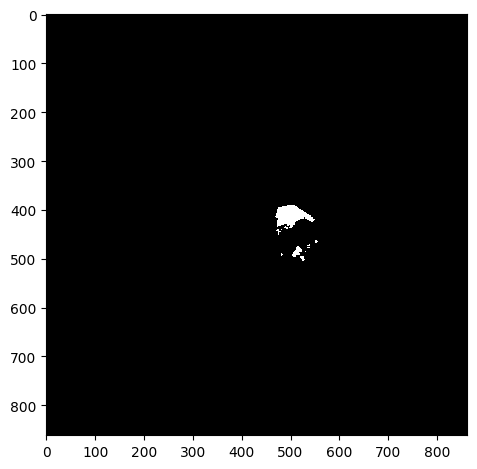

Cell:  9
Inclusion Area 61.0
Max Inclusion Area: 61.0
Cell Area: 8245.0
Ratio: 0.007398423286840509
Max Inclusion/Cell Area: 0.007398423286840509
Average Inclusion/Cell Area 0.007398423286840509


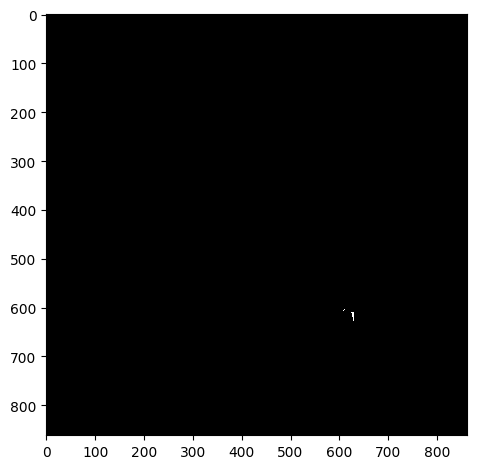

In [ ]:
if __name__ == "__main__":
    
    analyze_all_images('110724_PFF_HTRA1')
    analyze_all_images('103124_PFF_HTRA1/new new settings')
